## Download LJSpeech

In [1]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-12-06 12:00:36--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  36.8MB/s    in 73s     

2021-12-06 12:01:49 (35.9 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [2]:
!pip install librosa

In [3]:
!pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Featurizer

In [4]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [5]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

---

## Dataset

In [6]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveforn_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [7]:
dataset = LJSpeechDataset('.')

In [8]:
from typing import Tuple, Dict, Optional, List, Union
from itertools import islice

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


@dataclass
class Batch:
    waveform: torch.Tensor
    waveforn_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> 'Batch':
        raise NotImplementedError


class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        waveform, waveforn_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveforn_length = torch.cat(waveforn_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveforn_length, transcript, tokens, token_lengths)

In [9]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [10]:
dummy_batch = list(islice(dataloader, 1))[0]
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

---

## Vocoder

In [11]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.59 KiB | 11.77 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [12]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [13]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [14]:
import warnings
import sys
sys.path.append('waveglow/')

warnings.filterwarnings('ignore')


class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

In [15]:
vocoder = Vocoder().to('cuda').eval()

In [16]:
waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform).cuda()

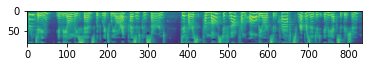

In [17]:
plt.imshow(mels[0].cpu())

In [18]:
reconstructed_wav = vocoder.inference(mels).cpu()

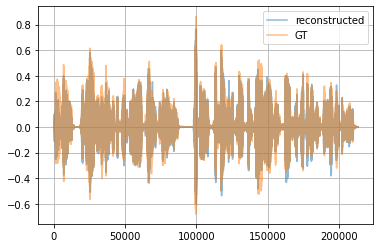

In [19]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [20]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

---

## Grapheme Aligner

In [21]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


class GraphemeAligner(nn.Module):

    def __init__(self):
        super().__init__()

        self._wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
        self._labels = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_labels()
        self._char2index = {c: i for i, c in enumerate(self._labels)}
        self._unk_index = self._char2index['<unk>']
        self._resampler = torchaudio.transforms.Resample(
            orig_freq=MelSpectrogramConfig.sr, new_freq=16_000
        )

    def _decode_text(self, text):
        text = text.replace(' ', '|').upper()
        return torch.tensor([
            self._char2index.get(char, self._unk_index)
            for char in text
        ]).long()

    @torch.no_grad()
    def forward(
        self,
        wavs: torch.Tensor,
        wav_lengths: torch.Tensor,
        texts: Union[str, List[str]]
    ):
        if isinstance(texts, str):
            texts = [texts]
        batch_size = wavs.shape[0]

        durations = []
        for index in range(batch_size):
            current_wav = wavs[index, :wav_lengths[index]].unsqueeze(dim=0)
            current_wav = self._resampler(current_wav)
            emission, _ = self._wav2vec2(current_wav)
            emission = emission.log_softmax(dim=-1).squeeze(dim=0).cpu()

            tokens = self._decode_text(texts[index])

            trellis = self._get_trellis(emission, tokens)
            path = self._backtrack(trellis, emission, tokens)
            segments = self._merge_repeats(texts[index], path)

            num_frames = emission.shape[0]
            relative_durations = torch.tensor([
                segment.length / num_frames for segment in segments
            ])

            durations.append(relative_durations)
            
        durations = pad_sequence(durations).transpose(0, 1)
        return durations

    def _get_trellis(self, emission, tokens, blank_id=0):
        num_frame = emission.size(0)
        num_tokens = len(tokens)

        # Trellis has extra dimension for both time axis and tokens.
        # The extra dim for tokens represents <SoS> (start-of-sentence)
        # The extra dim for time axis is for simplification of the code.
        trellis = torch.full((num_frame + 1, num_tokens + 1), -float('inf'))
        trellis[:, 0] = 0
        for t in range(num_frame):
            trellis[t + 1, 1:] = torch.maximum(
                # Score for staying at the same token
                trellis[t, 1:] + emission[t, blank_id],

                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens],
            )
        return trellis

    def _backtrack(self, trellis, emission, tokens, blank_id=0):
        # Note:
        # j and t are indices for trellis, which has extra dimensions
        # for time and tokens at the beginning.
        # When refering to time frame index `T` in trellis,
        # the corresponding index in emission is `T-1`.
        # Similarly, when refering to token index `J` in trellis,
        # the corresponding index in transcript is `J-1`.
        j = trellis.size(1) - 1
        t_start = torch.argmax(trellis[:, j]).item()

        path = []
        for t in range(t_start, 0, -1):
            # 1. Figure out if the current position was stay or change
            # Note (again):
            # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
            # Score for token staying the same from time frame J-1 to T.
            stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
            # Score for token changing from C-1 at T-1 to J at T.
            changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

            # 2. Store the path with frame-wise probability.
            prob = emission[t - 1, tokens[j - 1]
                            if changed > stayed else 0].exp().item()
            # Return token index and time index in non-trellis coordinate.
            path.append(Point(j - 1, t - 1, prob))

            # 3. Update the token
            if changed > stayed:
                j -= 1
                if j == 0:
                    break

        else:
            raise ValueError('Failed to align')

        return path[::-1]

    def _merge_repeats(self, text, path):
        i1, i2 = 0, 0
        segments = []
        while i1 < len(path):
            while i2 < len(path) and path[i1].token_index == path[i2].token_index:
                i2 += 1
            score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
            segments.append(
                Segment(
                    text[path[i1].token_index],
                    path[i1].time_index,
                    path[i2 - 1].time_index + 1,
                    score
                )
            )
            i1 = i2

        return segments

    @staticmethod
    def plot_trellis_with_path(trellis, path):
        # to plot trellis with path, we take advantage of 'nan' value
        trellis_with_path = trellis.clone()
        for i, p in enumerate(path):
            trellis_with_path[p.time_index, p.token_index] = float('nan')
        plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

In [22]:
device = torch.device('cpu')
aligner = GraphemeAligner().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [23]:
dummy_batch.durations = aligner(
    dummy_batch.waveform.to(device), dummy_batch.waveforn_length, dummy_batch.transcript
)

In [ ]:
dummy_batch

## Visualize

In [25]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------


In [26]:
dummy_batch.transcript[index]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

#Model

In [27]:
import math

In [28]:
class Embed(nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings,embedding_dim)
    def forward(self, batch):
        return self.embedding(batch)

In [29]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [30]:
import torch.nn.functional as F

Encoder

In [31]:
import copy

In [32]:
def clones(module, N):
    "Копирут блоки N раз"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [33]:
class LayerNorm(nn.Module):
    "Модуль для нормироки слоя"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [34]:
class Encoder(nn.Module):
    "Базовый кодировщик представляет собой стек из N слоев."
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Пропускает входные данные через каждый слой"
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [35]:
def attention(query, key, value, dropout=None):
    "Вычисляет 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    p_attn = nn.functional.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [36]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Создант self-attention с h головами"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [37]:
class Conv1d(nn.Module):
    "Вычисляет FFN блок, часть со свертками."
    def __init__(self, d_model = 384, hiden = 1536 , kernal_size = 3, dropout=0.1):
        super(Conv1d, self).__init__()
        self.conv1 = nn.Conv1d(d_model, hiden, kernal_size, padding=1)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(hiden, d_model, kernal_size, padding=1)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.dropout2(F.relu(self.conv2(x)))
        x = torch.permute(x, (0, 2, 1))
        return x

In [38]:
class lenRegulator(nn.Module):
    "Модуль для регулировки длиины"
    def __init__(self, in_channels = 384, filter_size = 256,  kernal_size = 3, dropout=0.1):
        super(lenRegulator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, filter_size,kernal_size, padding=1)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(filter_size)
        self.conv2 = nn.Conv1d(filter_size, filter_size,kernal_size, padding=1)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = LayerNorm(filter_size)
        self.linear =  nn.Linear(filter_size, 1)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.conv1(x)
        x = self.norm1(torch.permute(x, (0, 2, 1)))
        x = self.dropout1(F.relu(x))
        x = self.conv2(torch.permute(x, (0, 2, 1)))
        x = self.norm2(torch.permute(x, (0, 2, 1)))
        x = self.dropout2(F.relu(torch.permute(x, (0, 2, 1))))
        x = torch.permute(x, (0, 2, 1))
        x = self.linear(x)
        return x

In [39]:
class Linear_Layer(nn.Module):
    "Последний слой модели, выдает блоки [B, n_mels, Time]"
    def __init__(self, in_channels = 384, filter_size = 80, dropout=0.1):
        super(Linear_Layer, self).__init__()
        self.linear = nn.Linear(in_channels, filter_size)

    def forward(self, x):
        x = self.linear(x)
        return x

In [40]:
class SublayerConnection(nn.Module):
    """
    Модуль перебрски весов( residual connection)
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        out = self.norm(x)
        out = sublayer(out)
        out = self.dropout(out)
        return x + out

In [41]:
class EncoderLayer(nn.Module):
    "один FFT Block "
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        "-----------"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [297]:
class Model(nn.Module):
    """
    Feed-Forward Transformer модель
    """
    def __init__(self,embedding, position_emb, encoder, duration_predictor, decoder, position_emb2, generator):
        super(Model, self).__init__()
       
        self.embedding = embedding
        self.position_emb = position_emb

        self.encoder = encoder
        self.duration_predictor = duration_predictor
        self.decoder = decoder
        self.position_emb2 = position_emb2
        self.generator = generator
        
    def forward(self, src, input_dur_inframe = None, device="cuda"):
        "-----"
        encode = self.encode(src)
        duration_predictor = self.duration_predictor(encode)

        if input_dur_inframe is not None:

            input_dur_inframe = input_dur_inframe.long()
            outp = torch.zeros((src.shape[0], torch.sum(input_dur_inframe, dim=-1).max(), encode.shape[-1])).to(device) # [5, Time, 384]
            N, L = input_dur_inframe.shape
            for j in range(N):
                count = 0
                for k in range(L):
                    kol = input_dur_inframe[j][k]
                    if kol != 0:
                        outp[j,count:count+kol] = encode[j,k]
                        count += kol
        else:
            dur_out = duration_predictor
            input_dur_inframe = torch.round(torch.exp(dur_out.squeeze())).long()
            outp = torch.zeros((src.shape[0], torch.sum(input_dur_inframe, dim=-1).max(), encode.shape[-1])).to(device) # [5, Time, 384]
            print("outp=", outp.shape)
            print(input_dur_inframe.shape)
            if input_dur_inframe.dim() == 1:
                N, L = 1, len(input_dur_inframe)
            else:
                N, L = input_dur_inframe.shape
            for j in range(N):
                count = 0
                for k in range(L):
                    kol = input_dur_inframe[j][k]
                    if kol != 0:
                        outp[j,count:count+kol] = encode[j,k]
                        count += kol
        print("outp=", duration_predictor.shape)
        decoder = self.decoder(outp)
        mel_spec = torch.permute(self.generator(decoder), (0, 2, 1))
        return mel_spec, duration_predictor # reruen both mel_pred and duration_pred 
    
    def encode(self, src):
        x = self.position_emb(self.embedding(src))
        return self.encoder(x)
    
    def decode(self, src):
        return self.decoder(self.position_emb2(src))

In [298]:
class ModelConfig:
    src_vocab: int = 38
    N: int = 2
    fft_hidden: int = 192
    blockconv_filtersize: int = 768
    len_red_filtersize: int = 128
    mel_size: int = 80
    head: int = 2
    dropout: float = 0.1

In [299]:
modelconfig = ModelConfig()

In [300]:
# def make_model(src_vocab = 38, N=6, 
#                fft_hidden=384, blockconv_filtersize = 1536, len_red_filtersize = 256, mel_size = 80 ,head=2, dropout=0.1):    #Параметры со статьи 
def make_model(src_vocab = 38, N=2, 
               fft_hidden=192, blockconv_filtersize = 768, len_red_filtersize = 128, mel_size = 80 ,head=2, dropout=0.1): #Параметры для обучения на 1 батче 
    "Helper: Construct a model from hyperparameters."
    copy_of_this_layer = copy.deepcopy
    attn = MultiHeadedAttention(head, fft_hidden)
    conv1d = Conv1d(d_model = fft_hidden, hiden = blockconv_filtersize)
    embedding  = Embed(src_vocab, fft_hidden)
    position_emb = PositionalEncoding(fft_hidden, dropout)
    position_emb2 = PositionalEncoding(fft_hidden, dropout)
    model = Model(
            embedding,
            position_emb,
            Encoder(EncoderLayer(fft_hidden, copy_of_this_layer(attn), copy_of_this_layer(conv1d), dropout), N),
            lenRegulator(fft_hidden, len_red_filtersize),
            Encoder(EncoderLayer(fft_hidden, copy_of_this_layer(attn), copy_of_this_layer(conv1d), dropout), N),
            position_emb2,
            Linear_Layer(fft_hidden, mel_size),
            )
    # for p in model.parameters():
    #     if p.dim() > 1:
    #         nn.init.xavier_uniform(p)
    return model

In [301]:
model = make_model(modelconfig.src_vocab, modelconfig.N, modelconfig.fft_hidden, modelconfig.blockconv_filtersize,
                   modelconfig.len_red_filtersize, modelconfig.mel_size, modelconfig.head, modelconfig.dropout)

In [302]:
sum(p.numel() for p in model.parameters())


4286033

In [303]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

Train Loop

In [304]:
device = "cuda"

In [305]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=25, collate_fn=LJSpeechCollator())
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)

In [277]:
%matplotlib inline

In [256]:
%%capture
!pip install wandb

In [152]:
import wandb

wandb.init(project="TTS", entity="mishaya")

In [306]:
class ModelConfig:
    src_vocab: int = 38
    N: int = 6
    fft_hidden: int = 384
    blockconv_filtersize: int = 1024
    len_red_filtersize: int = 256
    mel_size: int = 80
    head: int = 2
    dropout: float = 0.1

In [307]:
modelconfig = ModelConfig()

In [155]:
wandb.config = {
  "model_config": modelconfig,
  "mel_config": MelSpectrogramConfig,
  "batch_size": 12
}

In [308]:
model = make_model(modelconfig.src_vocab, modelconfig.N, modelconfig.fft_hidden, modelconfig.blockconv_filtersize,
                   modelconfig.len_red_filtersize, modelconfig.mel_size, modelconfig.head, modelconfig.dropout).to(device)

In [309]:
import torch.optim as optim

loss_one = nn.MSELoss()
loss_second = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 0.0003)

In [310]:
class WarmupWrapper:
    def __init__(self, warmup: int, optimizer: torch.optim.Optimizer, max_lr: float) -> None:
        self.optimizer = optimizer
        self._step = 0
        self._rate = 0
        self.max_lr = max_lr
        self.warmup = warmup
        self._lrs = (torch.arange(start=0, end=warmup) / warmup) * max_lr

    def state_dict(self):
        return {key: value for key, value in self.dict.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        self.dict.update(state_dict)

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        if step >= self.warmup:
            return self.max_lr
        return self._lrs[step]

    def zero_grad(self):
        self.optimizer.zero_grad()

In [311]:
optimizer = WarmupWrapper(1000, optimizer, 0.0006)

# Learning

One batch

In [ ]:
aligner = GraphemeAligner().to(device)

In [ ]:
data = next(iter(dataloader))

In [ ]:
aligner.eval()
for i in range(5000): 
    durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
    inputs_text = data.tokens.to(device)
    inputs_text_len = data.token_lengths.to(device)
    inputs_wavs = data.waveform.to(device)
    inputs_wavs_len = data.waveforn_length.to(device)
    
    specs_GT = featurizer(inputs_wavs)
    # for i, wav in enumerate(inputs_wavs):
    #     print(featurizer(wav[:inputs_wavs_len[i]]).shape)

    if durations.shape != inputs_text.shape:    # Проверка на совпадение размерностей
        print("log unequal dim")
    durations = (durations[:,:inputs_text.shape[-1]]) #Если размерности не совпадют то durations обрезается справа до длины максмального количесва символов в тексе
    durations = (durations / durations.sum(dim=1)[:, None]) # Нормализация до суммы 1 всех элементов 
    durations = durations * inputs_wavs_len[:, None] # Получили длины в индексах  wav для каждой буквы
    durations = durations.cumsum(dim=1).int() # Возврат совокупной суммы элементов по заданной оси.
    durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max()) #  переход в количесво фреймов 
    for j in range(len(durations)): # цикл для перехода от [[1, 2, 6, 11, 11, 11, 11 ],...] -> [[1, 2, 6, 11, 0, 0, 0 ],...] 
        row = torch.unique_consecutive(durations[j])
        durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)

    for j in range(durations.shape[0]): # цикл для перехода от ат совокупной суммы элементов по заданной оси -> к последовательноси продолжительности фонемы D = [2, 2, 3, 1, 0, 0, 0],
        pred = 0
        for k in range(durations.shape[-1]):
            curr = durations[j][k]
            if pred != 0 and curr != 0:
                durations[j][k] -= pred
            pred += curr
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    spec_out, dur_out = model(inputs_text, durations)

    groud_true = torch.log(durations.clamp(1e-5)) 

    loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
    print(loss)
    if i % 20 == 0:
        print(i)
        plt.imshow((spec_out[0]).cpu().detach().numpy())
    loss.backward()
    optimizer.step()

# Новый разделdd

In [ ]:
plt.imshow((spec_out[0]).cpu().detach().numpy())

In [ ]:
plt.imshow((spec_out[1]).cpu().detach().numpy())

In [ ]:
plt.imshow((spec_out[3]).cpu().detach().numpy())

In [ ]:
reconstructed_wav = vocoder.inference(spec_out[0].unsqueeze(dim=0).cuda()).cpu()

In [ ]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [ ]:
display.display(display.Audio(reconstructed_wav, rate=22050))


In [ ]:
reconstructed_wav = vocoder.inference(spec_out[1].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


In [ ]:
reconstructed_wav = vocoder.inference(spec_out[2].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


In [ ]:
reconstructed_wav = vocoder.inference(spec_out[3].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


# ALL data

In [284]:
from torch.utils.data import  Subset

In [285]:
dataset = LJSpeechDataset('.')

In [286]:
train_ratio = 0.9
torch.manual_seed(41)
train_size = int(len(dataset) * train_ratio)
valtidation_size = len(dataset) - train_size 

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

In [287]:
train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [288]:
dataloader_train = DataLoader(train_dataset, batch_size=10, collate_fn=LJSpeechCollator())
dataloader_valid = DataLoader(validation_dataset, batch_size=10, collate_fn=LJSpeechCollator())

In [289]:
from tqdm import tqdm

In [202]:
# import gc
# import torch
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [312]:
aligner = GraphemeAligner().to(device)

In [313]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_DLA/TTS/Full DS/polar-violet-26.pt'))

<All keys matched successfully>

  0%|          | 1/1179 [00:01<21:56,  1.12s/it]

continue


  tensor(1.5269, grad_fn=<ToCopyBackward0>)


  0%|          | 2/1179 [00:02<27:42,  1.41s/it]

  tensor(1.5814, grad_fn=<ToCopyBackward0>)


  0%|          | 3/1179 [00:04<28:15,  1.44s/it]

  tensor(1.4893, grad_fn=<ToCopyBackward0>)


  0%|          | 4/1179 [00:05<28:56,  1.48s/it]

  tensor(1.7388, grad_fn=<ToCopyBackward0>)


  0%|          | 5/1179 [00:07<31:38,  1.62s/it]

  tensor(1.6957, grad_fn=<ToCopyBackward0>)


  1%|          | 6/1179 [00:09<32:06,  1.64s/it]

  tensor(1.4618, grad_fn=<ToCopyBackward0>)


  1%|          | 7/1179 [00:10<31:04,  1.59s/it]

  tensor(1.3688, grad_fn=<ToCopyBackward0>)


  1%|          | 8/1179 [00:12<31:10,  1.60s/it]

  tensor(1.6047, grad_fn=<ToCopyBackward0>)


  1%|          | 9/1179 [00:14<32:01,  1.64s/it]

  tensor(1.5420, grad_fn=<ToCopyBackward0>)


  1%|          | 10/1179 [00:15<31:08,  1.60s/it]

  tensor(1.3956, grad_fn=<ToCopyBackward0>)


  1%|          | 11/1179 [00:17<30:51,  1.59s/it]

  tensor(1.4973, grad_fn=<ToCopyBackward0>)


  1%|          | 12/1179 [00:19<32:35,  1.68s/it]

  tensor(1.5195, grad_fn=<ToCopyBackward0>)


  1%|          | 13/1179 [00:20<33:03,  1.70s/it]

  tensor(1.4032, grad_fn=<ToCopyBackward0>)


  1%|▏         | 15/1179 [00:23<28:39,  1.48s/it]

continue


  tensor(1.1793, grad_fn=<ToCopyBackward0>)


  1%|▏         | 16/1179 [00:24<27:41,  1.43s/it]

  tensor(1.4848, grad_fn=<ToCopyBackward0>)


  1%|▏         | 17/1179 [00:26<29:09,  1.51s/it]

  tensor(1.5512, grad_fn=<ToCopyBackward0>)


  2%|▏         | 18/1179 [00:27<28:37,  1.48s/it]

  tensor(1.5330, grad_fn=<ToCopyBackward0>)


  2%|▏         | 19/1179 [00:29<29:40,  1.53s/it]

  tensor(1.5482, grad_fn=<ToCopyBackward0>)


  2%|▏         | 20/1179 [00:31<31:03,  1.61s/it]

  tensor(1.7902, grad_fn=<ToCopyBackward0>)


  2%|▏         | 21/1179 [00:32<30:39,  1.59s/it]

  tensor(1.3438, grad_fn=<ToCopyBackward0>)


  2%|▏         | 23/1179 [00:35<27:59,  1.45s/it]

continue


  tensor(1.2845, grad_fn=<ToCopyBackward0>)


  2%|▏         | 24/1179 [00:36<27:48,  1.44s/it]

  tensor(1.1937, grad_fn=<ToCopyBackward0>)


  2%|▏         | 26/1179 [00:39<26:21,  1.37s/it]

continue


 log unequal dim
  tensor(1.3419, grad_fn=<ToCopyBackward0>)


  2%|▏         | 27/1179 [00:41<26:33,  1.38s/it]

  tensor(1.3792, grad_fn=<ToCopyBackward0>)


  2%|▏         | 28/1179 [00:42<28:39,  1.49s/it]

  tensor(1.6176, grad_fn=<ToCopyBackward0>)


  2%|▏         | 29/1179 [00:44<29:32,  1.54s/it]

  tensor(1.2472, grad_fn=<ToCopyBackward0>)


  3%|▎         | 30/1179 [00:45<28:28,  1.49s/it]

 log unequal dim
  tensor(1.3631, grad_fn=<ToCopyBackward0>)


  3%|▎         | 31/1179 [00:47<29:09,  1.52s/it]

  tensor(1.2147, grad_fn=<ToCopyBackward0>)


  3%|▎         | 32/1179 [00:48<28:55,  1.51s/it]

  tensor(1.7760, grad_fn=<ToCopyBackward0>)


  3%|▎         | 33/1179 [00:50<29:22,  1.54s/it]

  tensor(1.5332, grad_fn=<ToCopyBackward0>)


  3%|▎         | 34/1179 [00:52<30:33,  1.60s/it]

  tensor(1.6004, grad_fn=<ToCopyBackward0>)


  3%|▎         | 35/1179 [00:53<30:20,  1.59s/it]

  tensor(1.3106, grad_fn=<ToCopyBackward0>)


  3%|▎         | 36/1179 [00:55<30:26,  1.60s/it]

 log unequal dim
  tensor(1.4013, grad_fn=<ToCopyBackward0>)


  3%|▎         | 37/1179 [00:57<30:15,  1.59s/it]

  tensor(1.7387, grad_fn=<ToCopyBackward0>)


  3%|▎         | 38/1179 [00:58<29:36,  1.56s/it]

  tensor(1.6317, grad_fn=<ToCopyBackward0>)


  3%|▎         | 39/1179 [01:00<29:51,  1.57s/it]

  tensor(1.5647, grad_fn=<ToCopyBackward0>)


  3%|▎         | 40/1179 [01:01<29:53,  1.57s/it]

  tensor(1.5154, grad_fn=<ToCopyBackward0>)


  3%|▎         | 41/1179 [01:03<30:48,  1.62s/it]

  tensor(1.7939, grad_fn=<ToCopyBackward0>)


  4%|▎         | 42/1179 [01:05<30:48,  1.63s/it]

 log unequal dim
  tensor(1.5790, grad_fn=<ToCopyBackward0>)


  4%|▎         | 43/1179 [01:06<30:50,  1.63s/it]

  tensor(1.5072, grad_fn=<ToCopyBackward0>)


  4%|▎         | 44/1179 [01:08<30:03,  1.59s/it]

  tensor(1.2452, grad_fn=<ToCopyBackward0>)


  4%|▍         | 45/1179 [01:09<29:28,  1.56s/it]

  tensor(1.5365, grad_fn=<ToCopyBackward0>)


  4%|▍         | 46/1179 [01:11<30:17,  1.60s/it]

  tensor(1.4687, grad_fn=<ToCopyBackward0>)


  4%|▍         | 47/1179 [01:12<29:26,  1.56s/it]

  tensor(1.3811, grad_fn=<ToCopyBackward0>)


  4%|▍         | 48/1179 [01:14<29:02,  1.54s/it]

  tensor(1.2406, grad_fn=<ToCopyBackward0>)


  4%|▍         | 49/1179 [01:15<28:20,  1.50s/it]

  tensor(1.3643, grad_fn=<ToCopyBackward0>)


  4%|▍         | 50/1179 [01:17<29:05,  1.55s/it]

  tensor(1.4693, grad_fn=<ToCopyBackward0>)


  4%|▍         | 51/1179 [01:20<35:58,  1.91s/it]

  tensor(1.4988, grad_fn=<ToCopyBackward0>)


  4%|▍         | 52/1179 [01:22<35:39,  1.90s/it]

  tensor(1.4940, grad_fn=<ToCopyBackward0>)


  4%|▍         | 53/1179 [01:23<32:36,  1.74s/it]

  tensor(1.1999, grad_fn=<ToCopyBackward0>)


  5%|▍         | 54/1179 [01:24<30:45,  1.64s/it]

  tensor(1.7399, grad_fn=<ToCopyBackward0>)


  5%|▍         | 55/1179 [01:26<30:38,  1.64s/it]

  tensor(1.4002, grad_fn=<ToCopyBackward0>)


  5%|▍         | 56/1179 [01:27<29:45,  1.59s/it]

  tensor(1.1656, grad_fn=<ToCopyBackward0>)


  5%|▍         | 57/1179 [01:29<29:04,  1.55s/it]

  tensor(1.2792, grad_fn=<ToCopyBackward0>)


  5%|▍         | 58/1179 [01:30<28:50,  1.54s/it]

  tensor(1.3728, grad_fn=<ToCopyBackward0>)


  5%|▌         | 59/1179 [01:32<29:22,  1.57s/it]

  tensor(1.4840, grad_fn=<ToCopyBackward0>)


  5%|▌         | 60/1179 [01:34<29:39,  1.59s/it]

  tensor(1.6327, grad_fn=<ToCopyBackward0>)


  5%|▌         | 61/1179 [01:35<29:41,  1.59s/it]

 log unequal dim
  tensor(1.6373, grad_fn=<ToCopyBackward0>)


  5%|▌         | 62/1179 [01:37<29:35,  1.59s/it]

  tensor(1.4856, grad_fn=<ToCopyBackward0>)


  5%|▌         | 63/1179 [01:38<29:44,  1.60s/it]

  tensor(1.1103, grad_fn=<ToCopyBackward0>)


  5%|▌         | 64/1179 [01:40<28:58,  1.56s/it]

  tensor(1.4713, grad_fn=<ToCopyBackward0>)


  6%|▌         | 65/1179 [01:42<29:09,  1.57s/it]

  tensor(1.6766, grad_fn=<ToCopyBackward0>)


  6%|▌         | 66/1179 [01:43<30:34,  1.65s/it]

  tensor(1.6966, grad_fn=<ToCopyBackward0>)


  6%|▌         | 68/1179 [01:46<27:56,  1.51s/it]

continue


 log unequal dim
  tensor(1.8819, grad_fn=<ToCopyBackward0>)


  6%|▌         | 69/1179 [01:48<29:09,  1.58s/it]

  tensor(1.2915, grad_fn=<ToCopyBackward0>)


  6%|▌         | 70/1179 [01:49<28:08,  1.52s/it]

  tensor(1.4217, grad_fn=<ToCopyBackward0>)


  6%|▌         | 71/1179 [01:51<28:24,  1.54s/it]

  tensor(1.2305, grad_fn=<ToCopyBackward0>)


  6%|▌         | 72/1179 [01:52<27:48,  1.51s/it]

  tensor(1.7326, grad_fn=<ToCopyBackward0>)


  6%|▌         | 73/1179 [01:54<28:17,  1.54s/it]

  tensor(1.5736, grad_fn=<ToCopyBackward0>)


  6%|▋         | 74/1179 [01:56<28:51,  1.57s/it]

  tensor(1.7723, grad_fn=<ToCopyBackward0>)


  6%|▋         | 75/1179 [01:57<28:38,  1.56s/it]

  tensor(1.4152, grad_fn=<ToCopyBackward0>)


  6%|▋         | 76/1179 [01:59<28:28,  1.55s/it]

  tensor(1.6794, grad_fn=<ToCopyBackward0>)


  7%|▋         | 77/1179 [02:00<28:50,  1.57s/it]

  tensor(1.5115, grad_fn=<ToCopyBackward0>)


  7%|▋         | 78/1179 [02:02<29:01,  1.58s/it]

  tensor(1.3567, grad_fn=<ToCopyBackward0>)


  7%|▋         | 79/1179 [02:04<29:36,  1.62s/it]

  tensor(1.6751, grad_fn=<ToCopyBackward0>)


  7%|▋         | 80/1179 [02:05<29:57,  1.64s/it]

  tensor(1.4875, grad_fn=<ToCopyBackward0>)


  7%|▋         | 81/1179 [02:07<29:08,  1.59s/it]

  tensor(1.5995, grad_fn=<ToCopyBackward0>)


  7%|▋         | 82/1179 [02:08<28:12,  1.54s/it]

  tensor(1.6105, grad_fn=<ToCopyBackward0>)


  7%|▋         | 83/1179 [02:10<28:00,  1.53s/it]

  tensor(1.6086, grad_fn=<ToCopyBackward0>)


  7%|▋         | 84/1179 [02:11<27:35,  1.51s/it]

  tensor(2.2566, grad_fn=<ToCopyBackward0>)


  7%|▋         | 85/1179 [02:13<29:04,  1.59s/it]

  tensor(1.5384, grad_fn=<ToCopyBackward0>)


  7%|▋         | 86/1179 [02:15<29:01,  1.59s/it]

 log unequal dim
  tensor(2.4017, grad_fn=<ToCopyBackward0>)


  7%|▋         | 87/1179 [02:16<28:23,  1.56s/it]

 log unequal dim
  tensor(1.9086, grad_fn=<ToCopyBackward0>)


  7%|▋         | 88/1179 [02:18<29:28,  1.62s/it]

  tensor(1.4763, grad_fn=<ToCopyBackward0>)


  8%|▊         | 89/1179 [02:20<30:19,  1.67s/it]

  tensor(1.3903, grad_fn=<ToCopyBackward0>)


  8%|▊         | 90/1179 [02:21<30:24,  1.68s/it]

  tensor(1.3945, grad_fn=<ToCopyBackward0>)


  8%|▊         | 91/1179 [02:23<30:48,  1.70s/it]

  tensor(1.3041, grad_fn=<ToCopyBackward0>)


  8%|▊         | 92/1179 [02:25<31:13,  1.72s/it]

  tensor(1.3457, grad_fn=<ToCopyBackward0>)


  8%|▊         | 93/1179 [02:26<29:42,  1.64s/it]

  tensor(1.4686, grad_fn=<ToCopyBackward0>)


  8%|▊         | 94/1179 [02:28<28:01,  1.55s/it]

  tensor(1.6624, grad_fn=<ToCopyBackward0>)


  8%|▊         | 95/1179 [02:29<28:29,  1.58s/it]

  tensor(1.3910, grad_fn=<ToCopyBackward0>)


  8%|▊         | 96/1179 [02:31<30:07,  1.67s/it]

  tensor(2.3843, grad_fn=<ToCopyBackward0>)


  8%|▊         | 97/1179 [02:33<29:02,  1.61s/it]

  tensor(1.4249, grad_fn=<ToCopyBackward0>)


  8%|▊         | 98/1179 [02:34<28:33,  1.59s/it]

  tensor(1.5814, grad_fn=<ToCopyBackward0>)


  8%|▊         | 99/1179 [02:36<28:43,  1.60s/it]

  tensor(1.4264, grad_fn=<ToCopyBackward0>)


  8%|▊         | 100/1179 [02:37<29:04,  1.62s/it]

  tensor(1.3895, grad_fn=<ToCopyBackward0>)


  9%|▊         | 101/1179 [02:40<35:36,  1.98s/it]

  tensor(1.4633, grad_fn=<ToCopyBackward0>)


  9%|▊         | 102/1179 [02:42<34:20,  1.91s/it]

  tensor(1.2894, grad_fn=<ToCopyBackward0>)


  9%|▉         | 104/1179 [02:45<28:46,  1.61s/it]

continue


  tensor(1.6715, grad_fn=<ToCopyBackward0>)


  9%|▉         | 105/1179 [02:46<29:10,  1.63s/it]

  tensor(1.8783, grad_fn=<ToCopyBackward0>)


  9%|▉         | 106/1179 [02:48<29:26,  1.65s/it]

  tensor(1.3786, grad_fn=<ToCopyBackward0>)


  9%|▉         | 107/1179 [02:50<29:07,  1.63s/it]

  tensor(1.5062, grad_fn=<ToCopyBackward0>)


  9%|▉         | 108/1179 [02:51<29:38,  1.66s/it]

  tensor(1.5564, grad_fn=<ToCopyBackward0>)


  9%|▉         | 110/1179 [02:54<26:14,  1.47s/it]

continue


 log unequal dim
  tensor(1.5281, grad_fn=<ToCopyBackward0>)


  9%|▉         | 111/1179 [02:56<26:27,  1.49s/it]

  tensor(1.3324, grad_fn=<ToCopyBackward0>)


  9%|▉         | 112/1179 [02:57<26:58,  1.52s/it]

  tensor(1.6423, grad_fn=<ToCopyBackward0>)


 10%|▉         | 113/1179 [02:59<27:38,  1.56s/it]

 log unequal dim
  tensor(1.3784, grad_fn=<ToCopyBackward0>)


 10%|▉         | 114/1179 [03:00<27:14,  1.53s/it]

  tensor(1.6321, grad_fn=<ToCopyBackward0>)


 10%|▉         | 115/1179 [03:02<28:36,  1.61s/it]

  tensor(1.4048, grad_fn=<ToCopyBackward0>)


 10%|▉         | 116/1179 [03:04<27:46,  1.57s/it]

  tensor(1.5120, grad_fn=<ToCopyBackward0>)


 10%|▉         | 117/1179 [03:05<29:34,  1.67s/it]

  tensor(1.6071, grad_fn=<ToCopyBackward0>)


 10%|█         | 118/1179 [03:07<29:36,  1.67s/it]

  tensor(1.3343, grad_fn=<ToCopyBackward0>)


 10%|█         | 120/1179 [03:10<25:39,  1.45s/it]

continue


  tensor(1.8956, grad_fn=<ToCopyBackward0>)


 10%|█         | 121/1179 [03:12<27:26,  1.56s/it]

  tensor(1.8796, grad_fn=<ToCopyBackward0>)


 10%|█         | 122/1179 [03:13<28:38,  1.63s/it]

  tensor(1.3948, grad_fn=<ToCopyBackward0>)


 10%|█         | 123/1179 [03:15<26:39,  1.51s/it]

  tensor(1.4431, grad_fn=<ToCopyBackward0>)


 11%|█         | 124/1179 [03:16<27:18,  1.55s/it]

  tensor(1.1342, grad_fn=<ToCopyBackward0>)


 11%|█         | 125/1179 [03:18<26:23,  1.50s/it]

  tensor(1.1833, grad_fn=<ToCopyBackward0>)


 11%|█         | 126/1179 [03:19<25:14,  1.44s/it]

  tensor(1.2762, grad_fn=<ToCopyBackward0>)


 11%|█         | 127/1179 [03:21<26:03,  1.49s/it]

  tensor(1.2360, grad_fn=<ToCopyBackward0>)


 11%|█         | 128/1179 [03:22<26:30,  1.51s/it]

  tensor(1.6104, grad_fn=<ToCopyBackward0>)


 11%|█         | 130/1179 [03:25<24:18,  1.39s/it]

continue


  tensor(1.6392, grad_fn=<ToCopyBackward0>)


 11%|█         | 131/1179 [03:26<25:39,  1.47s/it]

  tensor(1.7449, grad_fn=<ToCopyBackward0>)


 11%|█         | 132/1179 [03:28<25:37,  1.47s/it]

  tensor(1.9023, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 133/1179 [03:29<25:56,  1.49s/it]

  tensor(1.3396, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 134/1179 [03:31<27:05,  1.56s/it]

  tensor(1.6071, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 135/1179 [03:33<28:35,  1.64s/it]

 log unequal dim
  tensor(1.5187, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 136/1179 [03:35<28:57,  1.67s/it]

 log unequal dim
  tensor(1.7127, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 137/1179 [03:37<30:24,  1.75s/it]

  tensor(2.0303, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 138/1179 [03:38<29:45,  1.71s/it]

  tensor(1.6960, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 139/1179 [03:40<30:34,  1.76s/it]

  tensor(1.5881, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 140/1179 [03:42<30:13,  1.75s/it]

  tensor(1.2464, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 141/1179 [03:43<28:29,  1.65s/it]

  tensor(1.3577, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 142/1179 [03:45<28:06,  1.63s/it]

  tensor(1.2217, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 144/1179 [03:48<26:49,  1.56s/it]

continue


  tensor(1.3903, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 145/1179 [03:49<26:50,  1.56s/it]

  tensor(1.6845, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 146/1179 [03:51<26:48,  1.56s/it]

  tensor(1.2415, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 147/1179 [03:52<26:33,  1.54s/it]

  tensor(1.2032, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 148/1179 [03:54<25:39,  1.49s/it]

  tensor(1.5936, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 149/1179 [03:56<27:17,  1.59s/it]

  tensor(1.9217, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 151/1179 [03:58<24:58,  1.46s/it]

continue


  tensor(1.9261, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 152/1179 [04:00<27:04,  1.58s/it]

  tensor(1.3456, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 153/1179 [04:02<26:37,  1.56s/it]

  tensor(0.9398, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 154/1179 [04:03<24:43,  1.45s/it]

  tensor(1.5900, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 155/1179 [04:05<25:36,  1.50s/it]

  tensor(1.3686, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 156/1179 [04:06<25:36,  1.50s/it]

  tensor(1.4550, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 157/1179 [04:08<25:31,  1.50s/it]

  tensor(1.5095, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 158/1179 [04:09<27:01,  1.59s/it]

  tensor(1.8646, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 159/1179 [04:11<27:32,  1.62s/it]

  tensor(1.4072, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 160/1179 [04:13<27:45,  1.63s/it]

  tensor(1.8497, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 161/1179 [04:14<26:36,  1.57s/it]

  tensor(1.7962, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 162/1179 [04:16<27:05,  1.60s/it]

  tensor(1.3788, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 163/1179 [04:17<27:10,  1.60s/it]

  tensor(1.4159, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 164/1179 [04:19<29:09,  1.72s/it]

  tensor(1.6014, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 165/1179 [04:21<29:51,  1.77s/it]

  tensor(1.3805, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 166/1179 [04:23<28:15,  1.67s/it]

  tensor(1.2438, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 167/1179 [04:24<27:08,  1.61s/it]

  tensor(1.1733, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 168/1179 [04:26<26:01,  1.54s/it]

 log unequal dim
  tensor(1.5568, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 169/1179 [04:27<25:57,  1.54s/it]

  tensor(1.2796, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 170/1179 [04:29<27:10,  1.62s/it]

  tensor(1.5627, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 171/1179 [04:31<27:39,  1.65s/it]

  tensor(1.2359, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 172/1179 [04:32<26:58,  1.61s/it]

  tensor(1.5358, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 173/1179 [04:34<27:46,  1.66s/it]

  tensor(1.3801, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 174/1179 [04:35<26:09,  1.56s/it]

  tensor(1.7229, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 175/1179 [04:37<27:22,  1.64s/it]

  tensor(1.4910, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 176/1179 [04:39<26:56,  1.61s/it]

  tensor(1.2458, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 177/1179 [04:40<25:54,  1.55s/it]

  tensor(1.7277, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 178/1179 [04:42<26:46,  1.60s/it]

  tensor(1.2256, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 179/1179 [04:43<25:33,  1.53s/it]

  tensor(1.5220, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 180/1179 [04:45<26:02,  1.56s/it]

  tensor(1.4657, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 181/1179 [04:46<26:03,  1.57s/it]

  tensor(1.7394, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 182/1179 [04:48<27:46,  1.67s/it]

  tensor(1.1226, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 183/1179 [04:50<26:40,  1.61s/it]

  tensor(1.1076, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 184/1179 [04:51<24:54,  1.50s/it]

  tensor(1.6110, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 185/1179 [04:52<24:31,  1.48s/it]

 log unequal dim
  tensor(1.6441, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 186/1179 [04:54<24:38,  1.49s/it]

  tensor(1.6701, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 187/1179 [04:56<25:49,  1.56s/it]

  tensor(1.4441, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 188/1179 [04:57<26:02,  1.58s/it]

  tensor(1.3451, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 189/1179 [04:59<26:40,  1.62s/it]

  tensor(1.0462, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 190/1179 [05:00<25:39,  1.56s/it]

  tensor(1.6805, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 191/1179 [05:02<26:06,  1.59s/it]

  tensor(1.4355, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 192/1179 [05:03<24:51,  1.51s/it]

  tensor(1.3051, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 193/1179 [05:05<24:46,  1.51s/it]

  tensor(1.3686, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 194/1179 [05:07<25:47,  1.57s/it]

  tensor(1.6371, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 195/1179 [05:08<26:59,  1.65s/it]

  tensor(1.6184, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 196/1179 [05:10<27:29,  1.68s/it]

  tensor(1.2987, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 197/1179 [05:12<26:45,  1.63s/it]

  tensor(1.5848, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 198/1179 [05:13<25:39,  1.57s/it]

  tensor(1.3272, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 199/1179 [05:15<25:52,  1.58s/it]

  tensor(1.6007, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 200/1179 [05:17<26:39,  1.63s/it]

  tensor(1.6237, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 201/1179 [05:19<31:53,  1.96s/it]

  tensor(1.4769, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 202/1179 [05:21<30:41,  1.88s/it]

  tensor(1.3622, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 203/1179 [05:22<28:00,  1.72s/it]

  tensor(1.2310, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 204/1179 [05:24<26:56,  1.66s/it]

  tensor(1.3374, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 205/1179 [05:25<27:05,  1.67s/it]

  tensor(1.3108, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 206/1179 [05:27<27:19,  1.69s/it]

  tensor(1.3207, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 207/1179 [05:29<26:17,  1.62s/it]

  tensor(1.2997, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 208/1179 [05:30<25:11,  1.56s/it]

  tensor(1.8303, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 209/1179 [05:32<26:33,  1.64s/it]

  tensor(1.4316, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 210/1179 [05:34<27:15,  1.69s/it]

  tensor(1.1732, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 211/1179 [05:35<27:33,  1.71s/it]

  tensor(1.3835, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 212/1179 [05:37<26:47,  1.66s/it]

 log unequal dim
  tensor(1.3588, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 213/1179 [05:39<27:07,  1.69s/it]

  tensor(1.4068, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 214/1179 [05:40<26:52,  1.67s/it]

  tensor(1.7076, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 215/1179 [05:42<28:06,  1.75s/it]

  tensor(1.6223, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 216/1179 [05:44<27:49,  1.73s/it]

  tensor(1.4167, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 217/1179 [05:46<27:49,  1.74s/it]

  tensor(1.7273, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 218/1179 [05:47<27:20,  1.71s/it]

  tensor(1.4208, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 219/1179 [05:49<26:07,  1.63s/it]

  tensor(1.5970, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 220/1179 [05:51<26:13,  1.64s/it]

  tensor(1.6843, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 221/1179 [05:52<26:01,  1.63s/it]

  tensor(1.7464, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 222/1179 [05:54<26:06,  1.64s/it]

  tensor(1.9186, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 223/1179 [05:55<25:36,  1.61s/it]

  tensor(1.7034, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 224/1179 [05:57<26:24,  1.66s/it]

  tensor(1.4916, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 225/1179 [05:59<27:54,  1.76s/it]

  tensor(1.2809, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 226/1179 [06:01<27:53,  1.76s/it]

  tensor(1.0975, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 227/1179 [06:02<25:28,  1.61s/it]

  tensor(1.9347, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 228/1179 [06:04<25:43,  1.62s/it]

  tensor(1.5328, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 229/1179 [06:05<26:08,  1.65s/it]

  tensor(1.1148, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 230/1179 [06:07<26:12,  1.66s/it]

  tensor(1.9415, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 231/1179 [06:09<27:33,  1.74s/it]

  tensor(1.7372, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 232/1179 [06:11<26:44,  1.69s/it]

  tensor(1.5523, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 233/1179 [06:13<27:17,  1.73s/it]

  tensor(1.4334, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 234/1179 [06:14<25:52,  1.64s/it]

  tensor(1.6240, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 235/1179 [06:16<26:21,  1.68s/it]

  tensor(1.1678, grad_fn=<ToCopyBackward0>)


 20%|██        | 236/1179 [06:17<25:46,  1.64s/it]

  tensor(1.5478, grad_fn=<ToCopyBackward0>)


 20%|██        | 237/1179 [06:19<26:40,  1.70s/it]

  tensor(1.7390, grad_fn=<ToCopyBackward0>)


 20%|██        | 238/1179 [06:21<26:37,  1.70s/it]

  tensor(1.4912, grad_fn=<ToCopyBackward0>)


 20%|██        | 239/1179 [06:22<26:14,  1.68s/it]

  tensor(1.5586, grad_fn=<ToCopyBackward0>)


 20%|██        | 240/1179 [06:24<25:47,  1.65s/it]

  tensor(1.7242, grad_fn=<ToCopyBackward0>)


 21%|██        | 242/1179 [06:27<24:04,  1.54s/it]

continue


  tensor(1.2552, grad_fn=<ToCopyBackward0>)


 21%|██        | 243/1179 [06:28<23:36,  1.51s/it]

  tensor(1.2437, grad_fn=<ToCopyBackward0>)


 21%|██        | 245/1179 [06:31<22:36,  1.45s/it]

continue


  tensor(1.3167, grad_fn=<ToCopyBackward0>)


 21%|██        | 247/1179 [06:34<21:35,  1.39s/it]

continue


  tensor(1.4472, grad_fn=<ToCopyBackward0>)


 21%|██        | 248/1179 [06:36<22:50,  1.47s/it]

  tensor(1.1099, grad_fn=<ToCopyBackward0>)


 21%|██        | 249/1179 [06:37<23:10,  1.49s/it]

  tensor(1.5180, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 251/1179 [06:40<21:49,  1.41s/it]

continue




 21%|██▏       | 252/1179 [06:41<21:44,  1.41s/it]

continue


  tensor(1.7151, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 253/1179 [06:43<23:49,  1.54s/it]

  tensor(1.2545, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 254/1179 [06:45<24:29,  1.59s/it]

  tensor(1.3136, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 255/1179 [06:47<25:30,  1.66s/it]

  tensor(1.3097, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 256/1179 [06:48<26:19,  1.71s/it]

  tensor(1.2899, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 257/1179 [06:50<25:02,  1.63s/it]

  tensor(1.3430, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 258/1179 [06:51<23:56,  1.56s/it]

  tensor(1.7031, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 259/1179 [06:53<23:54,  1.56s/it]

  tensor(1.4888, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 261/1179 [06:56<22:07,  1.45s/it]

continue


  tensor(1.5632, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 262/1179 [06:57<22:57,  1.50s/it]

  tensor(1.5611, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 263/1179 [06:59<22:40,  1.48s/it]

  tensor(1.7483, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 264/1179 [07:01<24:26,  1.60s/it]

  tensor(1.5883, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 265/1179 [07:02<23:52,  1.57s/it]

  tensor(1.4307, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 266/1179 [07:04<24:10,  1.59s/it]

  tensor(1.7987, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 267/1179 [07:05<24:42,  1.63s/it]

  tensor(1.3708, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 268/1179 [07:07<25:09,  1.66s/it]

  tensor(1.3037, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 269/1179 [07:09<24:17,  1.60s/it]

  tensor(1.3501, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 270/1179 [07:10<24:04,  1.59s/it]

  tensor(1.5522, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 271/1179 [07:12<24:38,  1.63s/it]

 log unequal dim
  tensor(1.3662, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 272/1179 [07:14<24:46,  1.64s/it]

  tensor(1.4253, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 273/1179 [07:15<24:25,  1.62s/it]

  tensor(1.2530, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 274/1179 [07:17<23:26,  1.55s/it]

  tensor(1.6426, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 275/1179 [07:18<24:51,  1.65s/it]

  tensor(1.1142, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 276/1179 [07:20<24:00,  1.60s/it]

  tensor(1.5344, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 277/1179 [07:22<24:19,  1.62s/it]

  tensor(1.2209, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 278/1179 [07:23<23:28,  1.56s/it]

  tensor(1.7214, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 279/1179 [07:25<24:22,  1.63s/it]

  tensor(1.5346, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 280/1179 [07:26<23:47,  1.59s/it]

  tensor(1.4590, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 281/1179 [07:28<24:20,  1.63s/it]

  tensor(1.4351, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 282/1179 [07:29<23:29,  1.57s/it]

 log unequal dim
  tensor(1.6261, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 283/1179 [07:31<24:21,  1.63s/it]

  tensor(1.1199, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 284/1179 [07:33<23:30,  1.58s/it]

  tensor(1.7629, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 285/1179 [07:35<25:11,  1.69s/it]

 log unequal dim
  tensor(1.5522, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 286/1179 [07:36<25:26,  1.71s/it]

  tensor(1.2857, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 287/1179 [07:38<23:40,  1.59s/it]

  tensor(1.5719, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 288/1179 [07:39<24:32,  1.65s/it]

  tensor(1.7558, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 289/1179 [07:41<24:46,  1.67s/it]

  tensor(1.8830, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 290/1179 [07:43<25:11,  1.70s/it]

  tensor(1.8716, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 291/1179 [07:45<25:57,  1.75s/it]

  tensor(1.4408, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 292/1179 [07:46<25:22,  1.72s/it]

  tensor(1.3525, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 293/1179 [07:48<24:55,  1.69s/it]

  tensor(1.4923, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 294/1179 [07:50<24:08,  1.64s/it]

  tensor(1.9317, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 295/1179 [07:51<24:05,  1.64s/it]

  tensor(1.5159, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 296/1179 [07:53<24:46,  1.68s/it]

  tensor(1.4865, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 298/1179 [07:56<23:51,  1.62s/it]

continue


  tensor(1.8383, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 299/1179 [07:58<24:29,  1.67s/it]

  tensor(1.4162, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 300/1179 [08:00<24:15,  1.66s/it]

  tensor(2.1455, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 301/1179 [08:03<29:54,  2.04s/it]

  tensor(1.3939, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 302/1179 [08:04<27:47,  1.90s/it]

  tensor(1.6142, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 303/1179 [08:06<26:16,  1.80s/it]

  tensor(1.3560, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 304/1179 [08:07<24:44,  1.70s/it]

  tensor(1.4541, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 305/1179 [08:09<24:46,  1.70s/it]

  tensor(1.2944, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 306/1179 [08:11<25:07,  1.73s/it]

  tensor(1.7007, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 307/1179 [08:12<25:19,  1.74s/it]

  tensor(1.7774, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 308/1179 [08:14<25:15,  1.74s/it]

  tensor(1.1877, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 309/1179 [08:16<23:45,  1.64s/it]

  tensor(1.6101, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 310/1179 [08:18<25:17,  1.75s/it]

  tensor(1.5897, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 311/1179 [08:19<24:02,  1.66s/it]

  tensor(1.2879, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 312/1179 [08:21<23:40,  1.64s/it]

  tensor(1.4118, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 313/1179 [08:22<23:01,  1.60s/it]

  tensor(1.1724, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 314/1179 [08:24<22:04,  1.53s/it]

  tensor(1.3489, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 315/1179 [08:25<22:10,  1.54s/it]

  tensor(1.5255, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 316/1179 [08:27<22:47,  1.58s/it]

  tensor(1.3340, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 318/1179 [08:30<21:31,  1.50s/it]

continue


  tensor(1.6185, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 319/1179 [08:31<22:08,  1.54s/it]

  tensor(1.3788, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 320/1179 [08:33<22:44,  1.59s/it]

  tensor(1.6837, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 321/1179 [08:35<23:02,  1.61s/it]

  tensor(1.1522, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 322/1179 [08:36<22:00,  1.54s/it]

  tensor(1.3529, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 323/1179 [08:38<22:12,  1.56s/it]

  tensor(1.3191, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 324/1179 [08:39<21:22,  1.50s/it]

  tensor(1.6355, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 325/1179 [08:41<21:50,  1.53s/it]

  tensor(1.8571, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 326/1179 [08:42<22:15,  1.57s/it]

  tensor(1.4747, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 327/1179 [08:44<22:49,  1.61s/it]

  tensor(1.1295, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 328/1179 [08:46<23:12,  1.64s/it]

  tensor(1.4226, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 329/1179 [08:47<23:16,  1.64s/it]

  tensor(1.5804, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 330/1179 [08:49<23:14,  1.64s/it]

  tensor(1.5249, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 331/1179 [08:51<23:00,  1.63s/it]

  tensor(1.5320, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 332/1179 [08:52<22:03,  1.56s/it]

 log unequal dim
  tensor(1.2924, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 333/1179 [08:54<21:56,  1.56s/it]

  tensor(1.1751, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 334/1179 [08:55<20:48,  1.48s/it]

  tensor(1.3857, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 335/1179 [08:57<22:27,  1.60s/it]

  tensor(1.5541, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 336/1179 [08:58<22:01,  1.57s/it]

  tensor(1.5935, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 337/1179 [09:00<21:45,  1.55s/it]

  tensor(1.9313, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 338/1179 [09:02<22:56,  1.64s/it]

  tensor(1.5765, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 339/1179 [09:03<24:05,  1.72s/it]

  tensor(1.5313, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 340/1179 [09:06<25:30,  1.82s/it]

  tensor(1.5302, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 341/1179 [09:07<24:47,  1.77s/it]

  tensor(1.4251, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 342/1179 [09:09<23:43,  1.70s/it]

  tensor(1.6793, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 343/1179 [09:10<22:49,  1.64s/it]

  tensor(1.5149, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 344/1179 [09:12<22:25,  1.61s/it]

  tensor(1.5192, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 345/1179 [09:13<21:42,  1.56s/it]

  tensor(1.4278, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 346/1179 [09:15<22:29,  1.62s/it]

  tensor(1.6864, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 347/1179 [09:17<22:31,  1.62s/it]

  tensor(1.6142, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 348/1179 [09:18<23:08,  1.67s/it]

  tensor(1.4669, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 349/1179 [09:20<23:02,  1.67s/it]

  tensor(1.6207, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 350/1179 [09:22<24:07,  1.75s/it]

  tensor(1.6171, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 351/1179 [09:25<29:29,  2.14s/it]

  tensor(1.3546, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 352/1179 [09:26<26:23,  1.92s/it]

  tensor(1.5647, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 353/1179 [09:28<25:58,  1.89s/it]

  tensor(1.6955, grad_fn=<ToCopyBackward0>)


 30%|███       | 355/1179 [09:31<23:05,  1.68s/it]

continue


  tensor(1.6710, grad_fn=<ToCopyBackward0>)


 30%|███       | 356/1179 [09:33<23:23,  1.71s/it]

  tensor(1.5535, grad_fn=<ToCopyBackward0>)


 30%|███       | 358/1179 [09:36<20:57,  1.53s/it]

continue


 log unequal dim
  tensor(1.2259, grad_fn=<ToCopyBackward0>)


 30%|███       | 359/1179 [09:38<21:21,  1.56s/it]

  tensor(1.2074, grad_fn=<ToCopyBackward0>)


 31%|███       | 361/1179 [09:40<19:58,  1.46s/it]

continue


  tensor(1.3578, grad_fn=<ToCopyBackward0>)


 31%|███       | 362/1179 [09:42<20:55,  1.54s/it]

  tensor(1.5123, grad_fn=<ToCopyBackward0>)


 31%|███       | 363/1179 [09:44<20:49,  1.53s/it]

  tensor(1.5105, grad_fn=<ToCopyBackward0>)


 31%|███       | 364/1179 [09:45<20:48,  1.53s/it]

 log unequal dim
  tensor(1.7428, grad_fn=<ToCopyBackward0>)


 31%|███       | 365/1179 [09:47<21:04,  1.55s/it]

  tensor(1.4329, grad_fn=<ToCopyBackward0>)


 31%|███       | 366/1179 [09:48<21:22,  1.58s/it]

  tensor(1.8876, grad_fn=<ToCopyBackward0>)


 31%|███       | 367/1179 [09:50<21:45,  1.61s/it]

  tensor(1.4014, grad_fn=<ToCopyBackward0>)


 31%|███       | 368/1179 [09:52<22:11,  1.64s/it]

  tensor(1.1181, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 369/1179 [09:53<21:08,  1.57s/it]

  tensor(1.3634, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 370/1179 [09:55<21:53,  1.62s/it]

  tensor(1.6406, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 371/1179 [09:57<22:19,  1.66s/it]

  tensor(1.4325, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 372/1179 [09:58<22:02,  1.64s/it]

  tensor(1.5715, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 373/1179 [10:00<22:30,  1.68s/it]

  tensor(1.9029, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 374/1179 [10:02<23:11,  1.73s/it]

  tensor(1.6273, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 375/1179 [10:04<24:03,  1.80s/it]

  tensor(1.4945, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 376/1179 [10:06<23:46,  1.78s/it]

  tensor(1.4635, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 377/1179 [10:07<23:08,  1.73s/it]

  tensor(1.3193, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 378/1179 [10:08<20:26,  1.53s/it]

  tensor(1.6639, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 379/1179 [10:10<20:59,  1.57s/it]

  tensor(1.2553, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 380/1179 [10:11<19:55,  1.50s/it]

  tensor(1.3593, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 381/1179 [10:13<20:32,  1.54s/it]

  tensor(1.5839, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 382/1179 [10:14<20:51,  1.57s/it]

  tensor(1.4860, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 383/1179 [10:16<19:35,  1.48s/it]

  tensor(1.4501, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 385/1179 [10:19<19:00,  1.44s/it]

continue


  tensor(1.4739, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 387/1179 [10:22<19:01,  1.44s/it]

continue


  tensor(1.4593, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 388/1179 [10:23<19:39,  1.49s/it]

  tensor(1.3003, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 389/1179 [10:25<19:38,  1.49s/it]

 log unequal dim
  tensor(1.3898, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 390/1179 [10:26<20:29,  1.56s/it]

  tensor(1.5692, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 391/1179 [10:28<20:39,  1.57s/it]

  tensor(1.3643, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 392/1179 [10:30<21:00,  1.60s/it]

  tensor(1.1359, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 393/1179 [10:31<20:19,  1.55s/it]

  tensor(1.9773, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 395/1179 [10:34<19:12,  1.47s/it]

continue


  tensor(2.4207, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 396/1179 [10:36<20:35,  1.58s/it]

  tensor(1.5009, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 397/1179 [10:38<21:54,  1.68s/it]

  tensor(3.3005, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 399/1179 [10:41<20:35,  1.58s/it]

continue


  tensor(1.3064, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 400/1179 [10:43<22:00,  1.69s/it]

 log unequal dim
  tensor(1.7306, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 402/1179 [10:47<22:26,  1.73s/it]

continue


  tensor(1.3204, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 403/1179 [10:48<21:59,  1.70s/it]

  tensor(1.2389, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 404/1179 [10:50<21:23,  1.66s/it]

  tensor(1.4081, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 405/1179 [10:51<21:03,  1.63s/it]

  tensor(1.4208, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 406/1179 [10:53<20:54,  1.62s/it]

  tensor(1.5609, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 407/1179 [10:55<21:01,  1.63s/it]

  tensor(1.5466, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 408/1179 [10:56<20:26,  1.59s/it]

  tensor(1.4297, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 409/1179 [10:58<20:33,  1.60s/it]

 log unequal dim
  tensor(1.4363, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 410/1179 [10:59<20:25,  1.59s/it]

 log unequal dim
  tensor(1.4175, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 411/1179 [11:01<19:57,  1.56s/it]

  tensor(1.7044, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 412/1179 [11:03<20:24,  1.60s/it]

  tensor(1.2013, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 413/1179 [11:04<20:55,  1.64s/it]

  tensor(2.0918, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 414/1179 [11:06<22:09,  1.74s/it]

  tensor(1.5038, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 415/1179 [11:08<22:42,  1.78s/it]

  tensor(1.5497, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 416/1179 [11:10<23:21,  1.84s/it]

  tensor(1.6200, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 417/1179 [11:12<22:32,  1.77s/it]

  tensor(1.4523, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 418/1179 [11:13<21:19,  1.68s/it]

  tensor(1.4289, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 419/1179 [11:15<20:29,  1.62s/it]

  tensor(1.3442, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 420/1179 [11:16<20:32,  1.62s/it]

  tensor(1.5232, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 421/1179 [11:18<20:21,  1.61s/it]

  tensor(1.2491, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 422/1179 [11:20<21:00,  1.66s/it]

  tensor(2.0093, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 423/1179 [11:22<22:29,  1.79s/it]

  tensor(1.6711, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 424/1179 [11:23<21:43,  1.73s/it]

  tensor(1.5312, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 425/1179 [11:25<21:34,  1.72s/it]

  tensor(1.5087, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 426/1179 [11:27<21:24,  1.71s/it]

  tensor(1.3810, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 427/1179 [11:28<21:13,  1.69s/it]

  tensor(1.4172, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 428/1179 [11:30<20:49,  1.66s/it]

  tensor(1.8411, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 429/1179 [11:32<20:30,  1.64s/it]

  tensor(1.2269, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 430/1179 [11:33<19:48,  1.59s/it]

  tensor(1.2958, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 431/1179 [11:35<19:49,  1.59s/it]

  tensor(1.8977, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 432/1179 [11:36<19:57,  1.60s/it]

  tensor(1.4470, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 433/1179 [11:38<19:51,  1.60s/it]

  tensor(1.3157, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 434/1179 [11:39<19:20,  1.56s/it]

  tensor(1.3658, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 435/1179 [11:41<19:38,  1.58s/it]

  tensor(1.4706, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 436/1179 [11:43<19:42,  1.59s/it]

  tensor(1.7231, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 438/1179 [11:46<18:46,  1.52s/it]

continue


  tensor(1.3656, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 439/1179 [11:47<18:50,  1.53s/it]

  tensor(1.1597, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 440/1179 [11:49<19:28,  1.58s/it]

  tensor(1.2812, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 441/1179 [11:51<20:21,  1.66s/it]

 log unequal dim
  tensor(1.4976, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 442/1179 [11:52<20:00,  1.63s/it]

  tensor(1.3646, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 443/1179 [11:54<21:15,  1.73s/it]

  tensor(1.4803, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 444/1179 [11:56<21:09,  1.73s/it]

  tensor(1.6096, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 445/1179 [11:57<20:13,  1.65s/it]

  tensor(1.1557, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 446/1179 [11:59<19:14,  1.58s/it]

  tensor(1.2206, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 447/1179 [12:00<19:39,  1.61s/it]

  tensor(1.1378, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 448/1179 [12:02<19:19,  1.59s/it]

  tensor(1.3247, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 449/1179 [12:04<19:13,  1.58s/it]

  tensor(1.7606, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 450/1179 [12:05<20:18,  1.67s/it]

  tensor(1.2890, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 451/1179 [12:08<23:28,  1.94s/it]

  tensor(1.4454, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 452/1179 [12:10<21:56,  1.81s/it]

  tensor(1.3251, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 453/1179 [12:11<21:15,  1.76s/it]

  tensor(1.4650, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 454/1179 [12:13<20:17,  1.68s/it]

  tensor(1.5882, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 455/1179 [12:14<20:39,  1.71s/it]

  tensor(1.1065, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 456/1179 [12:16<19:52,  1.65s/it]

  tensor(1.1589, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 457/1179 [12:17<19:07,  1.59s/it]

  tensor(1.2375, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 458/1179 [12:19<18:14,  1.52s/it]

  tensor(1.4287, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 459/1179 [12:20<18:48,  1.57s/it]

  tensor(1.5270, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 460/1179 [12:22<19:40,  1.64s/it]

  tensor(1.4135, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 461/1179 [12:24<20:20,  1.70s/it]

  tensor(1.3405, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 462/1179 [12:26<19:34,  1.64s/it]

  tensor(1.6779, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 463/1179 [12:27<20:03,  1.68s/it]

 log unequal dim
  tensor(1.6278, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 465/1179 [12:30<17:45,  1.49s/it]

continue


  tensor(1.5405, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 466/1179 [12:32<17:38,  1.48s/it]

  tensor(1.1912, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 467/1179 [12:33<17:41,  1.49s/it]

  tensor(1.6277, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 468/1179 [12:35<17:52,  1.51s/it]

  tensor(1.4301, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 469/1179 [12:36<17:44,  1.50s/it]

  tensor(1.0565, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 470/1179 [12:38<17:44,  1.50s/it]

  tensor(1.3682, grad_fn=<ToCopyBackward0>)


 40%|████      | 472/1179 [12:40<16:31,  1.40s/it]

continue


  tensor(1.6084, grad_fn=<ToCopyBackward0>)


 40%|████      | 473/1179 [12:42<17:27,  1.48s/it]

  tensor(1.3774, grad_fn=<ToCopyBackward0>)


 40%|████      | 474/1179 [12:44<18:16,  1.55s/it]

  tensor(1.5519, grad_fn=<ToCopyBackward0>)


 40%|████      | 476/1179 [12:46<16:00,  1.37s/it]

continue




 40%|████      | 477/1179 [12:47<15:26,  1.32s/it]

continue


  tensor(1.4369, grad_fn=<ToCopyBackward0>)


 41%|████      | 478/1179 [12:49<16:50,  1.44s/it]

  tensor(1.5798, grad_fn=<ToCopyBackward0>)


 41%|████      | 479/1179 [12:51<18:21,  1.57s/it]

  tensor(1.2365, grad_fn=<ToCopyBackward0>)


 41%|████      | 480/1179 [12:52<18:07,  1.56s/it]

  tensor(1.3022, grad_fn=<ToCopyBackward0>)


 41%|████      | 481/1179 [12:54<18:31,  1.59s/it]

  tensor(1.5023, grad_fn=<ToCopyBackward0>)


 41%|████      | 482/1179 [12:56<18:25,  1.59s/it]

  tensor(1.5197, grad_fn=<ToCopyBackward0>)


 41%|████      | 483/1179 [12:58<20:07,  1.73s/it]

  tensor(1.5853, grad_fn=<ToCopyBackward0>)


 41%|████      | 484/1179 [13:00<20:09,  1.74s/it]

  tensor(1.7347, grad_fn=<ToCopyBackward0>)


 41%|████      | 485/1179 [13:01<19:09,  1.66s/it]

  tensor(1.2098, grad_fn=<ToCopyBackward0>)


 41%|████      | 486/1179 [13:02<18:39,  1.62s/it]

 log unequal dim
  tensor(1.3465, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 487/1179 [13:04<16:52,  1.46s/it]

  tensor(1.3583, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 488/1179 [13:05<17:15,  1.50s/it]

  tensor(1.1936, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 489/1179 [13:07<17:03,  1.48s/it]

  tensor(1.4803, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 490/1179 [13:08<17:49,  1.55s/it]

  tensor(1.1551, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 491/1179 [13:10<16:46,  1.46s/it]

  tensor(1.2054, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 492/1179 [13:11<16:24,  1.43s/it]

  tensor(1.0644, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 493/1179 [13:12<15:37,  1.37s/it]

  tensor(1.4068, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 494/1179 [13:14<15:56,  1.40s/it]

  tensor(1.4354, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 495/1179 [13:15<16:24,  1.44s/it]

  tensor(1.3422, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 497/1179 [13:18<15:50,  1.39s/it]

continue


  tensor(1.9730, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 498/1179 [13:20<17:57,  1.58s/it]

  tensor(1.4378, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 499/1179 [13:22<18:09,  1.60s/it]

  tensor(1.2746, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 500/1179 [13:23<17:41,  1.56s/it]

  tensor(1.3461, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 501/1179 [13:26<21:37,  1.91s/it]

 log unequal dim
  tensor(1.4319, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 502/1179 [13:27<20:24,  1.81s/it]

  tensor(1.6473, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 503/1179 [13:29<20:36,  1.83s/it]

 log unequal dim
  tensor(1.4138, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 504/1179 [13:31<21:16,  1.89s/it]

  tensor(1.2402, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 505/1179 [13:33<20:31,  1.83s/it]

  tensor(1.8131, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 506/1179 [13:35<20:45,  1.85s/it]

  tensor(1.4438, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 507/1179 [13:37<20:35,  1.84s/it]

  tensor(1.2933, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 508/1179 [13:38<19:04,  1.71s/it]

  tensor(1.2988, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 509/1179 [13:40<18:47,  1.68s/it]

  tensor(1.4216, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 510/1179 [13:41<18:56,  1.70s/it]

  tensor(1.8600, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 511/1179 [13:44<20:02,  1.80s/it]

  tensor(1.3634, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 512/1179 [13:46<20:48,  1.87s/it]

  tensor(1.2204, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 513/1179 [13:47<19:43,  1.78s/it]

  tensor(1.7254, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 514/1179 [13:49<19:09,  1.73s/it]

  tensor(1.3348, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 515/1179 [13:50<18:25,  1.67s/it]

  tensor(1.4012, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 516/1179 [13:52<17:23,  1.57s/it]

  tensor(1.3272, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 517/1179 [13:53<18:05,  1.64s/it]

  tensor(1.5431, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 518/1179 [13:55<18:01,  1.64s/it]

  tensor(1.4546, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 519/1179 [13:57<18:51,  1.71s/it]

  tensor(1.6426, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 521/1179 [14:00<18:50,  1.72s/it]

continue


  tensor(1.4697, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 522/1179 [14:02<18:34,  1.70s/it]

  tensor(1.4626, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 523/1179 [14:04<17:43,  1.62s/it]

  tensor(1.4988, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 524/1179 [14:05<18:07,  1.66s/it]

  tensor(1.4194, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 525/1179 [14:07<17:51,  1.64s/it]

 log unequal dim


 45%|████▍     | 526/1179 [14:08<16:05,  1.48s/it]

continue


  tensor(1.5507, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 527/1179 [14:10<16:36,  1.53s/it]

  tensor(1.2562, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 528/1179 [14:11<16:40,  1.54s/it]

  tensor(1.5170, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 529/1179 [14:13<16:44,  1.55s/it]

  tensor(1.1933, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 530/1179 [14:14<16:16,  1.50s/it]

  tensor(1.2959, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 531/1179 [14:16<16:34,  1.53s/it]

  tensor(1.5774, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 532/1179 [14:18<17:40,  1.64s/it]

  tensor(1.6001, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 533/1179 [14:19<18:06,  1.68s/it]

  tensor(1.4967, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 534/1179 [14:21<18:06,  1.68s/it]

  tensor(1.5723, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 535/1179 [14:23<17:40,  1.65s/it]

  tensor(1.6962, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 536/1179 [14:25<18:42,  1.75s/it]

  tensor(1.2488, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 537/1179 [14:26<18:01,  1.68s/it]

  tensor(1.7453, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 538/1179 [14:28<18:09,  1.70s/it]

  tensor(1.3960, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 539/1179 [14:29<17:03,  1.60s/it]

  tensor(1.7243, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 540/1179 [14:31<17:32,  1.65s/it]

  tensor(1.3698, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 541/1179 [14:33<17:26,  1.64s/it]

  tensor(1.3683, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 542/1179 [14:34<16:59,  1.60s/it]

  tensor(1.5481, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 543/1179 [14:36<17:10,  1.62s/it]

  tensor(1.5007, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 544/1179 [14:38<17:37,  1.66s/it]

  tensor(1.4448, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 545/1179 [14:39<17:42,  1.68s/it]

  tensor(1.6107, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 546/1179 [14:41<18:24,  1.75s/it]

  tensor(1.8531, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 547/1179 [14:43<18:54,  1.79s/it]

  tensor(1.6861, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 548/1179 [14:45<18:06,  1.72s/it]

  tensor(1.3617, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 550/1179 [14:47<15:54,  1.52s/it]

continue


  tensor(1.6248, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 551/1179 [14:50<19:33,  1.87s/it]

  tensor(1.3639, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 552/1179 [14:52<18:37,  1.78s/it]

  tensor(1.4389, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 553/1179 [14:53<18:09,  1.74s/it]

  tensor(1.6879, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 555/1179 [14:56<16:07,  1.55s/it]

continue


  tensor(1.1107, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 556/1179 [14:58<16:03,  1.55s/it]

  tensor(1.4964, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 557/1179 [14:59<16:10,  1.56s/it]

  tensor(1.1736, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 558/1179 [15:01<15:51,  1.53s/it]

  tensor(1.3982, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 559/1179 [15:02<16:20,  1.58s/it]

  tensor(1.5814, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 560/1179 [15:04<15:17,  1.48s/it]

  tensor(1.3679, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 561/1179 [15:05<15:11,  1.47s/it]

  tensor(1.5578, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 562/1179 [15:07<15:53,  1.55s/it]

  tensor(1.2868, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 563/1179 [15:08<15:48,  1.54s/it]

  tensor(1.7116, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 564/1179 [15:10<16:36,  1.62s/it]

  tensor(1.7825, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 565/1179 [15:12<17:15,  1.69s/it]

  tensor(1.6659, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 566/1179 [15:14<17:04,  1.67s/it]

  tensor(1.6068, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 567/1179 [15:15<17:10,  1.68s/it]

  tensor(2.1020, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 568/1179 [15:17<17:21,  1.70s/it]

  tensor(1.7769, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 569/1179 [15:19<17:40,  1.74s/it]

  tensor(1.4888, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 570/1179 [15:20<17:10,  1.69s/it]

  tensor(1.2416, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 571/1179 [15:22<16:39,  1.64s/it]

  tensor(1.6664, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 573/1179 [15:25<15:15,  1.51s/it]

continue


  tensor(1.7697, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 574/1179 [15:27<16:02,  1.59s/it]

  tensor(1.3266, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 575/1179 [15:28<16:03,  1.60s/it]

  tensor(1.4937, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 576/1179 [15:30<16:46,  1.67s/it]

  tensor(1.2719, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 577/1179 [15:32<16:40,  1.66s/it]

 log unequal dim
  tensor(1.5235, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 578/1179 [15:34<17:10,  1.71s/it]

  tensor(1.5275, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 579/1179 [15:35<17:03,  1.71s/it]

  tensor(1.5632, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 580/1179 [15:37<16:57,  1.70s/it]

  tensor(1.6393, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 582/1179 [15:40<14:52,  1.50s/it]

continue


  tensor(1.3037, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 583/1179 [15:41<15:26,  1.56s/it]

  tensor(1.3597, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 584/1179 [15:43<15:36,  1.57s/it]

  tensor(1.3362, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 585/1179 [15:45<16:00,  1.62s/it]

  tensor(1.4666, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 586/1179 [15:46<15:53,  1.61s/it]

  tensor(1.3456, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 587/1179 [15:48<16:12,  1.64s/it]

  tensor(1.1415, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 588/1179 [15:49<15:22,  1.56s/it]

  tensor(1.6993, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 589/1179 [15:51<15:41,  1.60s/it]

  tensor(1.2768, grad_fn=<ToCopyBackward0>)


 50%|█████     | 590/1179 [15:53<15:46,  1.61s/it]

  tensor(1.4309, grad_fn=<ToCopyBackward0>)


 50%|█████     | 591/1179 [15:54<15:29,  1.58s/it]

  tensor(1.4592, grad_fn=<ToCopyBackward0>)


 50%|█████     | 592/1179 [15:56<15:53,  1.62s/it]

  tensor(1.6465, grad_fn=<ToCopyBackward0>)


 50%|█████     | 593/1179 [15:57<15:20,  1.57s/it]

  tensor(1.7779, grad_fn=<ToCopyBackward0>)


 50%|█████     | 594/1179 [15:59<16:08,  1.66s/it]

  tensor(1.5552, grad_fn=<ToCopyBackward0>)


 50%|█████     | 595/1179 [16:01<16:38,  1.71s/it]

  tensor(1.5997, grad_fn=<ToCopyBackward0>)


 51%|█████     | 596/1179 [16:03<17:35,  1.81s/it]

  tensor(1.4846, grad_fn=<ToCopyBackward0>)


 51%|█████     | 597/1179 [16:05<17:26,  1.80s/it]

  tensor(1.7315, grad_fn=<ToCopyBackward0>)


 51%|█████     | 598/1179 [16:06<16:40,  1.72s/it]

  tensor(1.4382, grad_fn=<ToCopyBackward0>)


 51%|█████     | 599/1179 [16:08<16:22,  1.69s/it]

  tensor(1.6138, grad_fn=<ToCopyBackward0>)


 51%|█████     | 600/1179 [16:10<16:18,  1.69s/it]

  tensor(1.2919, grad_fn=<ToCopyBackward0>)


 51%|█████     | 601/1179 [16:12<19:18,  2.00s/it]

  tensor(1.4140, grad_fn=<ToCopyBackward0>)


 51%|█████     | 602/1179 [16:14<17:22,  1.81s/it]

  tensor(1.6011, grad_fn=<ToCopyBackward0>)


 51%|█████     | 603/1179 [16:16<16:56,  1.76s/it]

  tensor(1.4264, grad_fn=<ToCopyBackward0>)


 51%|█████     | 604/1179 [16:17<15:41,  1.64s/it]

  tensor(1.2783, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 605/1179 [16:18<15:29,  1.62s/it]

  tensor(1.3254, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 606/1179 [16:20<15:33,  1.63s/it]

  tensor(1.5381, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 607/1179 [16:22<16:02,  1.68s/it]

  tensor(1.2358, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 608/1179 [16:23<15:14,  1.60s/it]

  tensor(1.4953, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 609/1179 [16:25<14:49,  1.56s/it]

  tensor(1.4060, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 610/1179 [16:27<15:24,  1.62s/it]

  tensor(1.2128, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 611/1179 [16:28<14:57,  1.58s/it]

  tensor(1.1673, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 612/1179 [16:30<14:58,  1.59s/it]

  tensor(1.3705, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 613/1179 [16:31<14:58,  1.59s/it]

 log unequal dim
  tensor(1.3807, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 614/1179 [16:33<15:12,  1.61s/it]

  tensor(1.4770, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 615/1179 [16:35<15:38,  1.66s/it]

  tensor(1.2964, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 616/1179 [16:36<14:58,  1.60s/it]

  tensor(1.4496, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 617/1179 [16:38<15:31,  1.66s/it]

  tensor(1.4474, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 619/1179 [16:41<14:44,  1.58s/it]

continue


  tensor(1.5208, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 620/1179 [16:43<15:10,  1.63s/it]

  tensor(1.5093, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 621/1179 [16:44<15:13,  1.64s/it]

  tensor(1.7891, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 622/1179 [16:46<14:54,  1.61s/it]

  tensor(1.8459, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 623/1179 [16:47<14:44,  1.59s/it]

  tensor(1.3180, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 624/1179 [16:49<14:11,  1.53s/it]

  tensor(1.4024, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 625/1179 [16:50<14:26,  1.56s/it]

  tensor(1.5858, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 626/1179 [16:52<14:10,  1.54s/it]

  tensor(1.5534, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 627/1179 [16:53<13:34,  1.47s/it]

  tensor(1.2842, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 628/1179 [16:55<13:36,  1.48s/it]

  tensor(1.1553, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 629/1179 [16:57<14:20,  1.56s/it]

 log unequal dim
  tensor(1.6757, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 631/1179 [16:59<12:52,  1.41s/it]

continue


  tensor(1.5856, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 632/1179 [17:01<13:38,  1.50s/it]

  tensor(1.4668, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 633/1179 [17:02<13:39,  1.50s/it]

  tensor(1.4757, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 634/1179 [17:04<14:24,  1.59s/it]

  tensor(1.4738, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 635/1179 [17:06<14:59,  1.65s/it]

  tensor(1.3128, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 637/1179 [17:09<13:14,  1.47s/it]

continue


  tensor(1.4362, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 638/1179 [17:10<13:45,  1.53s/it]

 log unequal dim
  tensor(1.7722, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 639/1179 [17:12<14:27,  1.61s/it]

  tensor(1.7882, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 640/1179 [17:14<14:54,  1.66s/it]

  tensor(1.5074, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 641/1179 [17:15<14:31,  1.62s/it]

  tensor(1.4398, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 642/1179 [17:17<13:58,  1.56s/it]

  tensor(1.6626, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 643/1179 [17:19<14:26,  1.62s/it]

  tensor(1.7017, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 644/1179 [17:20<14:18,  1.61s/it]

 log unequal dim
  tensor(1.7022, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 645/1179 [17:22<14:40,  1.65s/it]

  tensor(1.4343, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 647/1179 [17:25<13:42,  1.55s/it]

continue


 log unequal dim
  tensor(1.5931, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 648/1179 [17:27<14:16,  1.61s/it]

  tensor(1.5368, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 649/1179 [17:28<14:18,  1.62s/it]

  tensor(1.6340, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 650/1179 [17:30<13:33,  1.54s/it]

  tensor(1.5272, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 651/1179 [17:32<16:24,  1.86s/it]

  tensor(1.0333, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 653/1179 [17:35<13:36,  1.55s/it]

continue


  tensor(1.5449, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 654/1179 [17:36<13:59,  1.60s/it]

  tensor(1.4804, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 655/1179 [17:38<14:01,  1.61s/it]

  tensor(1.1708, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 657/1179 [17:41<12:15,  1.41s/it]

continue


  tensor(1.3538, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 658/1179 [17:42<13:02,  1.50s/it]

  tensor(1.5782, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 659/1179 [17:44<13:39,  1.58s/it]

  tensor(1.2848, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 660/1179 [17:46<13:53,  1.61s/it]

  tensor(1.4641, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 661/1179 [17:47<13:41,  1.59s/it]

  tensor(1.5854, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 662/1179 [17:49<13:47,  1.60s/it]

  tensor(1.2502, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 663/1179 [17:51<13:48,  1.61s/it]

  tensor(1.2330, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 664/1179 [17:52<13:31,  1.58s/it]

  tensor(1.2704, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 665/1179 [17:54<13:16,  1.55s/it]

  tensor(1.1716, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 666/1179 [17:55<13:17,  1.55s/it]

  tensor(1.5691, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 667/1179 [17:57<13:07,  1.54s/it]

  tensor(1.8328, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 668/1179 [17:59<14:31,  1.71s/it]

  tensor(1.2224, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 669/1179 [18:00<14:04,  1.66s/it]

  tensor(1.4592, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 670/1179 [18:02<14:29,  1.71s/it]

  tensor(1.3875, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 671/1179 [18:04<13:57,  1.65s/it]

  tensor(1.9654, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 672/1179 [18:05<13:51,  1.64s/it]

  tensor(1.2834, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 674/1179 [18:08<12:28,  1.48s/it]

continue


  tensor(1.2270, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 675/1179 [18:09<12:13,  1.46s/it]

  tensor(1.3459, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 676/1179 [18:11<12:33,  1.50s/it]

  tensor(1.5989, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 677/1179 [18:12<12:06,  1.45s/it]

  tensor(1.4053, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 678/1179 [18:14<12:12,  1.46s/it]

  tensor(1.4598, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 679/1179 [18:15<12:42,  1.53s/it]

  tensor(1.3090, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 680/1179 [18:17<12:38,  1.52s/it]

  tensor(1.8876, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 681/1179 [18:19<12:41,  1.53s/it]

  tensor(1.2425, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 682/1179 [18:20<12:38,  1.53s/it]

  tensor(1.4460, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 683/1179 [18:22<12:33,  1.52s/it]

  tensor(1.5751, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 684/1179 [18:23<13:02,  1.58s/it]

  tensor(1.1640, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 685/1179 [18:25<12:48,  1.56s/it]

  tensor(1.2401, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 686/1179 [18:26<12:58,  1.58s/it]

  tensor(1.5632, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 687/1179 [18:28<13:05,  1.60s/it]

  tensor(1.5050, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 688/1179 [18:30<13:19,  1.63s/it]

  tensor(1.5457, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 689/1179 [18:31<13:00,  1.59s/it]

 log unequal dim
  tensor(1.3386, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 691/1179 [18:34<11:54,  1.46s/it]

continue


  tensor(1.6112, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 692/1179 [18:36<12:05,  1.49s/it]

  tensor(1.6190, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 693/1179 [18:37<12:38,  1.56s/it]

  tensor(1.5653, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 694/1179 [18:39<12:56,  1.60s/it]

  tensor(1.5026, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 695/1179 [18:41<13:01,  1.61s/it]

  tensor(1.5762, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 696/1179 [18:42<13:00,  1.62s/it]

  tensor(1.4757, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 697/1179 [18:44<12:17,  1.53s/it]

  tensor(1.4231, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 698/1179 [18:45<12:31,  1.56s/it]

  tensor(1.3741, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 699/1179 [18:47<12:57,  1.62s/it]

  tensor(1.4257, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 700/1179 [18:49<13:14,  1.66s/it]

  tensor(1.5889, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 701/1179 [18:51<15:32,  1.95s/it]

  tensor(1.8529, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 703/1179 [18:54<13:26,  1.69s/it]

continue


  tensor(1.4879, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 704/1179 [18:56<13:42,  1.73s/it]

  tensor(1.3051, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 705/1179 [18:57<12:52,  1.63s/it]

  tensor(1.3220, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 706/1179 [18:59<12:41,  1.61s/it]

  tensor(1.4304, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 707/1179 [19:00<12:15,  1.56s/it]

  tensor(1.3645, grad_fn=<ToCopyBackward0>)


 60%|██████    | 708/1179 [19:02<11:44,  1.50s/it]

  tensor(1.5658, grad_fn=<ToCopyBackward0>)


 60%|██████    | 709/1179 [19:03<11:56,  1.52s/it]

  tensor(1.4213, grad_fn=<ToCopyBackward0>)


 60%|██████    | 710/1179 [19:05<11:53,  1.52s/it]

  tensor(1.6803, grad_fn=<ToCopyBackward0>)


 60%|██████    | 711/1179 [19:06<12:00,  1.54s/it]

  tensor(1.4300, grad_fn=<ToCopyBackward0>)


 60%|██████    | 712/1179 [19:08<11:59,  1.54s/it]

  tensor(1.2177, grad_fn=<ToCopyBackward0>)


 60%|██████    | 713/1179 [19:10<12:01,  1.55s/it]

  tensor(1.5636, grad_fn=<ToCopyBackward0>)


 61%|██████    | 714/1179 [19:11<11:46,  1.52s/it]

  tensor(1.4007, grad_fn=<ToCopyBackward0>)


 61%|██████    | 715/1179 [19:13<12:09,  1.57s/it]

  tensor(1.7428, grad_fn=<ToCopyBackward0>)


 61%|██████    | 716/1179 [19:14<12:12,  1.58s/it]

  tensor(1.7811, grad_fn=<ToCopyBackward0>)


 61%|██████    | 717/1179 [19:16<12:17,  1.60s/it]

 log unequal dim
  tensor(1.6460, grad_fn=<ToCopyBackward0>)


 61%|██████    | 718/1179 [19:17<11:58,  1.56s/it]

  tensor(1.3077, grad_fn=<ToCopyBackward0>)


 61%|██████    | 719/1179 [19:19<11:39,  1.52s/it]

  tensor(1.5863, grad_fn=<ToCopyBackward0>)


 61%|██████    | 721/1179 [19:21<10:39,  1.40s/it]

continue


  tensor(1.3783, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 723/1179 [19:24<10:28,  1.38s/it]

continue


  tensor(1.4909, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 724/1179 [19:26<10:41,  1.41s/it]

  tensor(1.6022, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 725/1179 [19:27<11:04,  1.46s/it]

  tensor(1.6531, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 726/1179 [19:29<11:20,  1.50s/it]

  tensor(1.2265, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 727/1179 [19:31<11:29,  1.52s/it]

 log unequal dim
  tensor(1.3105, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 728/1179 [19:32<11:56,  1.59s/it]

 log unequal dim
  tensor(1.8851, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 729/1179 [19:34<11:35,  1.55s/it]

  tensor(2.0456, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 730/1179 [19:36<12:03,  1.61s/it]

  tensor(1.5849, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 731/1179 [19:37<11:55,  1.60s/it]

  tensor(1.7760, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 732/1179 [19:39<11:54,  1.60s/it]

  tensor(1.3066, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 733/1179 [19:40<11:28,  1.54s/it]

  tensor(1.4283, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 734/1179 [19:42<11:48,  1.59s/it]

  tensor(1.6575, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 735/1179 [19:43<11:43,  1.58s/it]

  tensor(1.4970, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 736/1179 [19:45<11:50,  1.60s/it]

  tensor(1.9267, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 737/1179 [19:47<12:28,  1.69s/it]

  tensor(2.1166, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 738/1179 [19:49<12:24,  1.69s/it]

  tensor(1.7487, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 740/1179 [19:52<11:27,  1.57s/it]

continue


  tensor(1.5647, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 741/1179 [19:53<11:38,  1.60s/it]

  tensor(1.6049, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 742/1179 [19:55<12:04,  1.66s/it]

 log unequal dim
  tensor(1.2875, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 743/1179 [19:57<11:45,  1.62s/it]

  tensor(1.4558, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 744/1179 [19:58<11:45,  1.62s/it]

  tensor(1.4754, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 745/1179 [20:00<11:37,  1.61s/it]

  tensor(1.4555, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 746/1179 [20:02<11:54,  1.65s/it]

  tensor(1.3939, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 747/1179 [20:03<11:35,  1.61s/it]

  tensor(1.4229, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 748/1179 [20:05<11:19,  1.58s/it]

  tensor(1.3668, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 749/1179 [20:06<11:34,  1.61s/it]

  tensor(1.4274, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 750/1179 [20:08<11:19,  1.58s/it]

  tensor(1.3050, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 751/1179 [20:10<13:28,  1.89s/it]

  tensor(1.0448, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 752/1179 [20:12<12:03,  1.69s/it]

  tensor(1.5638, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 753/1179 [20:13<12:30,  1.76s/it]

  tensor(1.5968, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 754/1179 [20:15<11:54,  1.68s/it]

  tensor(1.2724, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 755/1179 [20:16<11:28,  1.62s/it]

  tensor(1.5332, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 756/1179 [20:18<11:31,  1.64s/it]

  tensor(1.3701, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 757/1179 [20:20<11:24,  1.62s/it]

  tensor(1.6465, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 758/1179 [20:21<11:27,  1.63s/it]

  tensor(1.7033, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 759/1179 [20:23<11:21,  1.62s/it]

  tensor(1.7256, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 760/1179 [20:25<11:40,  1.67s/it]

 log unequal dim
  tensor(1.8014, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 761/1179 [20:26<11:35,  1.66s/it]

  tensor(1.3304, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 762/1179 [20:28<10:56,  1.57s/it]

  tensor(1.3411, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 763/1179 [20:29<10:55,  1.57s/it]

 log unequal dim
  tensor(1.6650, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 765/1179 [20:32<10:31,  1.53s/it]

continue


  tensor(1.4188, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 766/1179 [20:34<10:37,  1.54s/it]

  tensor(1.9656, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 767/1179 [20:36<10:51,  1.58s/it]

  tensor(1.7641, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 768/1179 [20:37<11:12,  1.64s/it]

  tensor(1.1769, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 769/1179 [20:39<10:30,  1.54s/it]

  tensor(1.3238, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 770/1179 [20:40<10:25,  1.53s/it]

  tensor(1.3587, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 771/1179 [20:42<10:07,  1.49s/it]

  tensor(1.3528, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 772/1179 [20:43<10:07,  1.49s/it]

  tensor(1.4382, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 773/1179 [20:45<10:11,  1.51s/it]

  tensor(1.8140, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 775/1179 [20:47<09:18,  1.38s/it]

continue




 66%|██████▌   | 776/1179 [20:49<09:05,  1.35s/it]

continue


  tensor(1.4447, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 777/1179 [20:50<09:22,  1.40s/it]

 log unequal dim
  tensor(1.6263, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 778/1179 [20:52<09:59,  1.50s/it]

  tensor(1.1148, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 779/1179 [20:53<09:41,  1.45s/it]

  tensor(1.7181, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 780/1179 [20:55<10:15,  1.54s/it]

  tensor(1.3528, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 781/1179 [20:57<10:35,  1.60s/it]

  tensor(1.5672, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 782/1179 [20:58<10:31,  1.59s/it]

  tensor(1.3092, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 783/1179 [21:00<10:41,  1.62s/it]

  tensor(1.4553, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 784/1179 [21:02<10:57,  1.66s/it]

  tensor(1.4103, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 785/1179 [21:03<10:38,  1.62s/it]

 log unequal dim
  tensor(1.5525, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 786/1179 [21:05<11:08,  1.70s/it]

  tensor(1.3181, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 787/1179 [21:07<11:00,  1.69s/it]

  tensor(1.5117, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 788/1179 [21:08<10:46,  1.65s/it]

  tensor(1.0696, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 789/1179 [21:10<10:27,  1.61s/it]

  tensor(1.5489, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 790/1179 [21:12<10:57,  1.69s/it]

  tensor(1.5028, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 791/1179 [21:14<11:05,  1.72s/it]

  tensor(1.5683, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 792/1179 [21:15<10:52,  1.69s/it]

  tensor(1.4990, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 793/1179 [21:17<10:36,  1.65s/it]

  tensor(1.0314, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 794/1179 [21:18<10:37,  1.66s/it]

  tensor(1.8689, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 795/1179 [21:20<10:34,  1.65s/it]

  tensor(1.6493, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 796/1179 [21:22<10:26,  1.64s/it]

  tensor(1.4720, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 797/1179 [21:23<10:29,  1.65s/it]

  tensor(1.6417, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 798/1179 [21:25<10:24,  1.64s/it]

  tensor(1.3199, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 799/1179 [21:27<10:46,  1.70s/it]

  tensor(1.6827, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 800/1179 [21:28<10:39,  1.69s/it]

  tensor(1.4114, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 801/1179 [21:31<13:09,  2.09s/it]

  tensor(1.5722, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 802/1179 [21:33<11:58,  1.91s/it]

  tensor(1.2454, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 803/1179 [21:34<11:12,  1.79s/it]

  tensor(1.3771, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 804/1179 [21:36<11:08,  1.78s/it]

  tensor(1.2606, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 805/1179 [21:38<10:13,  1.64s/it]

  tensor(1.8713, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 806/1179 [21:39<10:07,  1.63s/it]

  tensor(1.5378, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 807/1179 [21:41<10:12,  1.65s/it]

  tensor(1.6286, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 808/1179 [21:42<10:05,  1.63s/it]

  tensor(1.7090, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 809/1179 [21:44<10:29,  1.70s/it]

  tensor(1.4678, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 810/1179 [21:46<10:25,  1.70s/it]

  tensor(1.5751, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 811/1179 [21:47<09:56,  1.62s/it]

  tensor(1.5841, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 812/1179 [21:49<09:55,  1.62s/it]

  tensor(1.3370, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 814/1179 [21:52<09:14,  1.52s/it]

continue


  tensor(1.3115, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 816/1179 [21:55<08:25,  1.39s/it]

continue


  tensor(1.5117, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 817/1179 [21:56<09:01,  1.49s/it]

  tensor(1.6352, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 818/1179 [21:58<08:58,  1.49s/it]

  tensor(1.6198, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 819/1179 [21:59<09:13,  1.54s/it]

  tensor(1.5420, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 820/1179 [22:01<10:03,  1.68s/it]

  tensor(1.4236, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 822/1179 [22:04<09:11,  1.55s/it]

continue


  tensor(1.3778, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 823/1179 [22:06<09:21,  1.58s/it]

  tensor(1.5071, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 824/1179 [22:07<09:13,  1.56s/it]

  tensor(1.3475, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 825/1179 [22:09<09:03,  1.54s/it]

  tensor(1.6824, grad_fn=<ToCopyBackward0>)


 70%|███████   | 826/1179 [22:11<09:23,  1.60s/it]

  tensor(1.3778, grad_fn=<ToCopyBackward0>)


 70%|███████   | 827/1179 [22:12<09:17,  1.58s/it]

  tensor(1.7112, grad_fn=<ToCopyBackward0>)


 70%|███████   | 828/1179 [22:14<09:08,  1.56s/it]

  tensor(1.4358, grad_fn=<ToCopyBackward0>)


 70%|███████   | 829/1179 [22:15<09:01,  1.55s/it]

  tensor(1.1864, grad_fn=<ToCopyBackward0>)


 70%|███████   | 830/1179 [22:17<08:51,  1.52s/it]

 log unequal dim
  tensor(1.4106, grad_fn=<ToCopyBackward0>)


 70%|███████   | 831/1179 [22:18<09:04,  1.56s/it]

  tensor(1.9391, grad_fn=<ToCopyBackward0>)


 71%|███████   | 832/1179 [22:20<09:04,  1.57s/it]

  tensor(1.2169, grad_fn=<ToCopyBackward0>)


 71%|███████   | 833/1179 [22:21<08:55,  1.55s/it]

  tensor(1.4545, grad_fn=<ToCopyBackward0>)


 71%|███████   | 834/1179 [22:23<08:46,  1.53s/it]

  tensor(1.5311, grad_fn=<ToCopyBackward0>)


 71%|███████   | 835/1179 [22:25<08:57,  1.56s/it]

  tensor(1.6803, grad_fn=<ToCopyBackward0>)


 71%|███████   | 836/1179 [22:26<09:24,  1.65s/it]

  tensor(1.9536, grad_fn=<ToCopyBackward0>)


 71%|███████   | 837/1179 [22:28<09:10,  1.61s/it]

  tensor(1.5271, grad_fn=<ToCopyBackward0>)


 71%|███████   | 838/1179 [22:29<09:04,  1.60s/it]

  tensor(1.5767, grad_fn=<ToCopyBackward0>)


 71%|███████   | 839/1179 [22:31<08:54,  1.57s/it]

  tensor(1.7741, grad_fn=<ToCopyBackward0>)


 71%|███████   | 840/1179 [22:33<09:31,  1.69s/it]

  tensor(1.5552, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 841/1179 [22:35<10:03,  1.78s/it]

  tensor(1.4613, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 842/1179 [22:37<09:57,  1.77s/it]

  tensor(1.4320, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 843/1179 [22:38<09:31,  1.70s/it]

  tensor(1.8097, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 844/1179 [22:40<09:28,  1.70s/it]

  tensor(1.6475, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 845/1179 [22:42<09:38,  1.73s/it]

  tensor(1.6049, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 846/1179 [22:44<09:49,  1.77s/it]

  tensor(1.6738, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 847/1179 [22:45<09:46,  1.77s/it]

  tensor(1.5218, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 849/1179 [22:48<08:55,  1.62s/it]

continue


  tensor(1.5474, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 850/1179 [22:50<09:03,  1.65s/it]

  tensor(1.5236, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 851/1179 [22:53<11:14,  2.06s/it]

  tensor(1.9057, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 852/1179 [22:55<10:06,  1.86s/it]

  tensor(1.6652, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 853/1179 [22:56<09:41,  1.78s/it]

  tensor(1.8134, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 854/1179 [22:58<09:32,  1.76s/it]

  tensor(1.2804, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 855/1179 [22:59<08:58,  1.66s/it]

  tensor(1.7245, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 856/1179 [23:01<09:14,  1.72s/it]

  tensor(1.2235, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 857/1179 [23:03<08:53,  1.66s/it]

  tensor(1.5166, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 858/1179 [23:04<09:01,  1.69s/it]

  tensor(1.7807, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 859/1179 [23:06<08:42,  1.63s/it]

  tensor(1.5565, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 860/1179 [23:08<08:53,  1.67s/it]

  tensor(1.5280, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 861/1179 [23:09<08:57,  1.69s/it]

  tensor(1.7559, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 862/1179 [23:11<09:01,  1.71s/it]

  tensor(1.4914, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 863/1179 [23:13<08:47,  1.67s/it]

  tensor(1.2567, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 864/1179 [23:14<08:46,  1.67s/it]

  tensor(1.4889, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 865/1179 [23:16<08:40,  1.66s/it]

  tensor(1.6083, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 866/1179 [23:17<08:14,  1.58s/it]

  tensor(1.5498, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 867/1179 [23:19<08:26,  1.62s/it]

  tensor(1.7646, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 868/1179 [23:21<08:29,  1.64s/it]

  tensor(1.5058, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 869/1179 [23:22<08:22,  1.62s/it]

  tensor(1.8752, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 870/1179 [23:24<08:16,  1.61s/it]

  tensor(1.4662, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 871/1179 [23:26<08:32,  1.66s/it]

  tensor(1.6283, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 872/1179 [23:28<08:54,  1.74s/it]

  tensor(1.3466, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 873/1179 [23:29<08:26,  1.66s/it]

  tensor(1.2098, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 874/1179 [23:31<08:03,  1.59s/it]

  tensor(1.2471, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 875/1179 [23:32<07:55,  1.57s/it]

  tensor(1.2582, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 876/1179 [23:34<08:07,  1.61s/it]

  tensor(1.8473, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 878/1179 [23:37<07:30,  1.50s/it]

continue


  tensor(1.1611, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 879/1179 [23:38<07:36,  1.52s/it]

  tensor(1.4044, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 880/1179 [23:40<08:14,  1.65s/it]

 log unequal dim
  tensor(1.3106, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 882/1179 [23:43<07:27,  1.51s/it]

continue


  tensor(1.2758, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 883/1179 [23:45<07:51,  1.59s/it]

  tensor(1.6453, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 884/1179 [23:47<07:59,  1.63s/it]

  tensor(1.4838, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 885/1179 [23:48<07:59,  1.63s/it]

  tensor(1.2612, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 886/1179 [23:50<07:55,  1.62s/it]

  tensor(1.3801, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 888/1179 [23:53<07:14,  1.49s/it]

continue




 75%|███████▌  | 889/1179 [23:54<06:52,  1.42s/it]

continue


  tensor(1.8225, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 890/1179 [23:56<07:29,  1.56s/it]

  tensor(1.4041, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 891/1179 [23:57<07:33,  1.58s/it]

  tensor(1.4974, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 892/1179 [23:59<07:18,  1.53s/it]

  tensor(1.3117, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 893/1179 [24:00<07:28,  1.57s/it]

  tensor(1.1118, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 894/1179 [24:02<07:00,  1.48s/it]

  tensor(1.4692, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 895/1179 [24:03<07:23,  1.56s/it]

  tensor(1.6133, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 896/1179 [24:05<07:19,  1.55s/it]

  tensor(1.5520, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 897/1179 [24:07<07:22,  1.57s/it]

  tensor(1.4841, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 898/1179 [24:08<07:11,  1.54s/it]

  tensor(1.6871, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 899/1179 [24:10<07:14,  1.55s/it]

  tensor(1.4169, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 900/1179 [24:11<07:20,  1.58s/it]

  tensor(1.0662, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 901/1179 [24:14<08:57,  1.93s/it]

  tensor(1.4703, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 902/1179 [24:16<08:21,  1.81s/it]

  tensor(1.4810, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 903/1179 [24:17<07:52,  1.71s/it]

  tensor(1.4138, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 904/1179 [24:19<07:40,  1.68s/it]

  tensor(1.3987, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 905/1179 [24:20<07:27,  1.63s/it]

  tensor(1.1546, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 907/1179 [24:23<06:43,  1.48s/it]

continue


  tensor(1.3657, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 908/1179 [24:25<06:55,  1.53s/it]

  tensor(1.4462, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 909/1179 [24:26<06:59,  1.55s/it]

  tensor(1.5654, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 911/1179 [24:29<06:25,  1.44s/it]

continue


 log unequal dim
  tensor(1.7212, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 912/1179 [24:30<06:38,  1.49s/it]

  tensor(1.3421, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 913/1179 [24:32<06:47,  1.53s/it]

 log unequal dim
  tensor(1.9417, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 914/1179 [24:34<06:48,  1.54s/it]

  tensor(1.4644, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 915/1179 [24:35<07:12,  1.64s/it]

  tensor(1.3670, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 916/1179 [24:37<07:04,  1.61s/it]

  tensor(1.7216, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 917/1179 [24:39<06:52,  1.58s/it]

  tensor(1.1430, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 918/1179 [24:40<06:31,  1.50s/it]

  tensor(1.8712, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 919/1179 [24:42<06:52,  1.59s/it]

  tensor(1.4417, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 920/1179 [24:43<06:39,  1.54s/it]

  tensor(1.6184, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 921/1179 [24:45<06:52,  1.60s/it]

  tensor(1.6599, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 922/1179 [24:46<06:43,  1.57s/it]

  tensor(1.7394, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 923/1179 [24:48<06:54,  1.62s/it]

  tensor(1.4282, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 925/1179 [24:51<06:15,  1.48s/it]

continue


  tensor(1.7280, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 926/1179 [24:52<06:23,  1.52s/it]

  tensor(1.9748, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 928/1179 [24:55<05:53,  1.41s/it]

continue


  tensor(1.5604, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 929/1179 [24:57<06:14,  1.50s/it]

  tensor(1.6343, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 930/1179 [24:58<06:18,  1.52s/it]

  tensor(1.3601, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 931/1179 [25:00<06:19,  1.53s/it]

  tensor(1.8861, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 932/1179 [25:01<06:15,  1.52s/it]

  tensor(1.8198, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 933/1179 [25:03<06:27,  1.57s/it]

  tensor(1.2802, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 934/1179 [25:05<06:35,  1.62s/it]

  tensor(1.3343, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 935/1179 [25:06<06:32,  1.61s/it]

  tensor(1.4805, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 936/1179 [25:08<06:23,  1.58s/it]

  tensor(1.5443, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 937/1179 [25:09<05:57,  1.48s/it]

  tensor(1.3290, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 938/1179 [25:11<06:12,  1.55s/it]

  tensor(1.2918, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 939/1179 [25:12<06:01,  1.50s/it]

  tensor(1.7276, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 940/1179 [25:14<06:01,  1.51s/it]

  tensor(1.8361, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 941/1179 [25:15<05:59,  1.51s/it]

  tensor(1.5108, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 942/1179 [25:17<05:53,  1.49s/it]

  tensor(1.5137, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 943/1179 [25:18<06:07,  1.56s/it]

  tensor(1.2424, grad_fn=<ToCopyBackward0>)


 80%|████████  | 945/1179 [25:21<05:39,  1.45s/it]

continue


  tensor(1.5231, grad_fn=<ToCopyBackward0>)


 80%|████████  | 946/1179 [25:23<05:34,  1.43s/it]

  tensor(1.2029, grad_fn=<ToCopyBackward0>)


 80%|████████  | 947/1179 [25:24<05:35,  1.44s/it]

  tensor(1.3971, grad_fn=<ToCopyBackward0>)


 80%|████████  | 949/1179 [25:27<05:09,  1.35s/it]

continue


  tensor(1.4974, grad_fn=<ToCopyBackward0>)


 81%|████████  | 950/1179 [25:28<05:33,  1.45s/it]

  tensor(1.8795, grad_fn=<ToCopyBackward0>)


 81%|████████  | 951/1179 [25:31<07:21,  1.94s/it]

  tensor(1.2102, grad_fn=<ToCopyBackward0>)


 81%|████████  | 952/1179 [25:33<06:45,  1.79s/it]

  tensor(1.5367, grad_fn=<ToCopyBackward0>)


 81%|████████  | 953/1179 [25:34<06:26,  1.71s/it]

  tensor(1.4949, grad_fn=<ToCopyBackward0>)


 81%|████████  | 954/1179 [25:36<05:51,  1.56s/it]

  tensor(1.2796, grad_fn=<ToCopyBackward0>)


 81%|████████  | 955/1179 [25:37<06:03,  1.62s/it]

  tensor(1.6533, grad_fn=<ToCopyBackward0>)


 81%|████████  | 956/1179 [25:39<06:01,  1.62s/it]

  tensor(2.0589, grad_fn=<ToCopyBackward0>)


 81%|████████  | 957/1179 [25:41<06:24,  1.73s/it]

  tensor(1.4417, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 958/1179 [25:43<06:09,  1.67s/it]

 log unequal dim
  tensor(1.3699, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 959/1179 [25:44<06:10,  1.69s/it]

  tensor(1.3508, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 960/1179 [25:46<06:13,  1.71s/it]

 log unequal dim
  tensor(1.9251, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 961/1179 [25:48<06:06,  1.68s/it]

  tensor(1.3617, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 962/1179 [25:49<05:43,  1.58s/it]

  tensor(1.5624, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 963/1179 [25:51<05:44,  1.60s/it]

  tensor(1.3914, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 964/1179 [25:52<05:57,  1.66s/it]

  tensor(1.4131, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 965/1179 [25:54<05:49,  1.63s/it]

  tensor(1.1292, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 966/1179 [25:55<05:24,  1.52s/it]

  tensor(1.4820, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 967/1179 [25:57<05:35,  1.58s/it]

  tensor(1.5613, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 968/1179 [25:58<05:24,  1.54s/it]

  tensor(1.3033, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 969/1179 [26:00<05:11,  1.48s/it]

  tensor(1.5344, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 970/1179 [26:01<05:15,  1.51s/it]

  tensor(1.5330, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 971/1179 [26:03<05:29,  1.59s/it]

  tensor(1.4484, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 972/1179 [26:05<05:32,  1.61s/it]

  tensor(1.4505, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 973/1179 [26:06<05:23,  1.57s/it]

  tensor(1.6165, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 975/1179 [26:09<05:09,  1.52s/it]

continue


  tensor(1.4976, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 976/1179 [26:11<05:13,  1.54s/it]

  tensor(1.4106, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 977/1179 [26:12<05:11,  1.54s/it]

  tensor(1.2367, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 978/1179 [26:14<05:13,  1.56s/it]

  tensor(1.6844, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 979/1179 [26:16<05:23,  1.62s/it]

  tensor(1.7220, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 980/1179 [26:17<05:18,  1.60s/it]

  tensor(1.4729, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 981/1179 [26:19<05:24,  1.64s/it]

  tensor(1.6075, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 982/1179 [26:21<05:25,  1.65s/it]

  tensor(1.2281, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 983/1179 [26:22<05:11,  1.59s/it]

  tensor(1.1145, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 984/1179 [26:24<05:04,  1.56s/it]

  tensor(1.2553, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 985/1179 [26:25<05:10,  1.60s/it]

  tensor(1.8052, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 986/1179 [26:27<05:02,  1.57s/it]

  tensor(1.2672, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 987/1179 [26:28<04:55,  1.54s/it]

  tensor(1.6223, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 988/1179 [26:30<05:02,  1.58s/it]

  tensor(1.5579, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 990/1179 [26:33<04:43,  1.50s/it]

continue


  tensor(1.6779, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 991/1179 [26:35<04:59,  1.59s/it]

  tensor(1.8145, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 992/1179 [26:36<05:00,  1.61s/it]

  tensor(1.6078, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 994/1179 [26:39<04:29,  1.46s/it]

continue


  tensor(1.2258, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 995/1179 [26:41<04:35,  1.50s/it]

  tensor(1.3185, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 996/1179 [26:42<04:38,  1.52s/it]

  tensor(1.5400, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 997/1179 [26:44<04:46,  1.57s/it]

  tensor(1.2996, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 998/1179 [26:46<04:44,  1.57s/it]

  tensor(1.4678, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 999/1179 [26:47<04:34,  1.52s/it]

  tensor(1.8791, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1000/1179 [26:49<04:45,  1.60s/it]

  tensor(1.8116, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1001/1179 [26:52<05:55,  2.00s/it]

  tensor(1.7009, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1002/1179 [26:53<05:30,  1.87s/it]

  tensor(1.3979, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1003/1179 [26:55<05:06,  1.74s/it]

  tensor(1.5480, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1004/1179 [26:56<04:58,  1.71s/it]

  tensor(1.3196, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1005/1179 [26:58<04:49,  1.66s/it]

 log unequal dim
  tensor(1.2739, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1007/1179 [27:01<04:23,  1.53s/it]

continue


  tensor(1.2788, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1008/1179 [27:02<04:24,  1.55s/it]

  tensor(1.2564, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1009/1179 [27:04<04:23,  1.55s/it]

  tensor(1.4913, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1010/1179 [27:06<04:31,  1.60s/it]

  tensor(1.2043, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1011/1179 [27:07<04:22,  1.56s/it]

 log unequal dim
  tensor(1.1685, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1012/1179 [27:08<04:18,  1.55s/it]

  tensor(1.1654, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1013/1179 [27:10<04:04,  1.48s/it]

  tensor(1.4553, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1014/1179 [27:11<04:07,  1.50s/it]

 log unequal dim
  tensor(1.4677, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1015/1179 [27:13<04:14,  1.55s/it]

  tensor(1.3636, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1016/1179 [27:15<04:16,  1.58s/it]

  tensor(1.3849, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1017/1179 [27:16<04:20,  1.61s/it]

  tensor(1.5792, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1018/1179 [27:18<04:28,  1.67s/it]

  tensor(1.5400, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1019/1179 [27:20<04:18,  1.61s/it]

  tensor(1.5634, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1020/1179 [27:21<04:13,  1.59s/it]

  tensor(1.6111, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1021/1179 [27:23<04:11,  1.59s/it]

 log unequal dim
  tensor(1.4075, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1022/1179 [27:24<04:12,  1.61s/it]

  tensor(1.5599, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1023/1179 [27:26<04:20,  1.67s/it]

  tensor(2.0321, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1024/1179 [27:28<04:22,  1.69s/it]

  tensor(1.3321, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1025/1179 [27:29<04:10,  1.63s/it]

  tensor(1.3029, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1026/1179 [27:31<04:05,  1.60s/it]

  tensor(1.3615, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1027/1179 [27:33<04:02,  1.59s/it]

  tensor(1.2313, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1028/1179 [27:34<04:00,  1.59s/it]

 log unequal dim
  tensor(1.3160, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1029/1179 [27:36<04:01,  1.61s/it]

  tensor(1.2281, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1030/1179 [27:38<04:03,  1.63s/it]

  tensor(1.7623, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1031/1179 [27:39<04:00,  1.63s/it]

  tensor(1.4241, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1032/1179 [27:41<03:52,  1.58s/it]

 log unequal dim


 88%|████████▊ | 1033/1179 [27:42<03:26,  1.42s/it]

continue




 88%|████████▊ | 1034/1179 [27:43<03:14,  1.34s/it]

continue


  tensor(1.4313, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1036/1179 [27:46<03:14,  1.36s/it]

continue


  tensor(1.3405, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1037/1179 [27:47<03:23,  1.43s/it]

  tensor(1.6210, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1039/1179 [27:50<03:28,  1.49s/it]

continue


  tensor(1.4942, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1040/1179 [27:52<03:26,  1.49s/it]

  tensor(1.2728, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1041/1179 [27:53<03:21,  1.46s/it]

  tensor(1.2298, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1042/1179 [27:55<03:22,  1.48s/it]

  tensor(1.5078, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1043/1179 [27:56<03:20,  1.48s/it]

  tensor(1.3879, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1044/1179 [27:58<03:31,  1.57s/it]

 log unequal dim
  tensor(1.2439, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1045/1179 [27:59<03:23,  1.52s/it]

  tensor(1.1455, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1046/1179 [28:01<03:24,  1.53s/it]

  tensor(1.9341, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1047/1179 [28:03<03:37,  1.65s/it]

  tensor(1.6429, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1048/1179 [28:05<03:33,  1.63s/it]

  tensor(1.3271, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1049/1179 [28:06<03:34,  1.65s/it]

  tensor(1.9616, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1050/1179 [28:08<03:36,  1.68s/it]

  tensor(1.5704, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1051/1179 [28:11<04:19,  2.03s/it]

  tensor(1.5178, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1052/1179 [28:12<03:56,  1.86s/it]

  tensor(1.3330, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1053/1179 [28:14<03:40,  1.75s/it]

  tensor(1.0419, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1054/1179 [28:15<03:22,  1.62s/it]

  tensor(1.2172, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1055/1179 [28:17<03:19,  1.61s/it]

 log unequal dim
  tensor(1.5298, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1056/1179 [28:18<03:22,  1.64s/it]

  tensor(1.4182, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1057/1179 [28:20<03:21,  1.65s/it]

  tensor(1.4370, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1058/1179 [28:22<03:21,  1.66s/it]

 log unequal dim
  tensor(1.5079, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1059/1179 [28:23<03:17,  1.65s/it]

  tensor(1.6594, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1060/1179 [28:25<03:22,  1.70s/it]

 log unequal dim
  tensor(2.0066, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1061/1179 [28:27<03:23,  1.73s/it]

  tensor(1.5056, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1062/1179 [28:29<03:16,  1.68s/it]

 log unequal dim
  tensor(1.6635, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1063/1179 [28:30<03:19,  1.72s/it]

  tensor(1.7341, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1064/1179 [28:32<03:15,  1.70s/it]

  tensor(1.4829, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1065/1179 [28:34<03:12,  1.69s/it]

 log unequal dim
  tensor(1.7666, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1066/1179 [28:35<03:13,  1.71s/it]

  tensor(1.5975, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1067/1179 [28:37<03:05,  1.66s/it]

  tensor(1.4804, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1068/1179 [28:38<02:56,  1.59s/it]

  tensor(1.1788, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1069/1179 [28:40<02:56,  1.60s/it]

  tensor(1.5324, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1070/1179 [28:42<02:52,  1.58s/it]

  tensor(1.5402, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1071/1179 [28:43<02:59,  1.66s/it]

  tensor(1.6393, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1072/1179 [28:45<03:03,  1.71s/it]

  tensor(1.2890, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1073/1179 [28:47<02:54,  1.65s/it]

  tensor(1.3731, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1074/1179 [28:48<02:55,  1.67s/it]

  tensor(1.4137, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1075/1179 [28:50<02:50,  1.64s/it]

  tensor(1.2858, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1076/1179 [28:52<02:47,  1.63s/it]

  tensor(1.3839, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1077/1179 [28:53<02:43,  1.60s/it]

  tensor(1.4916, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1078/1179 [28:55<02:46,  1.65s/it]

  tensor(1.3882, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1079/1179 [28:57<02:42,  1.62s/it]

  tensor(2.1537, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1080/1179 [28:58<02:37,  1.59s/it]

  tensor(1.4682, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1081/1179 [29:00<02:36,  1.60s/it]

  tensor(1.9548, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1082/1179 [29:01<02:38,  1.63s/it]

  tensor(1.3601, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1083/1179 [29:03<02:34,  1.61s/it]

  tensor(1.2674, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1084/1179 [29:04<02:29,  1.58s/it]

  tensor(1.2868, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1085/1179 [29:06<02:30,  1.61s/it]

  tensor(1.2542, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1087/1179 [29:09<02:10,  1.42s/it]

continue


  tensor(1.5190, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1088/1179 [29:10<02:17,  1.51s/it]

  tensor(1.7878, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1089/1179 [29:12<02:16,  1.52s/it]

  tensor(1.7862, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1091/1179 [29:15<02:00,  1.37s/it]

continue


  tensor(1.5564, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1092/1179 [29:16<02:04,  1.43s/it]

  tensor(1.2077, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1093/1179 [29:18<02:05,  1.46s/it]

  tensor(1.5906, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1094/1179 [29:19<02:03,  1.46s/it]

  tensor(1.6059, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1095/1179 [29:21<02:06,  1.51s/it]

  tensor(1.4915, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1096/1179 [29:23<02:14,  1.62s/it]

  tensor(1.5056, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1097/1179 [29:24<02:11,  1.61s/it]

  tensor(1.5732, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1098/1179 [29:26<02:13,  1.65s/it]

  tensor(1.5292, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1099/1179 [29:28<02:13,  1.67s/it]

  tensor(1.2267, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1100/1179 [29:29<02:07,  1.61s/it]

  tensor(1.2276, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1102/1179 [29:33<02:13,  1.73s/it]

continue


  tensor(1.4828, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1103/1179 [29:35<02:07,  1.68s/it]

  tensor(1.4737, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1104/1179 [29:36<02:04,  1.66s/it]

  tensor(1.3775, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1105/1179 [29:38<01:56,  1.58s/it]

  tensor(1.5383, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1106/1179 [29:39<01:59,  1.64s/it]

  tensor(1.6628, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1107/1179 [29:41<01:56,  1.62s/it]

  tensor(1.3322, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1108/1179 [29:43<01:53,  1.60s/it]

  tensor(1.7152, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1109/1179 [29:44<01:50,  1.57s/it]

  tensor(1.7619, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1110/1179 [29:46<01:52,  1.63s/it]

  tensor(1.6565, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1111/1179 [29:47<01:48,  1.60s/it]

  tensor(1.3154, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1112/1179 [29:49<01:44,  1.55s/it]

  tensor(1.7970, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1113/1179 [29:50<01:41,  1.53s/it]

  tensor(1.5843, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1114/1179 [29:52<01:44,  1.61s/it]

  tensor(1.6214, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1115/1179 [29:54<01:42,  1.60s/it]

  tensor(1.3128, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1116/1179 [29:55<01:41,  1.61s/it]

 log unequal dim
  tensor(1.2795, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1117/1179 [29:57<01:38,  1.58s/it]

  tensor(1.8162, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1118/1179 [29:59<01:39,  1.62s/it]

  tensor(1.3729, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1119/1179 [30:00<01:36,  1.61s/it]

  tensor(1.3954, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1120/1179 [30:02<01:37,  1.65s/it]

  tensor(1.0918, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1121/1179 [30:03<01:32,  1.59s/it]

  tensor(1.4680, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1122/1179 [30:05<01:29,  1.56s/it]

  tensor(1.5814, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1123/1179 [30:07<01:31,  1.63s/it]

 log unequal dim
  tensor(1.4145, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1125/1179 [30:09<01:18,  1.45s/it]

continue


  tensor(1.6684, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1126/1179 [30:11<01:19,  1.51s/it]

  tensor(1.3797, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1127/1179 [30:13<01:20,  1.54s/it]

  tensor(1.9519, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1128/1179 [30:14<01:23,  1.65s/it]

  tensor(1.3028, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1129/1179 [30:16<01:18,  1.57s/it]

  tensor(1.5579, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1130/1179 [30:17<01:16,  1.56s/it]

  tensor(1.4344, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1131/1179 [30:19<01:11,  1.49s/it]

  tensor(1.5644, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1132/1179 [30:20<01:12,  1.53s/it]

  tensor(1.4350, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1133/1179 [30:22<01:10,  1.52s/it]

  tensor(1.2663, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1134/1179 [30:23<01:08,  1.53s/it]

  tensor(1.1170, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1135/1179 [30:25<01:04,  1.46s/it]

  tensor(1.6671, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1136/1179 [30:26<01:06,  1.55s/it]

  tensor(1.2678, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1137/1179 [30:28<01:05,  1.55s/it]

  tensor(1.1821, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1138/1179 [30:29<01:02,  1.52s/it]

  tensor(1.4262, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1139/1179 [30:31<01:00,  1.50s/it]

  tensor(1.9516, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1140/1179 [30:32<00:59,  1.52s/it]

  tensor(1.2283, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1141/1179 [30:34<00:55,  1.47s/it]

  tensor(1.3295, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1142/1179 [30:35<00:55,  1.49s/it]

  tensor(1.6848, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1143/1179 [30:37<00:55,  1.56s/it]

  tensor(1.5957, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1144/1179 [30:39<00:55,  1.59s/it]

  tensor(1.5173, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1145/1179 [30:40<00:55,  1.63s/it]

  tensor(1.1628, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1146/1179 [30:42<00:51,  1.55s/it]

  tensor(1.7387, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1147/1179 [30:43<00:50,  1.56s/it]

 log unequal dim
  tensor(1.5025, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1148/1179 [30:45<00:46,  1.51s/it]

  tensor(1.4373, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1149/1179 [30:46<00:46,  1.54s/it]

  tensor(1.5789, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1150/1179 [30:48<00:45,  1.55s/it]

  tensor(1.2879, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1151/1179 [30:51<00:56,  2.02s/it]

  tensor(1.5416, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1153/1179 [30:54<00:44,  1.72s/it]

continue


  tensor(1.3387, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1154/1179 [30:56<00:42,  1.68s/it]

  tensor(1.5680, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1155/1179 [30:57<00:39,  1.65s/it]

  tensor(2.0926, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1157/1179 [31:00<00:33,  1.54s/it]

continue




 98%|█████████▊| 1158/1179 [31:01<00:30,  1.46s/it]

continue


  tensor(1.6515, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1159/1179 [31:03<00:30,  1.52s/it]

  tensor(1.2321, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1160/1179 [31:05<00:29,  1.55s/it]

  tensor(1.5362, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1161/1179 [31:06<00:28,  1.60s/it]

  tensor(1.4171, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1162/1179 [31:08<00:27,  1.61s/it]

  tensor(1.0522, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1163/1179 [31:09<00:24,  1.51s/it]

  tensor(1.2853, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1165/1179 [31:12<00:19,  1.41s/it]

continue


  tensor(1.3213, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1166/1179 [31:13<00:17,  1.36s/it]

  tensor(1.3961, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1167/1179 [31:15<00:16,  1.39s/it]

  tensor(1.1530, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1168/1179 [31:16<00:15,  1.40s/it]

  tensor(1.2428, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1169/1179 [31:17<00:13,  1.36s/it]

  tensor(1.4850, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1170/1179 [31:19<00:13,  1.45s/it]

  tensor(1.3054, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1171/1179 [31:21<00:11,  1.47s/it]

  tensor(1.3350, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1172/1179 [31:22<00:10,  1.50s/it]

  tensor(1.5673, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1173/1179 [31:24<00:09,  1.55s/it]

  tensor(1.5228, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1174/1179 [31:26<00:07,  1.59s/it]

  tensor(1.7166, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1175/1179 [31:27<00:06,  1.68s/it]

  tensor(1.4404, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1176/1179 [31:29<00:04,  1.54s/it]

  tensor(1.3649, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1177/1179 [31:30<00:02,  1.50s/it]

  tensor(1.1299, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1178/1179 [31:32<00:01,  1.50s/it]

  tensor(1.5579, grad_fn=<ToCopyBackward0>)


  1%|          | 1/131 [00:01<02:28,  1.15s/it]

continue




  2%|▏         | 2/131 [00:02<02:27,  1.15s/it]

  1.4641982316970825


  2%|▏         | 3/131 [00:03<02:31,  1.18s/it]

  1.6137073040008545


  3%|▎         | 4/131 [00:04<02:25,  1.15s/it]

  1.2416573762893677


  4%|▍         | 5/131 [00:05<02:24,  1.15s/it]

  1.5336642265319824
 log unequal dim


  5%|▍         | 6/131 [00:06<02:25,  1.16s/it]

  1.683266520500183


  5%|▌         | 7/131 [00:08<02:32,  1.23s/it]

  1.6145551204681396


  6%|▌         | 8/131 [00:09<02:23,  1.17s/it]

  1.5522854328155518
  1.40610671043396


  8%|▊         | 10/131 [00:13<03:00,  1.49s/it]

  1.7041758298873901


  8%|▊         | 11/131 [00:14<02:46,  1.39s/it]

  1.1926462650299072


  9%|▉         | 12/131 [00:15<02:52,  1.45s/it]

  1.7469350099563599


 10%|▉         | 13/131 [00:17<02:45,  1.40s/it]

  1.5619986057281494


 11%|█         | 14/131 [00:18<02:38,  1.35s/it]

  1.4332343339920044


 11%|█▏        | 15/131 [00:19<02:29,  1.29s/it]

continue




 12%|█▏        | 16/131 [00:20<02:17,  1.19s/it]

  1.3570832014083862
  1.3180159330368042


 14%|█▎        | 18/131 [00:24<02:51,  1.52s/it]

  1.5452619791030884


 15%|█▍        | 19/131 [00:25<02:43,  1.46s/it]

  1.3795967102050781


 15%|█▌        | 20/131 [00:27<02:38,  1.43s/it]

  1.5748467445373535


 16%|█▌        | 21/131 [00:28<02:34,  1.40s/it]

  1.4090766906738281


 17%|█▋        | 22/131 [00:29<02:30,  1.38s/it]

  1.6194401979446411


 18%|█▊        | 23/131 [00:30<02:21,  1.31s/it]

  1.5193408727645874


 18%|█▊        | 24/131 [00:32<02:22,  1.33s/it]

  1.7881022691726685
  1.287519931793213


 20%|█▉        | 26/131 [00:36<02:47,  1.60s/it]

  1.6104031801223755


 21%|██        | 27/131 [00:37<02:31,  1.46s/it]

  1.2237355709075928


 21%|██▏       | 28/131 [00:38<02:24,  1.41s/it]

  2.267791748046875


 22%|██▏       | 29/131 [00:39<02:12,  1.30s/it]

  1.8758971691131592


 23%|██▎       | 30/131 [00:40<02:08,  1.27s/it]

  1.5820906162261963


 24%|██▎       | 31/131 [00:42<02:09,  1.30s/it]

  1.6805459260940552


 24%|██▍       | 32/131 [00:43<02:05,  1.27s/it]

  1.3656229972839355


 25%|██▌       | 33/131 [00:44<02:00,  1.23s/it]

continue




 26%|██▌       | 34/131 [00:45<02:03,  1.27s/it]

  1.3801565170288086


 27%|██▋       | 35/131 [00:47<02:01,  1.26s/it]

  1.5815731287002563


 27%|██▋       | 36/131 [00:48<01:57,  1.23s/it]

  1.3514578342437744


 28%|██▊       | 37/131 [00:49<01:56,  1.24s/it]

  1.3561782836914062


 29%|██▉       | 38/131 [00:50<01:54,  1.23s/it]

continue


 log unequal dim


 30%|██▉       | 39/131 [00:51<01:50,  1.20s/it]

  1.319745659828186


 31%|███       | 40/131 [00:53<01:47,  1.18s/it]

  1.7629188299179077
  1.3746012449264526


 32%|███▏      | 42/131 [00:56<02:13,  1.51s/it]

  1.3784894943237305


 33%|███▎      | 43/131 [00:58<02:03,  1.40s/it]

  1.140700340270996


 34%|███▎      | 44/131 [00:59<02:02,  1.41s/it]

  1.5835696458816528


 34%|███▍      | 45/131 [01:00<02:02,  1.42s/it]

  1.7328987121582031


 35%|███▌      | 46/131 [01:01<01:52,  1.33s/it]

  1.2919824123382568


 36%|███▌      | 47/131 [01:03<01:53,  1.36s/it]

  1.7417124509811401


 37%|███▋      | 48/131 [01:04<01:50,  1.33s/it]

  1.5921885967254639
  1.2331695556640625


 37%|███▋      | 49/131 [01:08<01:54,  1.40s/it]


  1.4491937160491943


  0%|          | 1/1179 [00:01<20:59,  1.07s/it]

continue


  tensor(1.4906, grad_fn=<ToCopyBackward0>)


  0%|          | 2/1179 [00:02<26:32,  1.35s/it]

  tensor(1.5519, grad_fn=<ToCopyBackward0>)


  0%|          | 3/1179 [00:04<28:24,  1.45s/it]

  tensor(1.4872, grad_fn=<ToCopyBackward0>)


  0%|          | 4/1179 [00:05<29:24,  1.50s/it]

  tensor(1.6816, grad_fn=<ToCopyBackward0>)


  0%|          | 5/1179 [00:07<30:56,  1.58s/it]

  tensor(1.6722, grad_fn=<ToCopyBackward0>)


  1%|          | 6/1179 [00:09<33:43,  1.72s/it]

  tensor(1.4948, grad_fn=<ToCopyBackward0>)


  1%|          | 7/1179 [00:11<32:42,  1.67s/it]

  tensor(1.3552, grad_fn=<ToCopyBackward0>)


  1%|          | 8/1179 [00:12<31:47,  1.63s/it]

  tensor(1.6043, grad_fn=<ToCopyBackward0>)


  1%|          | 9/1179 [00:14<31:45,  1.63s/it]

  tensor(1.5339, grad_fn=<ToCopyBackward0>)


  1%|          | 10/1179 [00:15<31:02,  1.59s/it]

  tensor(1.3879, grad_fn=<ToCopyBackward0>)


  1%|          | 11/1179 [00:17<30:39,  1.57s/it]

  tensor(1.5050, grad_fn=<ToCopyBackward0>)


  1%|          | 12/1179 [00:19<31:38,  1.63s/it]

  tensor(1.5338, grad_fn=<ToCopyBackward0>)


  1%|          | 13/1179 [00:20<31:54,  1.64s/it]

  tensor(1.3850, grad_fn=<ToCopyBackward0>)


  1%|▏         | 15/1179 [00:23<28:14,  1.46s/it]

continue


  tensor(1.1529, grad_fn=<ToCopyBackward0>)


  1%|▏         | 16/1179 [00:24<26:59,  1.39s/it]

  tensor(1.4551, grad_fn=<ToCopyBackward0>)


  1%|▏         | 17/1179 [00:26<28:57,  1.50s/it]

  tensor(1.5520, grad_fn=<ToCopyBackward0>)


  2%|▏         | 18/1179 [00:27<28:54,  1.49s/it]

  tensor(1.5299, grad_fn=<ToCopyBackward0>)


  2%|▏         | 19/1179 [00:29<29:09,  1.51s/it]

  tensor(1.5533, grad_fn=<ToCopyBackward0>)


  2%|▏         | 20/1179 [00:30<29:23,  1.52s/it]

  tensor(1.7466, grad_fn=<ToCopyBackward0>)


  2%|▏         | 21/1179 [00:32<29:57,  1.55s/it]

  tensor(1.3275, grad_fn=<ToCopyBackward0>)


  2%|▏         | 23/1179 [00:35<27:42,  1.44s/it]

continue


  tensor(1.2465, grad_fn=<ToCopyBackward0>)


  2%|▏         | 24/1179 [00:36<27:22,  1.42s/it]

  tensor(1.1536, grad_fn=<ToCopyBackward0>)


  2%|▏         | 26/1179 [00:39<25:21,  1.32s/it]

continue


 log unequal dim
  tensor(1.3351, grad_fn=<ToCopyBackward0>)


  2%|▏         | 27/1179 [00:40<26:02,  1.36s/it]

  tensor(1.3620, grad_fn=<ToCopyBackward0>)


  2%|▏         | 28/1179 [00:42<27:49,  1.45s/it]

  tensor(1.5688, grad_fn=<ToCopyBackward0>)


  2%|▏         | 29/1179 [00:43<28:55,  1.51s/it]

  tensor(1.2736, grad_fn=<ToCopyBackward0>)


  3%|▎         | 30/1179 [00:45<28:39,  1.50s/it]

 log unequal dim
  tensor(1.4002, grad_fn=<ToCopyBackward0>)


  3%|▎         | 31/1179 [00:47<30:41,  1.60s/it]

  tensor(1.2217, grad_fn=<ToCopyBackward0>)


  3%|▎         | 32/1179 [00:48<29:57,  1.57s/it]

  tensor(1.7668, grad_fn=<ToCopyBackward0>)


  3%|▎         | 33/1179 [00:50<29:12,  1.53s/it]

  tensor(1.4905, grad_fn=<ToCopyBackward0>)


  3%|▎         | 34/1179 [00:51<30:01,  1.57s/it]

  tensor(1.5654, grad_fn=<ToCopyBackward0>)


  3%|▎         | 35/1179 [00:53<29:25,  1.54s/it]

  tensor(1.3277, grad_fn=<ToCopyBackward0>)


  3%|▎         | 36/1179 [00:54<29:13,  1.53s/it]

 log unequal dim
  tensor(1.3907, grad_fn=<ToCopyBackward0>)


  3%|▎         | 37/1179 [00:56<30:02,  1.58s/it]

  tensor(1.7188, grad_fn=<ToCopyBackward0>)


  3%|▎         | 38/1179 [00:57<29:21,  1.54s/it]

  tensor(1.6350, grad_fn=<ToCopyBackward0>)


  3%|▎         | 39/1179 [00:59<29:57,  1.58s/it]

  tensor(1.5797, grad_fn=<ToCopyBackward0>)


  3%|▎         | 40/1179 [01:01<29:40,  1.56s/it]

  tensor(1.4925, grad_fn=<ToCopyBackward0>)


  3%|▎         | 41/1179 [01:02<30:15,  1.60s/it]

  tensor(1.7455, grad_fn=<ToCopyBackward0>)


  4%|▎         | 42/1179 [01:04<30:28,  1.61s/it]

 log unequal dim
  tensor(1.5648, grad_fn=<ToCopyBackward0>)


  4%|▎         | 43/1179 [01:06<30:40,  1.62s/it]

  tensor(1.5194, grad_fn=<ToCopyBackward0>)


  4%|▎         | 44/1179 [01:07<30:13,  1.60s/it]

  tensor(1.2213, grad_fn=<ToCopyBackward0>)


  4%|▍         | 45/1179 [01:09<30:02,  1.59s/it]

  tensor(1.5402, grad_fn=<ToCopyBackward0>)


  4%|▍         | 46/1179 [01:10<30:02,  1.59s/it]

  tensor(1.4354, grad_fn=<ToCopyBackward0>)


  4%|▍         | 47/1179 [01:12<29:20,  1.56s/it]

  tensor(1.3795, grad_fn=<ToCopyBackward0>)


  4%|▍         | 48/1179 [01:13<28:41,  1.52s/it]

  tensor(1.2140, grad_fn=<ToCopyBackward0>)


  4%|▍         | 49/1179 [01:15<27:44,  1.47s/it]

  tensor(1.3591, grad_fn=<ToCopyBackward0>)


  4%|▍         | 50/1179 [01:16<29:10,  1.55s/it]

  tensor(1.4308, grad_fn=<ToCopyBackward0>)


  4%|▍         | 51/1179 [01:19<37:00,  1.97s/it]

  tensor(1.5119, grad_fn=<ToCopyBackward0>)


  4%|▍         | 52/1179 [01:21<36:48,  1.96s/it]

  tensor(1.4674, grad_fn=<ToCopyBackward0>)


  4%|▍         | 53/1179 [01:23<33:37,  1.79s/it]

  tensor(1.2334, grad_fn=<ToCopyBackward0>)


  5%|▍         | 54/1179 [01:24<31:52,  1.70s/it]

  tensor(1.7090, grad_fn=<ToCopyBackward0>)


  5%|▍         | 55/1179 [01:26<31:35,  1.69s/it]

  tensor(1.3969, grad_fn=<ToCopyBackward0>)


  5%|▍         | 56/1179 [01:27<31:57,  1.71s/it]

  tensor(1.1793, grad_fn=<ToCopyBackward0>)


  5%|▍         | 57/1179 [01:29<31:52,  1.70s/it]

  tensor(1.2597, grad_fn=<ToCopyBackward0>)


  5%|▍         | 58/1179 [01:31<30:26,  1.63s/it]

  tensor(1.3453, grad_fn=<ToCopyBackward0>)


  5%|▌         | 59/1179 [01:32<29:55,  1.60s/it]

  tensor(1.4820, grad_fn=<ToCopyBackward0>)


  5%|▌         | 60/1179 [01:34<29:28,  1.58s/it]

  tensor(1.6218, grad_fn=<ToCopyBackward0>)


  5%|▌         | 61/1179 [01:35<28:41,  1.54s/it]

 log unequal dim
  tensor(1.6403, grad_fn=<ToCopyBackward0>)


  5%|▌         | 62/1179 [01:37<28:14,  1.52s/it]

  tensor(1.4708, grad_fn=<ToCopyBackward0>)


  5%|▌         | 63/1179 [01:38<29:12,  1.57s/it]

  tensor(1.0914, grad_fn=<ToCopyBackward0>)


  5%|▌         | 64/1179 [01:40<29:02,  1.56s/it]

  tensor(1.4388, grad_fn=<ToCopyBackward0>)


  6%|▌         | 65/1179 [01:41<28:49,  1.55s/it]

  tensor(1.6636, grad_fn=<ToCopyBackward0>)


  6%|▌         | 66/1179 [01:43<30:07,  1.62s/it]

  tensor(1.7009, grad_fn=<ToCopyBackward0>)


  6%|▌         | 68/1179 [01:46<28:13,  1.52s/it]

continue


 log unequal dim
  tensor(1.8944, grad_fn=<ToCopyBackward0>)


  6%|▌         | 69/1179 [01:48<29:32,  1.60s/it]

  tensor(1.2600, grad_fn=<ToCopyBackward0>)


  6%|▌         | 70/1179 [01:49<28:59,  1.57s/it]

  tensor(1.3878, grad_fn=<ToCopyBackward0>)


  6%|▌         | 71/1179 [01:51<30:16,  1.64s/it]

  tensor(1.2274, grad_fn=<ToCopyBackward0>)


  6%|▌         | 72/1179 [01:53<29:01,  1.57s/it]

  tensor(1.7140, grad_fn=<ToCopyBackward0>)


  6%|▌         | 73/1179 [01:54<30:25,  1.65s/it]

  tensor(1.5953, grad_fn=<ToCopyBackward0>)


  6%|▋         | 74/1179 [01:56<31:10,  1.69s/it]

  tensor(1.7494, grad_fn=<ToCopyBackward0>)


  6%|▋         | 75/1179 [01:58<30:53,  1.68s/it]

  tensor(1.4196, grad_fn=<ToCopyBackward0>)


  6%|▋         | 76/1179 [02:00<31:30,  1.71s/it]

  tensor(1.6958, grad_fn=<ToCopyBackward0>)


  7%|▋         | 77/1179 [02:01<30:55,  1.68s/it]

  tensor(1.5239, grad_fn=<ToCopyBackward0>)


  7%|▋         | 78/1179 [02:03<30:53,  1.68s/it]

  tensor(1.3651, grad_fn=<ToCopyBackward0>)


  7%|▋         | 79/1179 [02:05<31:29,  1.72s/it]

  tensor(1.6226, grad_fn=<ToCopyBackward0>)


  7%|▋         | 80/1179 [02:07<31:50,  1.74s/it]

  tensor(1.4665, grad_fn=<ToCopyBackward0>)


  7%|▋         | 81/1179 [02:08<30:07,  1.65s/it]

  tensor(1.5725, grad_fn=<ToCopyBackward0>)


  7%|▋         | 82/1179 [02:09<28:55,  1.58s/it]

  tensor(1.6156, grad_fn=<ToCopyBackward0>)


  7%|▋         | 83/1179 [02:11<29:29,  1.61s/it]

  tensor(1.5767, grad_fn=<ToCopyBackward0>)


  7%|▋         | 84/1179 [02:13<28:03,  1.54s/it]

  tensor(2.2184, grad_fn=<ToCopyBackward0>)


  7%|▋         | 85/1179 [02:14<29:17,  1.61s/it]

  tensor(1.5085, grad_fn=<ToCopyBackward0>)


  7%|▋         | 86/1179 [02:16<29:05,  1.60s/it]

 log unequal dim
  tensor(2.3446, grad_fn=<ToCopyBackward0>)


  7%|▋         | 87/1179 [02:17<28:21,  1.56s/it]

 log unequal dim
  tensor(1.8944, grad_fn=<ToCopyBackward0>)


  7%|▋         | 88/1179 [02:19<30:15,  1.66s/it]

  tensor(1.5042, grad_fn=<ToCopyBackward0>)


  8%|▊         | 89/1179 [02:21<30:41,  1.69s/it]

  tensor(1.4213, grad_fn=<ToCopyBackward0>)


  8%|▊         | 90/1179 [02:23<30:56,  1.70s/it]

  tensor(1.3941, grad_fn=<ToCopyBackward0>)


  8%|▊         | 91/1179 [02:24<30:54,  1.70s/it]

  tensor(1.3319, grad_fn=<ToCopyBackward0>)


  8%|▊         | 92/1179 [02:26<30:00,  1.66s/it]

  tensor(1.3496, grad_fn=<ToCopyBackward0>)


  8%|▊         | 93/1179 [02:27<29:06,  1.61s/it]

  tensor(1.4597, grad_fn=<ToCopyBackward0>)


  8%|▊         | 94/1179 [02:29<27:43,  1.53s/it]

  tensor(1.6641, grad_fn=<ToCopyBackward0>)


  8%|▊         | 95/1179 [02:30<27:54,  1.54s/it]

  tensor(1.3997, grad_fn=<ToCopyBackward0>)


  8%|▊         | 96/1179 [02:32<29:42,  1.65s/it]

  tensor(2.3828, grad_fn=<ToCopyBackward0>)


  8%|▊         | 97/1179 [02:34<29:29,  1.64s/it]

  tensor(1.3993, grad_fn=<ToCopyBackward0>)


  8%|▊         | 98/1179 [02:36<29:39,  1.65s/it]

  tensor(1.5971, grad_fn=<ToCopyBackward0>)


  8%|▊         | 99/1179 [02:37<29:22,  1.63s/it]

  tensor(1.4507, grad_fn=<ToCopyBackward0>)


  8%|▊         | 100/1179 [02:39<29:28,  1.64s/it]

  tensor(1.4325, grad_fn=<ToCopyBackward0>)


  9%|▊         | 101/1179 [02:42<36:08,  2.01s/it]

  tensor(1.4661, grad_fn=<ToCopyBackward0>)


  9%|▊         | 102/1179 [02:43<33:26,  1.86s/it]

  tensor(1.3003, grad_fn=<ToCopyBackward0>)


  9%|▉         | 104/1179 [02:46<28:21,  1.58s/it]

continue


  tensor(1.6989, grad_fn=<ToCopyBackward0>)


  9%|▉         | 105/1179 [02:48<28:42,  1.60s/it]

  tensor(1.8076, grad_fn=<ToCopyBackward0>)


  9%|▉         | 106/1179 [02:50<30:44,  1.72s/it]

  tensor(1.3778, grad_fn=<ToCopyBackward0>)


  9%|▉         | 107/1179 [02:51<29:38,  1.66s/it]

  tensor(1.5261, grad_fn=<ToCopyBackward0>)


  9%|▉         | 108/1179 [02:53<29:37,  1.66s/it]

  tensor(1.5603, grad_fn=<ToCopyBackward0>)


  9%|▉         | 110/1179 [02:55<26:37,  1.49s/it]

continue


 log unequal dim
  tensor(1.5381, grad_fn=<ToCopyBackward0>)


  9%|▉         | 111/1179 [02:57<26:34,  1.49s/it]

  tensor(1.3368, grad_fn=<ToCopyBackward0>)


  9%|▉         | 112/1179 [02:59<27:26,  1.54s/it]

  tensor(1.6563, grad_fn=<ToCopyBackward0>)


 10%|▉         | 113/1179 [03:00<27:15,  1.53s/it]

 log unequal dim
  tensor(1.3895, grad_fn=<ToCopyBackward0>)


 10%|▉         | 114/1179 [03:02<26:29,  1.49s/it]

  tensor(1.6245, grad_fn=<ToCopyBackward0>)


 10%|▉         | 115/1179 [03:03<26:43,  1.51s/it]

  tensor(1.4268, grad_fn=<ToCopyBackward0>)


 10%|▉         | 116/1179 [03:05<27:33,  1.56s/it]

  tensor(1.5251, grad_fn=<ToCopyBackward0>)


 10%|▉         | 117/1179 [03:06<28:20,  1.60s/it]

  tensor(1.6205, grad_fn=<ToCopyBackward0>)


 10%|█         | 118/1179 [03:08<27:57,  1.58s/it]

  tensor(1.3750, grad_fn=<ToCopyBackward0>)


 10%|█         | 120/1179 [03:11<26:08,  1.48s/it]

continue


  tensor(1.9389, grad_fn=<ToCopyBackward0>)


 10%|█         | 121/1179 [03:13<27:30,  1.56s/it]

  tensor(1.8887, grad_fn=<ToCopyBackward0>)


 10%|█         | 122/1179 [03:14<28:20,  1.61s/it]

  tensor(1.4212, grad_fn=<ToCopyBackward0>)


 10%|█         | 123/1179 [03:16<27:16,  1.55s/it]

  tensor(1.4454, grad_fn=<ToCopyBackward0>)


 11%|█         | 124/1179 [03:17<28:27,  1.62s/it]

  tensor(1.1783, grad_fn=<ToCopyBackward0>)


 11%|█         | 125/1179 [03:19<27:47,  1.58s/it]

  tensor(1.2543, grad_fn=<ToCopyBackward0>)


 11%|█         | 126/1179 [03:20<26:18,  1.50s/it]

  tensor(1.2740, grad_fn=<ToCopyBackward0>)


 11%|█         | 127/1179 [03:22<26:36,  1.52s/it]

  tensor(1.2505, grad_fn=<ToCopyBackward0>)


 11%|█         | 128/1179 [03:23<27:08,  1.55s/it]

  tensor(1.6158, grad_fn=<ToCopyBackward0>)


 11%|█         | 130/1179 [03:26<24:24,  1.40s/it]

continue


  tensor(1.6253, grad_fn=<ToCopyBackward0>)


 11%|█         | 131/1179 [03:28<26:06,  1.49s/it]

  tensor(1.7574, grad_fn=<ToCopyBackward0>)


 11%|█         | 132/1179 [03:29<26:42,  1.53s/it]

  tensor(1.9721, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 133/1179 [03:31<25:43,  1.48s/it]

  tensor(1.3694, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 134/1179 [03:32<27:09,  1.56s/it]

  tensor(1.6430, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 135/1179 [03:34<27:40,  1.59s/it]

 log unequal dim
  tensor(1.5113, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 136/1179 [03:36<27:18,  1.57s/it]

 log unequal dim
  tensor(1.7339, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 137/1179 [03:37<28:19,  1.63s/it]

  tensor(2.0090, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 138/1179 [03:39<28:49,  1.66s/it]

  tensor(1.7115, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 139/1179 [03:41<30:11,  1.74s/it]

  tensor(1.6290, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 140/1179 [03:43<30:36,  1.77s/it]

  tensor(1.2474, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 141/1179 [03:44<29:00,  1.68s/it]

  tensor(1.3576, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 142/1179 [03:46<27:58,  1.62s/it]

  tensor(1.2233, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 144/1179 [03:49<25:25,  1.47s/it]

continue


  tensor(1.3946, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 145/1179 [03:50<25:50,  1.50s/it]

  tensor(1.7302, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 146/1179 [03:52<26:23,  1.53s/it]

  tensor(1.2829, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 147/1179 [03:53<26:23,  1.53s/it]

  tensor(1.2400, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 148/1179 [03:55<25:01,  1.46s/it]

  tensor(1.5898, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 149/1179 [03:56<25:40,  1.50s/it]

  tensor(1.9168, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 151/1179 [03:59<24:33,  1.43s/it]

continue


  tensor(1.9055, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 152/1179 [04:01<26:01,  1.52s/it]

  tensor(1.3393, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 153/1179 [04:02<25:44,  1.51s/it]

  tensor(0.9617, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 154/1179 [04:03<23:58,  1.40s/it]

  tensor(1.6156, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 155/1179 [04:05<24:53,  1.46s/it]

  tensor(1.4072, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 156/1179 [04:07<25:33,  1.50s/it]

  tensor(1.4810, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 157/1179 [04:08<26:30,  1.56s/it]

  tensor(1.5625, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 158/1179 [04:10<28:26,  1.67s/it]

  tensor(1.9296, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 159/1179 [04:12<28:18,  1.66s/it]

  tensor(1.4490, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 160/1179 [04:14<28:49,  1.70s/it]

  tensor(1.7984, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 161/1179 [04:15<27:56,  1.65s/it]

  tensor(1.7687, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 162/1179 [04:17<28:03,  1.66s/it]

  tensor(1.3673, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 163/1179 [04:18<27:30,  1.62s/it]

  tensor(1.4287, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 164/1179 [04:20<28:03,  1.66s/it]

  tensor(1.5887, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 165/1179 [04:22<28:01,  1.66s/it]

  tensor(1.3899, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 166/1179 [04:23<28:02,  1.66s/it]

  tensor(1.2651, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 167/1179 [04:25<26:58,  1.60s/it]

  tensor(1.1887, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 168/1179 [04:26<26:14,  1.56s/it]

 log unequal dim
  tensor(1.5676, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 169/1179 [04:28<26:16,  1.56s/it]

  tensor(1.3164, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 170/1179 [04:29<26:10,  1.56s/it]

  tensor(1.5611, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 171/1179 [04:31<25:56,  1.54s/it]

  tensor(1.2485, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 172/1179 [04:33<26:17,  1.57s/it]

  tensor(1.5231, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 173/1179 [04:34<27:14,  1.62s/it]

  tensor(1.3684, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 174/1179 [04:36<25:44,  1.54s/it]

  tensor(1.7543, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 175/1179 [04:37<27:14,  1.63s/it]

  tensor(1.5070, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 176/1179 [04:39<27:09,  1.62s/it]

  tensor(1.2591, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 177/1179 [04:40<25:54,  1.55s/it]

  tensor(1.7781, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 178/1179 [04:42<26:11,  1.57s/it]

  tensor(1.2429, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 179/1179 [04:43<25:13,  1.51s/it]

  tensor(1.5735, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 180/1179 [04:45<26:23,  1.59s/it]

  tensor(1.4990, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 181/1179 [04:47<26:23,  1.59s/it]

  tensor(1.7391, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 182/1179 [04:48<26:43,  1.61s/it]

  tensor(1.1336, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 183/1179 [04:50<25:35,  1.54s/it]

  tensor(1.1234, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 184/1179 [04:51<24:00,  1.45s/it]

  tensor(1.6595, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 185/1179 [04:53<24:51,  1.50s/it]

 log unequal dim
  tensor(1.6708, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 186/1179 [04:54<25:03,  1.51s/it]

  tensor(1.6759, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 187/1179 [04:56<26:00,  1.57s/it]

  tensor(1.4782, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 188/1179 [04:57<24:57,  1.51s/it]

  tensor(1.3518, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 189/1179 [04:59<25:44,  1.56s/it]

  tensor(1.0488, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 190/1179 [05:00<25:10,  1.53s/it]

  tensor(1.7010, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 191/1179 [05:02<26:08,  1.59s/it]

  tensor(1.4747, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 192/1179 [05:04<25:34,  1.55s/it]

  tensor(1.3062, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 193/1179 [05:05<25:22,  1.54s/it]

  tensor(1.3418, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 194/1179 [05:07<27:07,  1.65s/it]

  tensor(1.6551, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 195/1179 [05:09<28:52,  1.76s/it]

  tensor(1.6513, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 196/1179 [05:11<28:53,  1.76s/it]

  tensor(1.3201, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 197/1179 [05:13<28:18,  1.73s/it]

  tensor(1.6449, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 198/1179 [05:14<26:55,  1.65s/it]

  tensor(1.3924, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 199/1179 [05:15<25:56,  1.59s/it]

  tensor(1.6571, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 200/1179 [05:17<26:41,  1.64s/it]

  tensor(1.6465, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 201/1179 [05:20<33:08,  2.03s/it]

  tensor(1.4834, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 202/1179 [05:22<30:55,  1.90s/it]

  tensor(1.4271, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 203/1179 [05:23<27:59,  1.72s/it]

  tensor(1.2470, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 204/1179 [05:24<26:40,  1.64s/it]

  tensor(1.3559, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 205/1179 [05:26<26:20,  1.62s/it]

  tensor(1.3161, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 206/1179 [05:28<25:48,  1.59s/it]

  tensor(1.3447, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 207/1179 [05:29<25:08,  1.55s/it]

  tensor(1.2960, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 208/1179 [05:31<25:01,  1.55s/it]

  tensor(1.8750, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 209/1179 [05:32<25:47,  1.60s/it]

  tensor(1.4280, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 210/1179 [05:34<26:07,  1.62s/it]

  tensor(1.2037, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 211/1179 [05:36<25:56,  1.61s/it]

  tensor(1.4346, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 212/1179 [05:37<25:36,  1.59s/it]

 log unequal dim
  tensor(1.3783, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 213/1179 [05:39<25:53,  1.61s/it]

  tensor(1.4466, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 214/1179 [05:40<25:43,  1.60s/it]

  tensor(1.7277, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 215/1179 [05:42<26:25,  1.64s/it]

  tensor(1.6321, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 216/1179 [05:44<25:58,  1.62s/it]

  tensor(1.4230, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 217/1179 [05:45<26:05,  1.63s/it]

  tensor(1.7558, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 218/1179 [05:47<25:57,  1.62s/it]

  tensor(1.4231, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 219/1179 [05:49<26:11,  1.64s/it]

  tensor(1.5760, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 220/1179 [05:50<25:58,  1.63s/it]

  tensor(1.7367, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 221/1179 [05:52<26:12,  1.64s/it]

  tensor(1.7721, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 222/1179 [05:54<26:40,  1.67s/it]

  tensor(1.9090, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 223/1179 [05:55<25:52,  1.62s/it]

  tensor(1.7039, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 224/1179 [05:57<25:46,  1.62s/it]

  tensor(1.5524, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 225/1179 [05:58<26:08,  1.64s/it]

  tensor(1.2910, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 226/1179 [06:00<26:18,  1.66s/it]

  tensor(1.1138, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 227/1179 [06:01<24:23,  1.54s/it]

  tensor(1.9551, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 228/1179 [06:03<25:18,  1.60s/it]

  tensor(1.5464, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 229/1179 [06:05<25:50,  1.63s/it]

  tensor(1.0614, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 230/1179 [06:06<24:28,  1.55s/it]

  tensor(1.9916, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 231/1179 [06:08<25:44,  1.63s/it]

  tensor(1.7528, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 232/1179 [06:09<25:09,  1.59s/it]

  tensor(1.5807, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 233/1179 [06:11<25:20,  1.61s/it]

  tensor(1.4213, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 234/1179 [06:12<23:56,  1.52s/it]

  tensor(1.6684, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 235/1179 [06:14<24:33,  1.56s/it]

  tensor(1.1644, grad_fn=<ToCopyBackward0>)


 20%|██        | 236/1179 [06:15<23:40,  1.51s/it]

  tensor(1.5524, grad_fn=<ToCopyBackward0>)


 20%|██        | 237/1179 [06:17<23:34,  1.50s/it]

  tensor(1.7357, grad_fn=<ToCopyBackward0>)


 20%|██        | 238/1179 [06:19<23:58,  1.53s/it]

  tensor(1.4956, grad_fn=<ToCopyBackward0>)


 20%|██        | 239/1179 [06:20<23:35,  1.51s/it]

  tensor(1.5696, grad_fn=<ToCopyBackward0>)


 20%|██        | 240/1179 [06:21<23:15,  1.49s/it]

  tensor(1.7526, grad_fn=<ToCopyBackward0>)


 21%|██        | 242/1179 [06:24<22:08,  1.42s/it]

continue


  tensor(1.3055, grad_fn=<ToCopyBackward0>)


 21%|██        | 243/1179 [06:26<21:57,  1.41s/it]

  tensor(1.2650, grad_fn=<ToCopyBackward0>)


 21%|██        | 245/1179 [06:28<20:45,  1.33s/it]

continue


  tensor(1.3094, grad_fn=<ToCopyBackward0>)


 21%|██        | 247/1179 [06:31<20:48,  1.34s/it]

continue


  tensor(1.4833, grad_fn=<ToCopyBackward0>)


 21%|██        | 248/1179 [06:33<22:18,  1.44s/it]

  tensor(1.1089, grad_fn=<ToCopyBackward0>)


 21%|██        | 249/1179 [06:34<22:38,  1.46s/it]

  tensor(1.5252, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 251/1179 [06:37<21:23,  1.38s/it]

continue




 21%|██▏       | 252/1179 [06:38<20:46,  1.34s/it]

continue


  tensor(1.7043, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 253/1179 [06:40<23:05,  1.50s/it]

  tensor(1.2622, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 254/1179 [06:41<22:39,  1.47s/it]

  tensor(1.2984, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 255/1179 [06:43<23:18,  1.51s/it]

  tensor(1.3141, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 256/1179 [06:45<24:10,  1.57s/it]

  tensor(1.2928, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 257/1179 [06:46<23:06,  1.50s/it]

  tensor(1.3327, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 258/1179 [06:47<22:48,  1.49s/it]

  tensor(1.7115, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 259/1179 [06:49<24:02,  1.57s/it]

  tensor(1.4726, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 261/1179 [06:52<23:20,  1.53s/it]

continue


  tensor(1.5571, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 262/1179 [06:54<23:43,  1.55s/it]

  tensor(1.5406, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 263/1179 [06:55<23:00,  1.51s/it]

  tensor(1.7558, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 264/1179 [06:57<24:03,  1.58s/it]

  tensor(1.6164, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 265/1179 [06:59<24:03,  1.58s/it]

  tensor(1.4591, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 266/1179 [07:00<24:25,  1.61s/it]

  tensor(1.8067, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 267/1179 [07:02<24:46,  1.63s/it]

  tensor(1.3939, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 268/1179 [07:04<24:52,  1.64s/it]

  tensor(1.2920, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 269/1179 [07:05<24:44,  1.63s/it]

  tensor(1.3938, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 270/1179 [07:07<24:20,  1.61s/it]

  tensor(1.5503, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 271/1179 [07:08<24:30,  1.62s/it]

 log unequal dim
  tensor(1.3790, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 272/1179 [07:10<24:42,  1.63s/it]

  tensor(1.4332, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 273/1179 [07:12<23:52,  1.58s/it]

  tensor(1.2995, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 274/1179 [07:13<22:48,  1.51s/it]

  tensor(1.6680, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 275/1179 [07:15<23:47,  1.58s/it]

  tensor(1.1143, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 276/1179 [07:16<22:48,  1.51s/it]

  tensor(1.5425, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 277/1179 [07:18<24:37,  1.64s/it]

  tensor(1.2384, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 278/1179 [07:20<24:38,  1.64s/it]

  tensor(1.7335, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 279/1179 [07:21<25:49,  1.72s/it]

  tensor(1.5097, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 280/1179 [07:23<25:45,  1.72s/it]

  tensor(1.4625, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 281/1179 [07:25<25:25,  1.70s/it]

  tensor(1.4539, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 282/1179 [07:26<23:58,  1.60s/it]

 log unequal dim
  tensor(1.6551, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 283/1179 [07:28<25:32,  1.71s/it]

  tensor(1.1432, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 284/1179 [07:30<23:59,  1.61s/it]

  tensor(1.7708, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 285/1179 [07:31<24:19,  1.63s/it]

 log unequal dim
  tensor(1.5723, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 286/1179 [07:33<24:49,  1.67s/it]

  tensor(1.3402, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 287/1179 [07:34<23:14,  1.56s/it]

  tensor(1.6064, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 288/1179 [07:36<23:21,  1.57s/it]

  tensor(1.7774, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 289/1179 [07:38<24:41,  1.66s/it]

  tensor(1.8589, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 290/1179 [07:40<26:01,  1.76s/it]

  tensor(1.9097, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 291/1179 [07:42<26:10,  1.77s/it]

  tensor(1.4779, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 292/1179 [07:43<25:08,  1.70s/it]

  tensor(1.3807, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 293/1179 [07:45<24:47,  1.68s/it]

  tensor(1.5094, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 294/1179 [07:46<24:35,  1.67s/it]

  tensor(1.9646, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 295/1179 [07:48<24:25,  1.66s/it]

  tensor(1.5085, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 296/1179 [07:50<24:46,  1.68s/it]

  tensor(1.5078, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 298/1179 [07:53<22:54,  1.56s/it]

continue


  tensor(1.8765, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 299/1179 [07:54<23:28,  1.60s/it]

  tensor(1.4388, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 300/1179 [07:56<23:48,  1.62s/it]

  tensor(2.1388, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 301/1179 [07:59<30:08,  2.06s/it]

  tensor(1.4355, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 302/1179 [08:01<27:52,  1.91s/it]

  tensor(1.6330, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 303/1179 [08:02<25:46,  1.77s/it]

  tensor(1.3762, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 304/1179 [08:04<24:20,  1.67s/it]

  tensor(1.4616, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 305/1179 [08:05<23:57,  1.64s/it]

  tensor(1.3500, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 306/1179 [08:07<23:30,  1.62s/it]

  tensor(1.6832, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 307/1179 [08:08<24:05,  1.66s/it]

  tensor(1.8197, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 308/1179 [08:10<24:11,  1.67s/it]

  tensor(1.2077, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 309/1179 [08:12<22:47,  1.57s/it]

  tensor(1.6250, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 310/1179 [08:13<23:02,  1.59s/it]

  tensor(1.5853, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 311/1179 [08:15<22:30,  1.56s/it]

  tensor(1.3227, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 312/1179 [08:16<21:11,  1.47s/it]

  tensor(1.4079, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 313/1179 [08:17<21:05,  1.46s/it]

  tensor(1.1963, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 314/1179 [08:19<20:48,  1.44s/it]

  tensor(1.3691, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 315/1179 [08:20<21:54,  1.52s/it]

  tensor(1.5368, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 316/1179 [08:22<22:16,  1.55s/it]

  tensor(1.3541, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 318/1179 [08:25<21:16,  1.48s/it]

continue


  tensor(1.6576, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 319/1179 [08:27<21:53,  1.53s/it]

  tensor(1.3907, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 320/1179 [08:28<22:05,  1.54s/it]

  tensor(1.7196, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 321/1179 [08:30<22:23,  1.57s/it]

  tensor(1.1404, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 322/1179 [08:31<21:50,  1.53s/it]

  tensor(1.3716, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 323/1179 [08:33<22:13,  1.56s/it]

  tensor(1.3369, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 324/1179 [08:34<21:20,  1.50s/it]

  tensor(1.6629, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 325/1179 [08:36<21:31,  1.51s/it]

  tensor(1.8272, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 326/1179 [08:37<22:11,  1.56s/it]

  tensor(1.4958, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 327/1179 [08:39<23:05,  1.63s/it]

  tensor(1.1305, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 328/1179 [08:41<22:10,  1.56s/it]

  tensor(1.4458, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 329/1179 [08:42<22:08,  1.56s/it]

  tensor(1.6111, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 330/1179 [08:44<22:05,  1.56s/it]

  tensor(1.5474, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 331/1179 [08:45<22:10,  1.57s/it]

  tensor(1.5465, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 332/1179 [08:47<21:36,  1.53s/it]

 log unequal dim
  tensor(1.3259, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 333/1179 [08:49<22:18,  1.58s/it]

  tensor(1.1683, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 334/1179 [08:50<21:20,  1.51s/it]

  tensor(1.4413, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 335/1179 [08:52<21:59,  1.56s/it]

  tensor(1.5398, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 336/1179 [08:53<21:35,  1.54s/it]

  tensor(1.6008, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 337/1179 [08:55<21:47,  1.55s/it]

  tensor(1.9327, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 338/1179 [08:56<22:37,  1.61s/it]

  tensor(1.6137, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 339/1179 [08:58<23:27,  1.68s/it]

  tensor(1.5140, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 340/1179 [09:00<23:19,  1.67s/it]

  tensor(1.5282, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 341/1179 [09:01<23:00,  1.65s/it]

  tensor(1.4179, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 342/1179 [09:03<22:27,  1.61s/it]

  tensor(1.7360, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 343/1179 [09:05<22:22,  1.61s/it]

  tensor(1.5188, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 344/1179 [09:06<21:51,  1.57s/it]

  tensor(1.5226, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 345/1179 [09:07<20:49,  1.50s/it]

  tensor(1.4050, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 346/1179 [09:09<21:56,  1.58s/it]

  tensor(1.6782, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 347/1179 [09:11<22:08,  1.60s/it]

  tensor(1.6158, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 348/1179 [09:12<22:21,  1.61s/it]

  tensor(1.4776, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 349/1179 [09:14<22:05,  1.60s/it]

  tensor(1.6283, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 350/1179 [09:16<22:17,  1.61s/it]

  tensor(1.5974, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 351/1179 [09:19<28:42,  2.08s/it]

  tensor(1.3628, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 352/1179 [09:20<26:07,  1.90s/it]

  tensor(1.5927, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 353/1179 [09:22<25:54,  1.88s/it]

  tensor(1.7193, grad_fn=<ToCopyBackward0>)


 30%|███       | 355/1179 [09:25<23:56,  1.74s/it]

continue


  tensor(1.6667, grad_fn=<ToCopyBackward0>)


 30%|███       | 356/1179 [09:27<24:19,  1.77s/it]

  tensor(1.5849, grad_fn=<ToCopyBackward0>)


 30%|███       | 358/1179 [09:30<22:00,  1.61s/it]

continue


 log unequal dim
  tensor(1.2641, grad_fn=<ToCopyBackward0>)


 30%|███       | 359/1179 [09:32<21:39,  1.58s/it]

  tensor(1.2159, grad_fn=<ToCopyBackward0>)


 31%|███       | 361/1179 [09:34<19:36,  1.44s/it]

continue


  tensor(1.3906, grad_fn=<ToCopyBackward0>)


 31%|███       | 362/1179 [09:36<20:23,  1.50s/it]

  tensor(1.5113, grad_fn=<ToCopyBackward0>)


 31%|███       | 363/1179 [09:38<20:26,  1.50s/it]

  tensor(1.5163, grad_fn=<ToCopyBackward0>)


 31%|███       | 364/1179 [09:39<20:31,  1.51s/it]

 log unequal dim
  tensor(1.7019, grad_fn=<ToCopyBackward0>)


 31%|███       | 365/1179 [09:41<21:10,  1.56s/it]

  tensor(1.4646, grad_fn=<ToCopyBackward0>)


 31%|███       | 366/1179 [09:42<21:11,  1.56s/it]

  tensor(1.8919, grad_fn=<ToCopyBackward0>)


 31%|███       | 367/1179 [09:44<20:35,  1.52s/it]

  tensor(1.4052, grad_fn=<ToCopyBackward0>)


 31%|███       | 368/1179 [09:45<20:24,  1.51s/it]

  tensor(1.1232, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 369/1179 [09:47<20:09,  1.49s/it]

  tensor(1.3856, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 370/1179 [09:48<20:55,  1.55s/it]

  tensor(1.6449, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 371/1179 [09:50<21:29,  1.60s/it]

  tensor(1.4957, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 372/1179 [09:52<20:33,  1.53s/it]

  tensor(1.6363, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 373/1179 [09:53<21:09,  1.58s/it]

  tensor(1.9350, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 374/1179 [09:55<21:56,  1.63s/it]

  tensor(1.6696, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 375/1179 [09:57<21:44,  1.62s/it]

  tensor(1.5371, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 376/1179 [09:58<21:31,  1.61s/it]

  tensor(1.4831, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 377/1179 [10:00<21:39,  1.62s/it]

  tensor(1.3199, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 378/1179 [10:01<19:38,  1.47s/it]

  tensor(1.6630, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 379/1179 [10:02<19:51,  1.49s/it]

  tensor(1.2642, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 380/1179 [10:04<19:12,  1.44s/it]

  tensor(1.3819, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 381/1179 [10:06<20:18,  1.53s/it]

  tensor(1.6030, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 382/1179 [10:07<20:49,  1.57s/it]

  tensor(1.5152, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 383/1179 [10:09<20:21,  1.53s/it]

  tensor(1.4456, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 385/1179 [10:12<19:17,  1.46s/it]

continue


  tensor(1.4866, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 387/1179 [10:14<17:49,  1.35s/it]

continue


  tensor(1.4956, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 388/1179 [10:16<18:23,  1.40s/it]

  tensor(1.3005, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 389/1179 [10:17<18:38,  1.42s/it]

 log unequal dim
  tensor(1.4000, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 390/1179 [10:19<20:00,  1.52s/it]

  tensor(1.5640, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 391/1179 [10:20<20:10,  1.54s/it]

  tensor(1.4081, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 392/1179 [10:22<20:03,  1.53s/it]

  tensor(1.1289, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 393/1179 [10:23<19:37,  1.50s/it]

  tensor(2.0195, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 395/1179 [10:26<19:36,  1.50s/it]

continue


  tensor(2.4512, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 396/1179 [10:28<20:01,  1.53s/it]

  tensor(1.5272, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 397/1179 [10:30<20:41,  1.59s/it]

  tensor(3.3493, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 399/1179 [10:33<19:31,  1.50s/it]

continue


  tensor(1.3321, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 400/1179 [10:35<20:33,  1.58s/it]

 log unequal dim
  tensor(1.7285, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 402/1179 [10:39<22:58,  1.77s/it]

continue


  tensor(1.3411, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 403/1179 [10:40<22:07,  1.71s/it]

  tensor(1.2701, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 404/1179 [10:42<21:28,  1.66s/it]

  tensor(1.4079, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 405/1179 [10:43<21:03,  1.63s/it]

  tensor(1.4219, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 406/1179 [10:45<20:53,  1.62s/it]

  tensor(1.6108, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 407/1179 [10:47<21:00,  1.63s/it]

  tensor(1.5479, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 408/1179 [10:48<20:08,  1.57s/it]

  tensor(1.4521, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 409/1179 [10:50<20:21,  1.59s/it]

 log unequal dim
  tensor(1.4729, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 410/1179 [10:51<20:39,  1.61s/it]

 log unequal dim
  tensor(1.4803, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 411/1179 [10:53<19:55,  1.56s/it]

  tensor(1.7516, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 412/1179 [10:54<19:51,  1.55s/it]

  tensor(1.2253, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 413/1179 [10:56<19:34,  1.53s/it]

  tensor(2.1089, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 414/1179 [10:57<19:41,  1.54s/it]

  tensor(1.5079, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 415/1179 [10:59<20:28,  1.61s/it]

  tensor(1.5754, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 416/1179 [11:01<20:58,  1.65s/it]

  tensor(1.6608, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 417/1179 [11:03<20:43,  1.63s/it]

  tensor(1.4724, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 418/1179 [11:04<19:25,  1.53s/it]

  tensor(1.4322, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 419/1179 [11:06<19:56,  1.57s/it]

  tensor(1.3753, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 420/1179 [11:07<20:05,  1.59s/it]

  tensor(1.5579, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 421/1179 [11:09<19:54,  1.58s/it]

  tensor(1.2735, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 422/1179 [11:10<19:49,  1.57s/it]

  tensor(2.0639, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 423/1179 [11:12<20:34,  1.63s/it]

  tensor(1.6691, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 424/1179 [11:13<19:53,  1.58s/it]

  tensor(1.5852, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 425/1179 [11:15<20:41,  1.65s/it]

  tensor(1.5600, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 426/1179 [11:17<20:42,  1.65s/it]

  tensor(1.3968, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 427/1179 [11:19<20:37,  1.65s/it]

  tensor(1.4302, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 428/1179 [11:20<21:19,  1.70s/it]

  tensor(1.8152, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 429/1179 [11:22<21:08,  1.69s/it]

  tensor(1.2351, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 430/1179 [11:24<20:07,  1.61s/it]

  tensor(1.3172, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 431/1179 [11:25<19:43,  1.58s/it]

  tensor(1.9260, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 432/1179 [11:27<19:39,  1.58s/it]

  tensor(1.4554, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 433/1179 [11:28<20:12,  1.62s/it]

  tensor(1.3456, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 434/1179 [11:30<19:28,  1.57s/it]

  tensor(1.4212, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 435/1179 [11:31<19:03,  1.54s/it]

  tensor(1.4627, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 436/1179 [11:33<19:17,  1.56s/it]

  tensor(1.7644, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 438/1179 [11:35<17:30,  1.42s/it]

continue


  tensor(1.3658, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 439/1179 [11:37<18:02,  1.46s/it]

  tensor(1.1982, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 440/1179 [11:39<18:31,  1.50s/it]

  tensor(1.2865, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 441/1179 [11:40<18:44,  1.52s/it]

 log unequal dim
  tensor(1.5409, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 442/1179 [11:42<19:01,  1.55s/it]

  tensor(1.3946, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 443/1179 [11:43<19:14,  1.57s/it]

  tensor(1.5221, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 444/1179 [11:45<19:44,  1.61s/it]

  tensor(1.5925, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 445/1179 [11:47<19:31,  1.60s/it]

  tensor(1.1678, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 446/1179 [11:48<18:38,  1.53s/it]

  tensor(1.2279, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 447/1179 [11:50<18:52,  1.55s/it]

  tensor(1.1706, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 448/1179 [11:51<17:44,  1.46s/it]

  tensor(1.3547, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 449/1179 [11:52<17:33,  1.44s/it]

  tensor(1.7626, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 450/1179 [11:54<19:07,  1.57s/it]

  tensor(1.3180, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 451/1179 [11:57<24:06,  1.99s/it]

  tensor(1.4473, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 452/1179 [11:59<22:43,  1.88s/it]

  tensor(1.3510, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 453/1179 [12:00<21:53,  1.81s/it]

  tensor(1.4696, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 454/1179 [12:02<20:52,  1.73s/it]

  tensor(1.6237, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 455/1179 [12:04<20:22,  1.69s/it]

  tensor(1.1082, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 456/1179 [12:05<20:25,  1.70s/it]

  tensor(1.1754, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 457/1179 [12:07<20:08,  1.67s/it]

  tensor(1.2600, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 458/1179 [12:08<18:52,  1.57s/it]

  tensor(1.4387, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 459/1179 [12:10<19:12,  1.60s/it]

  tensor(1.5907, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 460/1179 [12:12<19:36,  1.64s/it]

  tensor(1.4746, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 461/1179 [12:13<19:33,  1.63s/it]

  tensor(1.3458, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 462/1179 [12:15<19:15,  1.61s/it]

  tensor(1.6924, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 463/1179 [12:17<20:07,  1.69s/it]

 log unequal dim
  tensor(1.6728, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 465/1179 [12:20<18:06,  1.52s/it]

continue


  tensor(1.5911, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 466/1179 [12:21<18:13,  1.53s/it]

  tensor(1.2297, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 467/1179 [12:23<17:55,  1.51s/it]

  tensor(1.6605, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 468/1179 [12:24<18:15,  1.54s/it]

  tensor(1.4359, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 469/1179 [12:26<17:52,  1.51s/it]

  tensor(1.0989, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 470/1179 [12:27<17:30,  1.48s/it]

  tensor(1.4803, grad_fn=<ToCopyBackward0>)


 40%|████      | 472/1179 [12:30<16:08,  1.37s/it]

continue


  tensor(1.6538, grad_fn=<ToCopyBackward0>)


 40%|████      | 473/1179 [12:31<16:57,  1.44s/it]

  tensor(1.4335, grad_fn=<ToCopyBackward0>)


 40%|████      | 474/1179 [12:33<17:33,  1.49s/it]

  tensor(1.6219, grad_fn=<ToCopyBackward0>)


 40%|████      | 476/1179 [12:35<15:28,  1.32s/it]

continue




 40%|████      | 477/1179 [12:36<15:03,  1.29s/it]

continue


  tensor(1.4773, grad_fn=<ToCopyBackward0>)


 41%|████      | 478/1179 [12:38<16:20,  1.40s/it]

  tensor(1.6286, grad_fn=<ToCopyBackward0>)


 41%|████      | 479/1179 [12:40<17:23,  1.49s/it]

  tensor(1.2799, grad_fn=<ToCopyBackward0>)


 41%|████      | 480/1179 [12:41<17:42,  1.52s/it]

  tensor(1.3333, grad_fn=<ToCopyBackward0>)


 41%|████      | 481/1179 [12:43<18:36,  1.60s/it]

  tensor(1.5326, grad_fn=<ToCopyBackward0>)


 41%|████      | 482/1179 [12:44<17:53,  1.54s/it]

  tensor(1.5394, grad_fn=<ToCopyBackward0>)


 41%|████      | 483/1179 [12:46<18:34,  1.60s/it]

  tensor(1.6361, grad_fn=<ToCopyBackward0>)


 41%|████      | 484/1179 [12:48<19:09,  1.65s/it]

  tensor(1.7351, grad_fn=<ToCopyBackward0>)


 41%|████      | 485/1179 [12:50<19:04,  1.65s/it]

  tensor(1.2378, grad_fn=<ToCopyBackward0>)


 41%|████      | 486/1179 [12:51<18:25,  1.60s/it]

 log unequal dim
  tensor(1.3715, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 487/1179 [12:52<16:45,  1.45s/it]

  tensor(1.3653, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 488/1179 [12:54<17:42,  1.54s/it]

  tensor(1.2283, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 489/1179 [12:55<17:32,  1.53s/it]

  tensor(1.5296, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 490/1179 [12:57<18:24,  1.60s/it]

  tensor(1.1809, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 491/1179 [12:59<17:34,  1.53s/it]

  tensor(1.2547, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 492/1179 [13:00<16:53,  1.48s/it]

  tensor(1.0936, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 493/1179 [13:01<16:28,  1.44s/it]

  tensor(1.4151, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 494/1179 [13:03<16:51,  1.48s/it]

  tensor(1.4523, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 495/1179 [13:04<17:07,  1.50s/it]

  tensor(1.3874, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 497/1179 [13:07<15:47,  1.39s/it]

continue


  tensor(1.9916, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 498/1179 [13:09<17:52,  1.58s/it]

  tensor(1.4566, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 499/1179 [13:11<18:42,  1.65s/it]

  tensor(1.2671, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 500/1179 [13:13<18:25,  1.63s/it]

  tensor(1.3684, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 501/1179 [13:16<23:14,  2.06s/it]

 log unequal dim
  tensor(1.4455, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 502/1179 [13:17<21:39,  1.92s/it]

  tensor(1.6755, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 503/1179 [13:19<20:43,  1.84s/it]

 log unequal dim
  tensor(1.4122, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 504/1179 [13:21<21:38,  1.92s/it]

  tensor(1.2613, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 505/1179 [13:23<20:50,  1.86s/it]

  tensor(1.8601, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 506/1179 [13:24<20:05,  1.79s/it]

  tensor(1.4915, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 507/1179 [13:26<20:09,  1.80s/it]

  tensor(1.3028, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 508/1179 [13:28<19:00,  1.70s/it]

  tensor(1.3096, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 509/1179 [13:29<18:54,  1.69s/it]

  tensor(1.4502, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 510/1179 [13:31<19:49,  1.78s/it]

  tensor(1.8878, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 511/1179 [13:33<19:53,  1.79s/it]

  tensor(1.4002, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 512/1179 [13:35<19:35,  1.76s/it]

  tensor(1.2392, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 513/1179 [13:36<18:55,  1.70s/it]

  tensor(1.7388, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 514/1179 [13:38<18:59,  1.71s/it]

  tensor(1.3361, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 515/1179 [13:40<19:06,  1.73s/it]

  tensor(1.4225, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 516/1179 [13:41<18:21,  1.66s/it]

  tensor(1.3467, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 517/1179 [13:43<18:16,  1.66s/it]

  tensor(1.5824, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 518/1179 [13:45<18:12,  1.65s/it]

  tensor(1.4722, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 519/1179 [13:46<18:31,  1.68s/it]

  tensor(1.6826, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 521/1179 [13:49<17:21,  1.58s/it]

continue


  tensor(1.4784, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 522/1179 [13:51<17:45,  1.62s/it]

  tensor(1.4872, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 523/1179 [13:53<17:43,  1.62s/it]

  tensor(1.5524, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 524/1179 [13:55<18:33,  1.70s/it]

  tensor(1.4335, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 525/1179 [13:56<18:15,  1.68s/it]

 log unequal dim


 45%|████▍     | 526/1179 [13:57<16:32,  1.52s/it]

continue


  tensor(1.5765, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 527/1179 [13:59<16:45,  1.54s/it]

  tensor(1.2948, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 528/1179 [14:00<16:35,  1.53s/it]

  tensor(1.5225, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 529/1179 [14:02<16:39,  1.54s/it]

  tensor(1.1934, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 530/1179 [14:03<16:09,  1.49s/it]

  tensor(1.3245, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 531/1179 [14:05<16:43,  1.55s/it]

  tensor(1.6113, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 532/1179 [14:07<18:17,  1.70s/it]

  tensor(1.6234, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 533/1179 [14:09<18:04,  1.68s/it]

  tensor(1.5241, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 534/1179 [14:10<17:32,  1.63s/it]

  tensor(1.5853, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 535/1179 [14:12<17:19,  1.61s/it]

  tensor(1.7089, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 536/1179 [14:14<17:29,  1.63s/it]

  tensor(1.2710, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 537/1179 [14:15<17:22,  1.62s/it]

  tensor(1.8136, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 538/1179 [14:17<17:52,  1.67s/it]

  tensor(1.4380, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 539/1179 [14:18<17:08,  1.61s/it]

  tensor(1.7590, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 540/1179 [14:20<17:10,  1.61s/it]

  tensor(1.3884, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 541/1179 [14:22<17:43,  1.67s/it]

  tensor(1.3938, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 542/1179 [14:23<17:23,  1.64s/it]

  tensor(1.5538, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 543/1179 [14:25<18:02,  1.70s/it]

  tensor(1.5369, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 544/1179 [14:27<18:49,  1.78s/it]

  tensor(1.5139, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 545/1179 [14:29<17:41,  1.67s/it]

  tensor(1.6118, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 546/1179 [14:31<18:40,  1.77s/it]

  tensor(1.8407, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 547/1179 [14:32<18:40,  1.77s/it]

  tensor(1.6953, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 548/1179 [14:34<18:06,  1.72s/it]

  tensor(1.4063, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 550/1179 [14:37<16:51,  1.61s/it]

continue


  tensor(1.6900, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 551/1179 [14:40<22:02,  2.11s/it]

  tensor(1.3798, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 552/1179 [14:42<20:19,  1.94s/it]

  tensor(1.4373, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 553/1179 [14:44<19:14,  1.84s/it]

  tensor(1.6881, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 555/1179 [14:46<16:50,  1.62s/it]

continue


  tensor(1.1167, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 556/1179 [14:48<16:17,  1.57s/it]

  tensor(1.5430, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 557/1179 [14:49<16:12,  1.56s/it]

  tensor(1.1925, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 558/1179 [14:51<16:00,  1.55s/it]

  tensor(1.4097, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 559/1179 [14:52<16:05,  1.56s/it]

  tensor(1.6078, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 560/1179 [14:54<15:00,  1.45s/it]

  tensor(1.3792, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 561/1179 [14:55<15:04,  1.46s/it]

  tensor(1.5821, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 562/1179 [14:57<16:25,  1.60s/it]

  tensor(1.2927, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 563/1179 [14:59<16:17,  1.59s/it]

  tensor(1.7120, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 564/1179 [15:01<17:03,  1.66s/it]

  tensor(1.8607, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 565/1179 [15:02<17:52,  1.75s/it]

  tensor(1.6331, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 566/1179 [15:04<17:56,  1.76s/it]

  tensor(1.6179, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 567/1179 [15:06<17:32,  1.72s/it]

  tensor(2.1400, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 568/1179 [15:08<18:02,  1.77s/it]

  tensor(1.7828, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 569/1179 [15:10<18:12,  1.79s/it]

  tensor(1.5055, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 570/1179 [15:11<17:36,  1.74s/it]

  tensor(1.2544, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 571/1179 [15:13<16:53,  1.67s/it]

  tensor(1.7226, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 573/1179 [15:16<15:34,  1.54s/it]

continue


  tensor(1.8038, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 574/1179 [15:17<16:10,  1.60s/it]

  tensor(1.3253, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 575/1179 [15:19<16:28,  1.64s/it]

  tensor(1.5121, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 576/1179 [15:21<16:37,  1.65s/it]

  tensor(1.3148, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 577/1179 [15:22<16:36,  1.66s/it]

 log unequal dim
  tensor(1.5554, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 578/1179 [15:24<17:36,  1.76s/it]

  tensor(1.5585, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 579/1179 [15:26<17:20,  1.73s/it]

  tensor(1.5971, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 580/1179 [15:28<16:41,  1.67s/it]

  tensor(1.6449, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 582/1179 [15:31<15:22,  1.55s/it]

continue


  tensor(1.3203, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 583/1179 [15:32<15:20,  1.54s/it]

  tensor(1.3994, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 584/1179 [15:34<15:48,  1.59s/it]

  tensor(1.3642, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 585/1179 [15:36<16:02,  1.62s/it]

  tensor(1.4974, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 586/1179 [15:37<15:52,  1.61s/it]

  tensor(1.3797, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 587/1179 [15:39<16:22,  1.66s/it]

  tensor(1.1647, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 588/1179 [15:40<15:49,  1.61s/it]

  tensor(1.7778, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 589/1179 [15:42<16:19,  1.66s/it]

  tensor(1.2879, grad_fn=<ToCopyBackward0>)


 50%|█████     | 590/1179 [15:44<15:44,  1.60s/it]

  tensor(1.4762, grad_fn=<ToCopyBackward0>)


 50%|█████     | 591/1179 [15:45<15:12,  1.55s/it]

  tensor(1.4405, grad_fn=<ToCopyBackward0>)


 50%|█████     | 592/1179 [15:47<15:10,  1.55s/it]

  tensor(1.6688, grad_fn=<ToCopyBackward0>)


 50%|█████     | 593/1179 [15:48<14:51,  1.52s/it]

  tensor(1.8518, grad_fn=<ToCopyBackward0>)


 50%|█████     | 594/1179 [15:50<15:05,  1.55s/it]

  tensor(1.5603, grad_fn=<ToCopyBackward0>)


 50%|█████     | 595/1179 [15:51<15:27,  1.59s/it]

  tensor(1.6336, grad_fn=<ToCopyBackward0>)


 51%|█████     | 596/1179 [15:53<16:35,  1.71s/it]

  tensor(1.5064, grad_fn=<ToCopyBackward0>)


 51%|█████     | 597/1179 [15:55<16:35,  1.71s/it]

  tensor(1.7407, grad_fn=<ToCopyBackward0>)


 51%|█████     | 598/1179 [15:57<16:25,  1.70s/it]

  tensor(1.5048, grad_fn=<ToCopyBackward0>)


 51%|█████     | 599/1179 [15:58<15:50,  1.64s/it]

  tensor(1.6438, grad_fn=<ToCopyBackward0>)


 51%|█████     | 600/1179 [16:00<15:49,  1.64s/it]

  tensor(1.3273, grad_fn=<ToCopyBackward0>)


 51%|█████     | 601/1179 [16:03<19:53,  2.06s/it]

  tensor(1.4975, grad_fn=<ToCopyBackward0>)


 51%|█████     | 602/1179 [16:04<18:01,  1.87s/it]

  tensor(1.6145, grad_fn=<ToCopyBackward0>)


 51%|█████     | 603/1179 [16:06<17:43,  1.85s/it]

  tensor(1.4802, grad_fn=<ToCopyBackward0>)


 51%|█████     | 604/1179 [16:08<16:34,  1.73s/it]

  tensor(1.2940, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 605/1179 [16:09<15:57,  1.67s/it]

  tensor(1.3930, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 606/1179 [16:11<15:30,  1.62s/it]

  tensor(1.5490, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 607/1179 [16:12<15:41,  1.65s/it]

  tensor(1.2513, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 608/1179 [16:14<14:54,  1.57s/it]

  tensor(1.5469, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 609/1179 [16:15<14:35,  1.54s/it]

  tensor(1.4324, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 610/1179 [16:17<14:54,  1.57s/it]

  tensor(1.2380, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 611/1179 [16:18<14:23,  1.52s/it]

  tensor(1.1772, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 612/1179 [16:20<14:40,  1.55s/it]

  tensor(1.3866, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 613/1179 [16:21<14:41,  1.56s/it]

 log unequal dim
  tensor(1.4022, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 614/1179 [16:23<15:00,  1.59s/it]

  tensor(1.5130, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 615/1179 [16:25<15:23,  1.64s/it]

  tensor(1.3066, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 616/1179 [16:26<15:09,  1.62s/it]

  tensor(1.5076, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 617/1179 [16:28<15:10,  1.62s/it]

  tensor(1.4371, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 619/1179 [16:31<13:42,  1.47s/it]

continue


  tensor(1.5647, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 620/1179 [16:33<14:40,  1.57s/it]

  tensor(1.5731, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 621/1179 [16:34<14:37,  1.57s/it]

  tensor(1.8669, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 622/1179 [16:36<14:24,  1.55s/it]

  tensor(1.8957, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 623/1179 [16:37<15:06,  1.63s/it]

  tensor(1.3457, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 624/1179 [16:39<14:38,  1.58s/it]

  tensor(1.4144, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 625/1179 [16:41<14:43,  1.59s/it]

  tensor(1.6264, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 626/1179 [16:42<14:33,  1.58s/it]

  tensor(1.6204, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 627/1179 [16:44<14:12,  1.55s/it]

  tensor(1.2535, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 628/1179 [16:45<14:00,  1.52s/it]

  tensor(1.2029, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 629/1179 [16:47<14:06,  1.54s/it]

 log unequal dim
  tensor(1.7026, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 631/1179 [16:49<12:33,  1.38s/it]

continue


  tensor(1.5962, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 632/1179 [16:51<13:21,  1.47s/it]

  tensor(1.4824, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 633/1179 [16:52<13:36,  1.50s/it]

  tensor(1.4921, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 634/1179 [16:54<14:57,  1.65s/it]

  tensor(1.4857, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 635/1179 [16:56<14:38,  1.61s/it]

  tensor(1.3397, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 637/1179 [16:59<13:02,  1.44s/it]

continue


  tensor(1.4683, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 638/1179 [17:01<14:18,  1.59s/it]

 log unequal dim
  tensor(1.7887, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 639/1179 [17:03<15:20,  1.70s/it]

  tensor(1.8012, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 640/1179 [17:04<15:38,  1.74s/it]

  tensor(1.5329, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 641/1179 [17:06<15:02,  1.68s/it]

  tensor(1.4612, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 642/1179 [17:07<14:15,  1.59s/it]

  tensor(1.6875, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 643/1179 [17:09<14:26,  1.62s/it]

  tensor(1.7173, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 644/1179 [17:11<14:31,  1.63s/it]

 log unequal dim
  tensor(1.7214, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 645/1179 [17:12<14:56,  1.68s/it]

  tensor(1.4618, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 647/1179 [17:15<13:58,  1.58s/it]

continue


 log unequal dim
  tensor(1.6140, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 648/1179 [17:17<14:25,  1.63s/it]

  tensor(1.5628, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 649/1179 [17:19<14:15,  1.61s/it]

  tensor(1.6478, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 650/1179 [17:20<13:39,  1.55s/it]

  tensor(1.5451, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 651/1179 [17:23<17:39,  2.01s/it]

  tensor(1.0479, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 653/1179 [17:26<14:09,  1.61s/it]

continue


  tensor(1.5554, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 654/1179 [17:27<14:11,  1.62s/it]

  tensor(1.5139, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 655/1179 [17:29<14:03,  1.61s/it]

  tensor(1.1995, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 657/1179 [17:32<12:29,  1.44s/it]

continue


  tensor(1.3702, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 658/1179 [17:33<13:01,  1.50s/it]

  tensor(1.6018, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 659/1179 [17:35<13:41,  1.58s/it]

  tensor(1.2955, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 660/1179 [17:36<13:28,  1.56s/it]

  tensor(1.4641, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 661/1179 [17:38<14:14,  1.65s/it]

  tensor(1.6505, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 662/1179 [17:40<14:20,  1.66s/it]

  tensor(1.2845, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 663/1179 [17:42<14:08,  1.65s/it]

  tensor(1.2625, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 664/1179 [17:43<13:33,  1.58s/it]

  tensor(1.2918, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 665/1179 [17:45<13:17,  1.55s/it]

  tensor(1.2161, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 666/1179 [17:46<13:24,  1.57s/it]

  tensor(1.5928, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 667/1179 [17:48<14:02,  1.65s/it]

  tensor(1.8545, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 668/1179 [17:50<14:34,  1.71s/it]

  tensor(1.2300, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 669/1179 [17:51<14:10,  1.67s/it]

  tensor(1.4984, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 670/1179 [17:53<14:22,  1.69s/it]

  tensor(1.3586, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 671/1179 [17:55<13:58,  1.65s/it]

  tensor(1.9897, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 672/1179 [17:56<13:57,  1.65s/it]

  tensor(1.3149, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 674/1179 [17:59<13:09,  1.56s/it]

continue


  tensor(1.2528, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 675/1179 [18:01<13:01,  1.55s/it]

  tensor(1.3551, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 676/1179 [18:02<13:07,  1.57s/it]

  tensor(1.6041, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 677/1179 [18:04<12:35,  1.50s/it]

  tensor(1.4124, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 678/1179 [18:05<12:53,  1.54s/it]

  tensor(1.4939, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 679/1179 [18:07<13:13,  1.59s/it]

  tensor(1.3353, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 680/1179 [18:09<12:53,  1.55s/it]

  tensor(1.8732, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 681/1179 [18:10<13:05,  1.58s/it]

  tensor(1.2687, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 682/1179 [18:12<13:36,  1.64s/it]

  tensor(1.4623, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 683/1179 [18:14<13:12,  1.60s/it]

  tensor(1.5747, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 684/1179 [18:15<13:31,  1.64s/it]

  tensor(1.1856, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 685/1179 [18:17<13:46,  1.67s/it]

  tensor(1.2653, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 686/1179 [18:19<13:45,  1.68s/it]

  tensor(1.5971, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 687/1179 [18:21<14:04,  1.72s/it]

  tensor(1.5314, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 688/1179 [18:22<13:37,  1.67s/it]

  tensor(1.5641, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 689/1179 [18:24<13:16,  1.63s/it]

 log unequal dim
  tensor(1.3460, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 691/1179 [18:26<11:50,  1.46s/it]

continue


  tensor(1.6554, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 692/1179 [18:28<11:57,  1.47s/it]

  tensor(1.6343, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 693/1179 [18:29<12:19,  1.52s/it]

  tensor(1.5591, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 694/1179 [18:31<12:39,  1.57s/it]

  tensor(1.5064, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 695/1179 [18:33<13:27,  1.67s/it]

  tensor(1.6258, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 696/1179 [18:35<13:29,  1.68s/it]

  tensor(1.4905, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 697/1179 [18:36<13:01,  1.62s/it]

  tensor(1.4167, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 698/1179 [18:38<13:13,  1.65s/it]

  tensor(1.3813, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 699/1179 [18:40<13:07,  1.64s/it]

  tensor(1.4123, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 700/1179 [18:41<13:03,  1.63s/it]

  tensor(1.5545, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 701/1179 [18:44<15:50,  1.99s/it]

  tensor(1.8578, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 703/1179 [18:47<13:10,  1.66s/it]

continue


  tensor(1.4978, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 704/1179 [18:49<13:33,  1.71s/it]

  tensor(1.2784, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 705/1179 [18:50<12:34,  1.59s/it]

  tensor(1.3464, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 706/1179 [18:51<12:15,  1.55s/it]

  tensor(1.4617, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 707/1179 [18:53<11:52,  1.51s/it]

  tensor(1.3608, grad_fn=<ToCopyBackward0>)


 60%|██████    | 708/1179 [18:54<11:24,  1.45s/it]

  tensor(1.5405, grad_fn=<ToCopyBackward0>)


 60%|██████    | 709/1179 [18:56<11:30,  1.47s/it]

  tensor(1.3891, grad_fn=<ToCopyBackward0>)


 60%|██████    | 710/1179 [18:57<11:33,  1.48s/it]

  tensor(1.6464, grad_fn=<ToCopyBackward0>)


 60%|██████    | 711/1179 [18:59<11:43,  1.50s/it]

  tensor(1.4241, grad_fn=<ToCopyBackward0>)


 60%|██████    | 712/1179 [19:00<12:07,  1.56s/it]

  tensor(1.2293, grad_fn=<ToCopyBackward0>)


 60%|██████    | 713/1179 [19:02<11:49,  1.52s/it]

  tensor(1.5952, grad_fn=<ToCopyBackward0>)


 61%|██████    | 714/1179 [19:03<11:57,  1.54s/it]

  tensor(1.4371, grad_fn=<ToCopyBackward0>)


 61%|██████    | 715/1179 [19:05<12:15,  1.59s/it]

  tensor(1.7836, grad_fn=<ToCopyBackward0>)


 61%|██████    | 716/1179 [19:07<12:26,  1.61s/it]

  tensor(1.7931, grad_fn=<ToCopyBackward0>)


 61%|██████    | 717/1179 [19:08<12:45,  1.66s/it]

 log unequal dim
  tensor(1.6398, grad_fn=<ToCopyBackward0>)


 61%|██████    | 718/1179 [19:10<12:15,  1.60s/it]

  tensor(1.3162, grad_fn=<ToCopyBackward0>)


 61%|██████    | 719/1179 [19:12<12:19,  1.61s/it]

  tensor(1.5987, grad_fn=<ToCopyBackward0>)


 61%|██████    | 721/1179 [19:15<11:44,  1.54s/it]

continue


  tensor(1.3909, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 723/1179 [19:17<10:39,  1.40s/it]

continue


  tensor(1.4970, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 724/1179 [19:19<11:04,  1.46s/it]

  tensor(1.5930, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 725/1179 [19:20<11:11,  1.48s/it]

  tensor(1.6666, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 726/1179 [19:22<11:45,  1.56s/it]

  tensor(1.2300, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 727/1179 [19:24<11:53,  1.58s/it]

 log unequal dim
  tensor(1.3165, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 728/1179 [19:25<11:50,  1.58s/it]

 log unequal dim
  tensor(1.8377, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 729/1179 [19:27<11:26,  1.53s/it]

  tensor(2.0783, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 730/1179 [19:28<11:58,  1.60s/it]

  tensor(1.6062, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 731/1179 [19:30<12:19,  1.65s/it]

  tensor(1.7652, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 732/1179 [19:32<11:56,  1.60s/it]

  tensor(1.3316, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 733/1179 [19:33<11:49,  1.59s/it]

  tensor(1.4225, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 734/1179 [19:35<12:11,  1.64s/it]

  tensor(1.6374, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 735/1179 [19:37<12:31,  1.69s/it]

  tensor(1.5169, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 736/1179 [19:39<12:45,  1.73s/it]

  tensor(1.8920, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 737/1179 [19:41<13:27,  1.83s/it]

  tensor(2.0956, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 738/1179 [19:43<13:28,  1.83s/it]

  tensor(1.6835, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 740/1179 [19:45<11:32,  1.58s/it]

continue


  tensor(1.5538, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 741/1179 [19:47<11:48,  1.62s/it]

  tensor(1.5954, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 742/1179 [19:49<11:59,  1.65s/it]

 log unequal dim
  tensor(1.3293, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 743/1179 [19:50<12:00,  1.65s/it]

  tensor(1.5025, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 744/1179 [19:52<11:52,  1.64s/it]

  tensor(1.4823, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 745/1179 [19:54<11:57,  1.65s/it]

  tensor(1.4875, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 746/1179 [19:55<12:02,  1.67s/it]

  tensor(1.3757, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 747/1179 [19:57<11:44,  1.63s/it]

  tensor(1.4192, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 748/1179 [19:59<12:07,  1.69s/it]

  tensor(1.3171, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 749/1179 [20:00<11:59,  1.67s/it]

  tensor(1.4362, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 750/1179 [20:02<11:35,  1.62s/it]

  tensor(1.3393, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 751/1179 [20:05<14:09,  1.99s/it]

  tensor(1.0332, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 752/1179 [20:06<12:23,  1.74s/it]

  tensor(1.5780, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 753/1179 [20:08<12:29,  1.76s/it]

  tensor(1.5755, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 754/1179 [20:09<11:53,  1.68s/it]

  tensor(1.2576, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 755/1179 [20:11<11:28,  1.62s/it]

  tensor(1.5334, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 756/1179 [20:12<11:35,  1.64s/it]

  tensor(1.3710, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 757/1179 [20:14<11:26,  1.63s/it]

  tensor(1.6209, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 758/1179 [20:15<11:17,  1.61s/it]

  tensor(1.7317, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 759/1179 [20:17<11:12,  1.60s/it]

  tensor(1.7091, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 760/1179 [20:19<11:45,  1.68s/it]

 log unequal dim
  tensor(1.7953, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 761/1179 [20:21<11:50,  1.70s/it]

  tensor(1.3492, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 762/1179 [20:22<11:24,  1.64s/it]

  tensor(1.3222, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 763/1179 [20:24<11:15,  1.62s/it]

 log unequal dim
  tensor(1.6825, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 765/1179 [20:27<10:21,  1.50s/it]

continue


  tensor(1.4090, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 766/1179 [20:28<10:40,  1.55s/it]

  tensor(1.9489, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 767/1179 [20:30<10:53,  1.59s/it]

  tensor(1.7589, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 768/1179 [20:32<11:19,  1.65s/it]

  tensor(1.1829, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 769/1179 [20:33<10:32,  1.54s/it]

  tensor(1.3383, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 770/1179 [20:35<10:25,  1.53s/it]

  tensor(1.3683, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 771/1179 [20:36<10:25,  1.53s/it]

  tensor(1.3705, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 772/1179 [20:38<10:23,  1.53s/it]

  tensor(1.4537, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 773/1179 [20:39<10:28,  1.55s/it]

  tensor(1.8073, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 775/1179 [20:42<09:22,  1.39s/it]

continue




 66%|██████▌   | 776/1179 [20:43<08:59,  1.34s/it]

continue


  tensor(1.4325, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 777/1179 [20:45<09:29,  1.42s/it]

 log unequal dim
  tensor(1.6306, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 778/1179 [20:46<09:52,  1.48s/it]

  tensor(1.1264, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 779/1179 [20:48<09:40,  1.45s/it]

  tensor(1.7199, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 780/1179 [20:49<10:01,  1.51s/it]

  tensor(1.3300, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 781/1179 [20:51<10:02,  1.51s/it]

  tensor(1.5669, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 782/1179 [20:52<10:04,  1.52s/it]

  tensor(1.3432, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 783/1179 [20:54<10:19,  1.56s/it]

  tensor(1.4704, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 784/1179 [20:56<11:01,  1.67s/it]

  tensor(1.4137, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 785/1179 [20:57<10:44,  1.64s/it]

 log unequal dim
  tensor(1.5597, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 786/1179 [20:59<10:57,  1.67s/it]

  tensor(1.3011, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 787/1179 [21:01<10:38,  1.63s/it]

  tensor(1.5009, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 788/1179 [21:02<10:21,  1.59s/it]

  tensor(1.0732, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 789/1179 [21:04<09:54,  1.53s/it]

  tensor(1.5490, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 790/1179 [21:05<10:23,  1.60s/it]

  tensor(1.4994, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 791/1179 [21:07<10:32,  1.63s/it]

  tensor(1.5669, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 792/1179 [21:09<10:28,  1.62s/it]

  tensor(1.5095, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 793/1179 [21:10<10:24,  1.62s/it]

  tensor(1.0360, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 794/1179 [21:12<10:17,  1.60s/it]

  tensor(1.9138, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 795/1179 [21:13<10:16,  1.61s/it]

  tensor(1.6180, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 796/1179 [21:15<10:27,  1.64s/it]

  tensor(1.4697, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 797/1179 [21:17<10:00,  1.57s/it]

  tensor(1.6369, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 798/1179 [21:18<10:07,  1.59s/it]

  tensor(1.3328, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 799/1179 [21:20<10:19,  1.63s/it]

  tensor(1.6580, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 800/1179 [21:22<10:15,  1.62s/it]

  tensor(1.4167, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 801/1179 [21:25<13:30,  2.14s/it]

  tensor(1.5548, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 802/1179 [21:27<12:23,  1.97s/it]

  tensor(1.2456, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 803/1179 [21:28<11:28,  1.83s/it]

  tensor(1.3930, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 804/1179 [21:30<10:57,  1.75s/it]

  tensor(1.2704, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 805/1179 [21:31<10:35,  1.70s/it]

  tensor(1.8148, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 806/1179 [21:33<10:33,  1.70s/it]

  tensor(1.5235, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 807/1179 [21:34<10:26,  1.68s/it]

  tensor(1.6267, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 808/1179 [21:36<10:38,  1.72s/it]

  tensor(1.7139, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 809/1179 [21:38<10:26,  1.69s/it]

  tensor(1.4817, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 810/1179 [21:40<10:45,  1.75s/it]

  tensor(1.5801, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 811/1179 [21:41<10:10,  1.66s/it]

  tensor(1.5611, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 812/1179 [21:43<10:14,  1.67s/it]

  tensor(1.3573, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 814/1179 [21:46<09:55,  1.63s/it]

continue


  tensor(1.3182, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 816/1179 [21:49<08:48,  1.46s/it]

continue


  tensor(1.5206, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 817/1179 [21:50<09:07,  1.51s/it]

  tensor(1.6411, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 818/1179 [21:52<09:03,  1.50s/it]

  tensor(1.6076, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 819/1179 [21:54<09:17,  1.55s/it]

  tensor(1.5384, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 820/1179 [21:55<09:35,  1.60s/it]

  tensor(1.4021, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 822/1179 [21:58<09:00,  1.51s/it]

continue


  tensor(1.3625, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 823/1179 [22:00<09:11,  1.55s/it]

  tensor(1.5071, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 824/1179 [22:01<09:07,  1.54s/it]

  tensor(1.3367, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 825/1179 [22:03<08:50,  1.50s/it]

  tensor(1.7026, grad_fn=<ToCopyBackward0>)


 70%|███████   | 826/1179 [22:05<09:26,  1.60s/it]

  tensor(1.3789, grad_fn=<ToCopyBackward0>)


 70%|███████   | 827/1179 [22:06<09:15,  1.58s/it]

  tensor(1.6977, grad_fn=<ToCopyBackward0>)


 70%|███████   | 828/1179 [22:08<09:37,  1.65s/it]

  tensor(1.4300, grad_fn=<ToCopyBackward0>)


 70%|███████   | 829/1179 [22:10<09:20,  1.60s/it]

  tensor(1.1793, grad_fn=<ToCopyBackward0>)


 70%|███████   | 830/1179 [22:11<09:00,  1.55s/it]

 log unequal dim
  tensor(1.4101, grad_fn=<ToCopyBackward0>)


 70%|███████   | 831/1179 [22:13<09:02,  1.56s/it]

  tensor(1.9839, grad_fn=<ToCopyBackward0>)


 71%|███████   | 832/1179 [22:14<09:08,  1.58s/it]

  tensor(1.2412, grad_fn=<ToCopyBackward0>)


 71%|███████   | 833/1179 [22:16<08:58,  1.56s/it]

  tensor(1.4592, grad_fn=<ToCopyBackward0>)


 71%|███████   | 834/1179 [22:17<08:55,  1.55s/it]

  tensor(1.5164, grad_fn=<ToCopyBackward0>)


 71%|███████   | 835/1179 [22:19<09:07,  1.59s/it]

  tensor(1.6697, grad_fn=<ToCopyBackward0>)


 71%|███████   | 836/1179 [22:21<09:19,  1.63s/it]

  tensor(1.9519, grad_fn=<ToCopyBackward0>)


 71%|███████   | 837/1179 [22:22<09:08,  1.60s/it]

  tensor(1.5295, grad_fn=<ToCopyBackward0>)


 71%|███████   | 838/1179 [22:24<09:19,  1.64s/it]

  tensor(1.5278, grad_fn=<ToCopyBackward0>)


 71%|███████   | 839/1179 [22:25<09:02,  1.59s/it]

  tensor(1.8028, grad_fn=<ToCopyBackward0>)


 71%|███████   | 840/1179 [22:27<09:30,  1.68s/it]

  tensor(1.5761, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 841/1179 [22:29<09:40,  1.72s/it]

  tensor(1.4405, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 842/1179 [22:31<09:31,  1.70s/it]

  tensor(1.4307, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 843/1179 [22:32<09:41,  1.73s/it]

  tensor(1.8243, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 844/1179 [22:34<09:42,  1.74s/it]

  tensor(1.6424, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 845/1179 [22:36<09:52,  1.78s/it]

  tensor(1.6009, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 846/1179 [22:38<10:03,  1.81s/it]

  tensor(1.6549, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 847/1179 [22:40<10:04,  1.82s/it]

  tensor(1.5596, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 849/1179 [22:43<08:56,  1.63s/it]

continue


  tensor(1.5449, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 850/1179 [22:45<09:34,  1.75s/it]

  tensor(1.5392, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 851/1179 [22:48<12:15,  2.24s/it]

  tensor(1.8682, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 852/1179 [22:50<10:42,  1.97s/it]

  tensor(1.6760, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 853/1179 [22:51<10:07,  1.86s/it]

  tensor(1.7759, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 854/1179 [22:53<10:10,  1.88s/it]

  tensor(1.2607, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 855/1179 [22:55<09:24,  1.74s/it]

  tensor(1.7260, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 856/1179 [22:56<09:14,  1.72s/it]

  tensor(1.2419, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 857/1179 [22:58<09:19,  1.74s/it]

  tensor(1.5172, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 858/1179 [23:00<09:18,  1.74s/it]

  tensor(1.7910, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 859/1179 [23:01<08:51,  1.66s/it]

  tensor(1.5672, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 860/1179 [23:03<09:09,  1.72s/it]

  tensor(1.5372, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 861/1179 [23:05<08:42,  1.64s/it]

  tensor(1.7671, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 862/1179 [23:06<09:08,  1.73s/it]

  tensor(1.4920, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 863/1179 [23:08<08:42,  1.65s/it]

  tensor(1.2601, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 864/1179 [23:10<08:41,  1.65s/it]

  tensor(1.5105, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 865/1179 [23:12<09:05,  1.74s/it]

  tensor(1.5738, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 866/1179 [23:13<08:54,  1.71s/it]

  tensor(1.5437, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 867/1179 [23:15<08:50,  1.70s/it]

  tensor(1.7982, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 868/1179 [23:17<08:46,  1.69s/it]

  tensor(1.5273, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 869/1179 [23:18<08:20,  1.62s/it]

  tensor(1.8808, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 870/1179 [23:19<08:13,  1.60s/it]

  tensor(1.4587, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 871/1179 [23:21<08:15,  1.61s/it]

  tensor(1.6150, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 872/1179 [23:23<08:29,  1.66s/it]

  tensor(1.3685, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 873/1179 [23:24<08:08,  1.60s/it]

  tensor(1.2297, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 874/1179 [23:26<07:54,  1.56s/it]

  tensor(1.2555, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 875/1179 [23:27<07:52,  1.55s/it]

  tensor(1.2684, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 876/1179 [23:29<07:58,  1.58s/it]

  tensor(1.8552, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 878/1179 [23:32<07:26,  1.48s/it]

continue


  tensor(1.1493, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 879/1179 [23:33<07:27,  1.49s/it]

  tensor(1.4204, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 880/1179 [23:35<07:40,  1.54s/it]

 log unequal dim
  tensor(1.3074, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 882/1179 [23:38<06:59,  1.41s/it]

continue


  tensor(1.2658, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 883/1179 [23:39<07:17,  1.48s/it]

  tensor(1.6436, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 884/1179 [23:41<07:51,  1.60s/it]

  tensor(1.5023, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 885/1179 [23:43<07:52,  1.61s/it]

  tensor(1.2434, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 886/1179 [23:44<07:41,  1.57s/it]

  tensor(1.3839, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 888/1179 [23:47<06:56,  1.43s/it]

continue




 75%|███████▌  | 889/1179 [23:48<06:38,  1.37s/it]

continue


  tensor(1.8294, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 890/1179 [23:50<07:17,  1.51s/it]

  tensor(1.4016, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 891/1179 [23:52<07:15,  1.51s/it]

  tensor(1.4875, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 892/1179 [23:53<07:06,  1.49s/it]

  tensor(1.3034, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 893/1179 [23:55<07:34,  1.59s/it]

  tensor(1.1002, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 894/1179 [23:56<07:06,  1.50s/it]

  tensor(1.4818, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 895/1179 [23:58<07:44,  1.63s/it]

  tensor(1.6474, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 896/1179 [24:00<07:34,  1.60s/it]

  tensor(1.5377, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 897/1179 [24:01<07:50,  1.67s/it]

  tensor(1.4672, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 898/1179 [24:03<07:37,  1.63s/it]

  tensor(1.6905, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 899/1179 [24:05<07:50,  1.68s/it]

  tensor(1.4265, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 900/1179 [24:06<07:35,  1.63s/it]

  tensor(1.0535, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 901/1179 [24:09<09:26,  2.04s/it]

  tensor(1.4652, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 902/1179 [24:11<08:46,  1.90s/it]

  tensor(1.5103, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 903/1179 [24:12<08:11,  1.78s/it]

  tensor(1.4016, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 904/1179 [24:14<07:56,  1.73s/it]

  tensor(1.4039, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 905/1179 [24:15<07:40,  1.68s/it]

  tensor(1.1678, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 907/1179 [24:18<06:42,  1.48s/it]

continue


  tensor(1.3583, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 908/1179 [24:20<07:10,  1.59s/it]

  tensor(1.4583, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 909/1179 [24:22<07:20,  1.63s/it]

  tensor(1.5323, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 911/1179 [24:24<06:22,  1.43s/it]

continue


 log unequal dim
  tensor(1.6929, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 912/1179 [24:26<06:34,  1.48s/it]

  tensor(1.3376, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 913/1179 [24:28<06:53,  1.56s/it]

 log unequal dim
  tensor(1.9032, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 914/1179 [24:29<06:50,  1.55s/it]

  tensor(1.4518, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 915/1179 [24:31<07:02,  1.60s/it]

  tensor(1.3784, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 916/1179 [24:32<06:56,  1.58s/it]

  tensor(1.7356, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 917/1179 [24:34<06:46,  1.55s/it]

  tensor(1.1599, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 918/1179 [24:35<06:24,  1.47s/it]

  tensor(1.9068, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 919/1179 [24:37<06:37,  1.53s/it]

  tensor(1.4308, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 920/1179 [24:38<06:28,  1.50s/it]

  tensor(1.6249, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 921/1179 [24:40<06:35,  1.53s/it]

  tensor(1.6767, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 922/1179 [24:41<06:26,  1.50s/it]

  tensor(1.7319, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 923/1179 [24:43<06:42,  1.57s/it]

  tensor(1.4122, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 925/1179 [24:46<06:02,  1.43s/it]

continue


  tensor(1.7518, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 926/1179 [24:47<06:21,  1.51s/it]

  tensor(1.9803, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 928/1179 [24:50<05:59,  1.43s/it]

continue


  tensor(1.5676, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 929/1179 [24:52<06:23,  1.53s/it]

  tensor(1.6137, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 930/1179 [24:53<06:27,  1.56s/it]

  tensor(1.3594, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 931/1179 [24:55<06:28,  1.57s/it]

  tensor(1.8560, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 932/1179 [24:57<06:31,  1.58s/it]

  tensor(1.8002, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 933/1179 [24:59<06:56,  1.69s/it]

  tensor(1.2590, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 934/1179 [25:00<06:54,  1.69s/it]

  tensor(1.3195, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 935/1179 [25:02<06:42,  1.65s/it]

  tensor(1.4553, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 936/1179 [25:03<06:30,  1.61s/it]

  tensor(1.5545, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 937/1179 [25:05<05:57,  1.48s/it]

  tensor(1.3170, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 938/1179 [25:06<05:50,  1.45s/it]

  tensor(1.2906, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 939/1179 [25:07<05:57,  1.49s/it]

  tensor(1.7061, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 940/1179 [25:09<06:07,  1.54s/it]

  tensor(1.7911, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 941/1179 [25:11<06:18,  1.59s/it]

  tensor(1.5013, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 942/1179 [25:12<06:06,  1.54s/it]

  tensor(1.5150, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 943/1179 [25:14<06:15,  1.59s/it]

  tensor(1.2282, grad_fn=<ToCopyBackward0>)


 80%|████████  | 945/1179 [25:17<05:29,  1.41s/it]

continue


  tensor(1.5528, grad_fn=<ToCopyBackward0>)


 80%|████████  | 946/1179 [25:18<05:35,  1.44s/it]

  tensor(1.1938, grad_fn=<ToCopyBackward0>)


 80%|████████  | 947/1179 [25:20<05:40,  1.47s/it]

  tensor(1.4174, grad_fn=<ToCopyBackward0>)


 80%|████████  | 949/1179 [25:22<05:14,  1.37s/it]

continue


  tensor(1.5104, grad_fn=<ToCopyBackward0>)


 81%|████████  | 950/1179 [25:24<05:36,  1.47s/it]

  tensor(1.8370, grad_fn=<ToCopyBackward0>)


 81%|████████  | 951/1179 [25:27<07:40,  2.02s/it]

  tensor(1.2173, grad_fn=<ToCopyBackward0>)


 81%|████████  | 952/1179 [25:29<07:06,  1.88s/it]

  tensor(1.4989, grad_fn=<ToCopyBackward0>)


 81%|████████  | 953/1179 [25:30<06:38,  1.76s/it]

  tensor(1.4920, grad_fn=<ToCopyBackward0>)


 81%|████████  | 954/1179 [25:32<06:13,  1.66s/it]

  tensor(1.2987, grad_fn=<ToCopyBackward0>)


 81%|████████  | 955/1179 [25:33<06:12,  1.66s/it]

  tensor(1.6611, grad_fn=<ToCopyBackward0>)


 81%|████████  | 956/1179 [25:35<06:12,  1.67s/it]

  tensor(2.0702, grad_fn=<ToCopyBackward0>)


 81%|████████  | 957/1179 [25:37<06:27,  1.75s/it]

  tensor(1.4510, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 958/1179 [25:39<06:18,  1.71s/it]

 log unequal dim
  tensor(1.3683, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 959/1179 [25:40<06:13,  1.70s/it]

  tensor(1.3061, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 960/1179 [25:42<06:00,  1.65s/it]

 log unequal dim
  tensor(1.9083, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 961/1179 [25:43<05:51,  1.61s/it]

  tensor(1.3768, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 962/1179 [25:45<05:30,  1.52s/it]

  tensor(1.5369, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 963/1179 [25:46<05:29,  1.53s/it]

  tensor(1.3834, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 964/1179 [25:48<05:45,  1.61s/it]

  tensor(1.3958, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 965/1179 [25:49<05:38,  1.58s/it]

  tensor(1.0966, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 966/1179 [25:51<05:09,  1.45s/it]

  tensor(1.4732, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 967/1179 [25:52<05:27,  1.54s/it]

  tensor(1.5331, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 968/1179 [25:54<05:22,  1.53s/it]

  tensor(1.2911, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 969/1179 [25:55<05:09,  1.47s/it]

  tensor(1.5300, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 970/1179 [25:57<05:15,  1.51s/it]

  tensor(1.5191, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 971/1179 [25:59<05:27,  1.57s/it]

  tensor(1.4476, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 972/1179 [26:00<05:32,  1.60s/it]

  tensor(1.4478, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 973/1179 [26:02<05:17,  1.54s/it]

  tensor(1.6015, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 975/1179 [26:04<04:54,  1.44s/it]

continue


  tensor(1.5065, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 976/1179 [26:06<05:01,  1.49s/it]

  tensor(1.4001, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 977/1179 [26:08<05:01,  1.49s/it]

  tensor(1.2476, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 978/1179 [26:09<05:10,  1.54s/it]

  tensor(1.7004, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 979/1179 [26:11<05:08,  1.54s/it]

  tensor(1.6732, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 980/1179 [26:12<05:15,  1.59s/it]

  tensor(1.4724, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 981/1179 [26:14<05:17,  1.60s/it]

  tensor(1.6411, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 982/1179 [26:16<05:23,  1.64s/it]

  tensor(1.2457, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 983/1179 [26:17<05:10,  1.59s/it]

  tensor(1.0975, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 984/1179 [26:19<05:07,  1.58s/it]

  tensor(1.2682, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 985/1179 [26:20<04:58,  1.54s/it]

  tensor(1.7931, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 986/1179 [26:22<05:07,  1.59s/it]

  tensor(1.2572, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 987/1179 [26:24<05:07,  1.60s/it]

  tensor(1.6537, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 988/1179 [26:25<05:05,  1.60s/it]

  tensor(1.5468, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 990/1179 [26:28<04:40,  1.48s/it]

continue


  tensor(1.6750, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 991/1179 [26:30<04:57,  1.58s/it]

  tensor(1.8438, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 992/1179 [26:31<04:52,  1.57s/it]

  tensor(1.5868, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 994/1179 [26:34<04:41,  1.52s/it]

continue


  tensor(1.2254, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 995/1179 [26:36<04:45,  1.55s/it]

  tensor(1.3146, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 996/1179 [26:38<04:44,  1.55s/it]

  tensor(1.5367, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 997/1179 [26:39<04:56,  1.63s/it]

  tensor(1.3058, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 998/1179 [26:41<04:45,  1.58s/it]

  tensor(1.4774, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 999/1179 [26:42<04:30,  1.50s/it]

  tensor(1.8519, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1000/1179 [26:44<04:46,  1.60s/it]

  tensor(1.8038, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1001/1179 [26:47<06:24,  2.16s/it]

  tensor(1.6611, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1002/1179 [26:49<05:51,  1.99s/it]

  tensor(1.4208, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1003/1179 [26:50<05:22,  1.83s/it]

  tensor(1.5566, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1004/1179 [26:52<05:08,  1.77s/it]

  tensor(1.2989, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1005/1179 [26:54<04:53,  1.69s/it]

 log unequal dim
  tensor(1.3106, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1007/1179 [26:56<04:18,  1.50s/it]

continue


  tensor(1.2514, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1008/1179 [26:58<04:18,  1.51s/it]

  tensor(1.2462, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1009/1179 [26:59<04:21,  1.54s/it]

  tensor(1.4893, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1010/1179 [27:01<04:28,  1.59s/it]

  tensor(1.1855, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1011/1179 [27:03<04:17,  1.54s/it]

 log unequal dim
  tensor(1.1775, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1012/1179 [27:04<04:12,  1.51s/it]

  tensor(1.1495, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1013/1179 [27:05<04:01,  1.45s/it]

  tensor(1.4334, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1014/1179 [27:07<04:17,  1.56s/it]

 log unequal dim
  tensor(1.4529, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1015/1179 [27:09<04:21,  1.59s/it]

  tensor(1.3392, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1016/1179 [27:10<04:20,  1.60s/it]

  tensor(1.3749, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1017/1179 [27:12<04:15,  1.58s/it]

  tensor(1.6058, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1018/1179 [27:14<04:26,  1.65s/it]

  tensor(1.5297, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1019/1179 [27:15<04:21,  1.64s/it]

  tensor(1.5651, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1020/1179 [27:17<04:21,  1.64s/it]

  tensor(1.6038, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1021/1179 [27:19<04:17,  1.63s/it]

 log unequal dim
  tensor(1.3768, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1022/1179 [27:20<04:22,  1.67s/it]

  tensor(1.5524, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1023/1179 [27:22<04:15,  1.63s/it]

  tensor(2.0314, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1024/1179 [27:24<04:16,  1.66s/it]

  tensor(1.3573, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1025/1179 [27:25<04:21,  1.70s/it]

  tensor(1.2977, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1026/1179 [27:27<04:15,  1.67s/it]

  tensor(1.3735, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1027/1179 [27:28<04:05,  1.61s/it]

  tensor(1.2294, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1028/1179 [27:30<03:51,  1.53s/it]

 log unequal dim
  tensor(1.3095, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1029/1179 [27:31<03:50,  1.54s/it]

  tensor(1.2139, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1030/1179 [27:33<03:50,  1.55s/it]

  tensor(1.7697, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1031/1179 [27:35<03:53,  1.58s/it]

  tensor(1.4422, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1032/1179 [27:36<03:48,  1.56s/it]

 log unequal dim


 88%|████████▊ | 1033/1179 [27:37<03:28,  1.43s/it]

continue




 88%|████████▊ | 1034/1179 [27:39<03:20,  1.38s/it]

continue


  tensor(1.4565, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1036/1179 [27:41<03:11,  1.34s/it]

continue


  tensor(1.3339, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1037/1179 [27:43<03:19,  1.41s/it]

  tensor(1.6001, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1039/1179 [27:46<03:17,  1.41s/it]

continue


  tensor(1.4821, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1040/1179 [27:47<03:18,  1.43s/it]

  tensor(1.2781, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1041/1179 [27:49<03:15,  1.42s/it]

  tensor(1.2077, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1042/1179 [27:50<03:19,  1.45s/it]

  tensor(1.4898, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1043/1179 [27:51<03:12,  1.42s/it]

  tensor(1.3699, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1044/1179 [27:53<03:20,  1.49s/it]

 log unequal dim
  tensor(1.2177, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1045/1179 [27:55<03:21,  1.50s/it]

  tensor(1.1489, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1046/1179 [27:56<03:18,  1.49s/it]

  tensor(1.9167, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1047/1179 [27:58<03:28,  1.58s/it]

  tensor(1.6210, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1048/1179 [28:00<03:29,  1.60s/it]

  tensor(1.3064, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1049/1179 [28:01<03:31,  1.63s/it]

  tensor(1.9819, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1050/1179 [28:03<03:36,  1.68s/it]

  tensor(1.5574, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1051/1179 [28:06<04:32,  2.13s/it]

  tensor(1.4790, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1052/1179 [28:08<04:06,  1.94s/it]

  tensor(1.3316, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1053/1179 [28:09<03:49,  1.82s/it]

  tensor(1.0555, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1054/1179 [28:11<03:29,  1.68s/it]

  tensor(1.2229, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1055/1179 [28:12<03:22,  1.63s/it]

 log unequal dim
  tensor(1.5412, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1056/1179 [28:14<03:19,  1.62s/it]

  tensor(1.4391, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1057/1179 [28:15<03:15,  1.60s/it]

  tensor(1.4099, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1058/1179 [28:17<03:18,  1.64s/it]

 log unequal dim
  tensor(1.5067, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1059/1179 [28:19<03:20,  1.67s/it]

  tensor(1.6450, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1060/1179 [28:21<03:22,  1.71s/it]

 log unequal dim
  tensor(1.9818, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1061/1179 [28:22<03:18,  1.68s/it]

  tensor(1.4840, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1062/1179 [28:24<03:12,  1.65s/it]

 log unequal dim
  tensor(1.6798, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1063/1179 [28:26<03:17,  1.70s/it]

  tensor(1.6919, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1064/1179 [28:27<03:14,  1.69s/it]

  tensor(1.5119, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1065/1179 [28:29<03:18,  1.74s/it]

 log unequal dim
  tensor(1.7617, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1066/1179 [28:31<03:18,  1.76s/it]

  tensor(1.5837, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1067/1179 [28:33<03:19,  1.79s/it]

  tensor(1.4557, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1068/1179 [28:34<03:07,  1.69s/it]

  tensor(1.2011, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1069/1179 [28:36<03:06,  1.69s/it]

  tensor(1.5209, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1070/1179 [28:37<03:02,  1.67s/it]

  tensor(1.5598, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1071/1179 [28:39<02:58,  1.66s/it]

  tensor(1.6629, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1072/1179 [28:41<02:57,  1.66s/it]

  tensor(1.2618, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1073/1179 [28:42<02:50,  1.61s/it]

  tensor(1.3440, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1074/1179 [28:44<02:47,  1.59s/it]

  tensor(1.4233, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1075/1179 [28:46<02:53,  1.67s/it]

  tensor(1.3106, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1076/1179 [28:47<02:49,  1.64s/it]

  tensor(1.3410, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1077/1179 [28:49<02:44,  1.61s/it]

  tensor(1.4471, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1078/1179 [28:50<02:41,  1.60s/it]

  tensor(1.3594, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1079/1179 [28:52<02:41,  1.61s/it]

  tensor(2.1571, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1080/1179 [28:54<02:39,  1.61s/it]

  tensor(1.4572, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1081/1179 [28:55<02:38,  1.62s/it]

  tensor(1.9276, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1082/1179 [28:57<02:39,  1.65s/it]

  tensor(1.3651, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1083/1179 [28:58<02:30,  1.57s/it]

  tensor(1.2412, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1084/1179 [29:00<02:27,  1.56s/it]

  tensor(1.2870, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1085/1179 [29:02<02:33,  1.63s/it]

  tensor(1.2339, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1087/1179 [29:04<02:16,  1.48s/it]

continue


  tensor(1.5232, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1088/1179 [29:06<02:24,  1.58s/it]

  tensor(1.7866, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1089/1179 [29:08<02:25,  1.62s/it]

  tensor(1.7531, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1091/1179 [29:11<02:08,  1.46s/it]

continue


  tensor(1.5046, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1092/1179 [29:12<02:05,  1.44s/it]

  tensor(1.2059, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1093/1179 [29:14<02:04,  1.45s/it]

  tensor(1.5593, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1094/1179 [29:15<02:05,  1.48s/it]

  tensor(1.5926, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1095/1179 [29:17<02:11,  1.57s/it]

  tensor(1.4589, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1096/1179 [29:19<02:19,  1.68s/it]

  tensor(1.4985, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1097/1179 [29:20<02:15,  1.66s/it]

  tensor(1.5567, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1098/1179 [29:22<02:13,  1.65s/it]

  tensor(1.5460, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1099/1179 [29:24<02:16,  1.71s/it]

  tensor(1.2078, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1100/1179 [29:26<02:12,  1.68s/it]

  tensor(1.1671, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1102/1179 [29:30<02:25,  1.89s/it]

continue


  tensor(1.4825, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1103/1179 [29:32<02:18,  1.82s/it]

  tensor(1.4597, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1104/1179 [29:34<02:16,  1.82s/it]

  tensor(1.3743, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1105/1179 [29:35<02:07,  1.72s/it]

  tensor(1.5135, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1106/1179 [29:37<02:02,  1.68s/it]

  tensor(1.6376, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1107/1179 [29:38<01:59,  1.66s/it]

  tensor(1.3026, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1108/1179 [29:40<01:56,  1.64s/it]

  tensor(1.6712, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1109/1179 [29:41<01:52,  1.61s/it]

  tensor(1.7606, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1110/1179 [29:43<01:54,  1.66s/it]

  tensor(1.6165, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1111/1179 [29:45<01:50,  1.62s/it]

  tensor(1.3093, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1112/1179 [29:46<01:46,  1.59s/it]

  tensor(1.8388, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1113/1179 [29:48<01:43,  1.57s/it]

  tensor(1.5481, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1114/1179 [29:50<01:47,  1.66s/it]

  tensor(1.6303, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1115/1179 [29:51<01:42,  1.60s/it]

  tensor(1.2736, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1116/1179 [29:53<01:42,  1.63s/it]

 log unequal dim
  tensor(1.2441, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1117/1179 [29:54<01:39,  1.60s/it]

  tensor(1.7140, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1118/1179 [29:56<01:38,  1.62s/it]

  tensor(1.3614, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1119/1179 [29:58<01:38,  1.64s/it]

  tensor(1.4142, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1120/1179 [30:00<01:40,  1.70s/it]

  tensor(1.0955, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1121/1179 [30:01<01:37,  1.69s/it]

  tensor(1.4131, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1122/1179 [30:03<01:35,  1.68s/it]

  tensor(1.5487, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1123/1179 [30:04<01:33,  1.68s/it]

 log unequal dim
  tensor(1.3843, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1125/1179 [30:07<01:20,  1.49s/it]

continue


  tensor(1.6144, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1126/1179 [30:09<01:25,  1.61s/it]

  tensor(1.3847, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1127/1179 [30:11<01:27,  1.68s/it]

  tensor(1.9345, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1128/1179 [30:13<01:28,  1.73s/it]

  tensor(1.3021, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1129/1179 [30:14<01:23,  1.66s/it]

  tensor(1.5206, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1130/1179 [30:16<01:20,  1.64s/it]

  tensor(1.4180, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1131/1179 [30:17<01:14,  1.56s/it]

  tensor(1.5650, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1132/1179 [30:19<01:13,  1.57s/it]

  tensor(1.4257, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1133/1179 [30:20<01:10,  1.53s/it]

  tensor(1.2397, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1134/1179 [30:22<01:07,  1.51s/it]

  tensor(1.1000, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1135/1179 [30:23<01:04,  1.46s/it]

  tensor(1.6078, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1136/1179 [30:25<01:09,  1.62s/it]

  tensor(1.2494, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1137/1179 [30:27<01:08,  1.64s/it]

  tensor(1.1856, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1138/1179 [30:28<01:05,  1.60s/it]

  tensor(1.4037, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1139/1179 [30:30<01:02,  1.56s/it]

  tensor(1.9333, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1140/1179 [30:31<01:00,  1.55s/it]

  tensor(1.2273, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1141/1179 [30:33<00:57,  1.51s/it]

  tensor(1.3052, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1142/1179 [30:34<00:58,  1.58s/it]

  tensor(1.6727, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1143/1179 [30:36<00:55,  1.55s/it]

  tensor(1.5968, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1144/1179 [30:38<00:54,  1.56s/it]

  tensor(1.5047, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1145/1179 [30:39<00:54,  1.59s/it]

  tensor(1.1759, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1146/1179 [30:40<00:49,  1.50s/it]

  tensor(1.7230, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1147/1179 [30:42<00:49,  1.55s/it]

 log unequal dim
  tensor(1.4551, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1148/1179 [30:44<00:45,  1.48s/it]

  tensor(1.4345, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1149/1179 [30:45<00:45,  1.53s/it]

  tensor(1.5735, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1150/1179 [30:47<00:44,  1.54s/it]

  tensor(1.2736, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1151/1179 [30:50<00:58,  2.08s/it]

  tensor(1.5262, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1153/1179 [30:53<00:47,  1.84s/it]

continue


  tensor(1.3334, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1154/1179 [30:55<00:47,  1.89s/it]

  tensor(1.5806, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1155/1179 [30:57<00:44,  1.86s/it]

  tensor(2.0058, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1157/1179 [31:00<00:36,  1.64s/it]

continue




 98%|█████████▊| 1158/1179 [31:01<00:32,  1.56s/it]

continue


  tensor(1.6293, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1159/1179 [31:03<00:32,  1.61s/it]

  tensor(1.2575, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1160/1179 [31:05<00:29,  1.56s/it]

  tensor(1.5277, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1161/1179 [31:06<00:28,  1.59s/it]

  tensor(1.4082, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1162/1179 [31:08<00:27,  1.59s/it]

  tensor(1.0387, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1163/1179 [31:09<00:23,  1.50s/it]

  tensor(1.2648, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1165/1179 [31:12<00:19,  1.42s/it]

continue


  tensor(1.2858, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1166/1179 [31:13<00:19,  1.47s/it]

  tensor(1.3747, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1167/1179 [31:15<00:17,  1.48s/it]

  tensor(1.1225, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1168/1179 [31:16<00:15,  1.45s/it]

  tensor(1.2073, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1169/1179 [31:18<00:13,  1.38s/it]

  tensor(1.5003, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1170/1179 [31:19<00:12,  1.42s/it]

  tensor(1.2938, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1171/1179 [31:21<00:12,  1.50s/it]

  tensor(1.3219, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1172/1179 [31:22<00:10,  1.51s/it]

  tensor(1.5572, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1173/1179 [31:24<00:09,  1.58s/it]

  tensor(1.5094, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1174/1179 [31:26<00:08,  1.64s/it]

  tensor(1.6994, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1175/1179 [31:28<00:06,  1.69s/it]

  tensor(1.4478, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1176/1179 [31:29<00:04,  1.56s/it]

  tensor(1.3380, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1177/1179 [31:30<00:03,  1.52s/it]

  tensor(1.1561, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1178/1179 [31:32<00:01,  1.51s/it]

  tensor(1.5862, grad_fn=<ToCopyBackward0>)


  1%|          | 1/131 [00:01<02:42,  1.25s/it]

continue




  2%|▏         | 2/131 [00:02<02:49,  1.31s/it]

  1.4639525413513184


  2%|▏         | 3/131 [00:03<02:43,  1.28s/it]

  1.5827473402023315


  3%|▎         | 4/131 [00:04<02:34,  1.21s/it]

  1.222624659538269


  4%|▍         | 5/131 [00:06<02:29,  1.19s/it]

  1.5296286344528198
 log unequal dim


  5%|▍         | 6/131 [00:07<02:31,  1.21s/it]

  1.6334764957427979


  5%|▌         | 7/131 [00:08<02:40,  1.29s/it]

  1.6308304071426392


  6%|▌         | 8/131 [00:09<02:30,  1.22s/it]

  1.5219769477844238
  1.4152451753616333


  8%|▊         | 10/131 [00:14<03:16,  1.62s/it]

  1.6975336074829102


  8%|▊         | 11/131 [00:15<02:50,  1.42s/it]

  1.1864396333694458


  9%|▉         | 12/131 [00:16<02:49,  1.42s/it]

  1.7153842449188232


 10%|▉         | 13/131 [00:17<02:41,  1.37s/it]

  1.5364147424697876


 11%|█         | 14/131 [00:18<02:35,  1.33s/it]

  1.4366804361343384


 11%|█▏        | 15/131 [00:20<02:29,  1.29s/it]

continue




 12%|█▏        | 16/131 [00:21<02:23,  1.25s/it]

  1.3273578882217407
  1.3184301853179932


 14%|█▎        | 18/131 [00:25<03:01,  1.60s/it]

  1.5308226346969604


 15%|█▍        | 19/131 [00:26<02:47,  1.49s/it]

  1.3467360734939575


 15%|█▌        | 20/131 [00:27<02:34,  1.39s/it]

  1.6020078659057617


 16%|█▌        | 21/131 [00:29<02:25,  1.33s/it]

  1.4164856672286987


 17%|█▋        | 22/131 [00:30<02:26,  1.34s/it]

  1.6004631519317627


 18%|█▊        | 23/131 [00:31<02:23,  1.33s/it]

  1.4900647401809692


 18%|█▊        | 24/131 [00:32<02:17,  1.29s/it]

  1.774767518043518
  1.3074098825454712


 20%|█▉        | 26/131 [00:37<02:55,  1.67s/it]

  1.6153639554977417


 21%|██        | 27/131 [00:38<02:37,  1.51s/it]

  1.184443473815918


 21%|██▏       | 28/131 [00:39<02:26,  1.43s/it]

  2.242802143096924


 22%|██▏       | 29/131 [00:40<02:14,  1.32s/it]

  1.8734935522079468


 23%|██▎       | 30/131 [00:41<02:09,  1.29s/it]

  1.5709750652313232


 24%|██▎       | 31/131 [00:43<02:18,  1.38s/it]

  1.6333112716674805


 24%|██▍       | 32/131 [00:44<02:10,  1.32s/it]

  1.3523037433624268


 25%|██▌       | 33/131 [00:45<02:02,  1.25s/it]

continue




 26%|██▌       | 34/131 [00:47<02:00,  1.24s/it]

  1.3430558443069458


 27%|██▋       | 35/131 [00:48<01:57,  1.23s/it]

  1.574028491973877


 27%|██▋       | 36/131 [00:49<01:54,  1.21s/it]

  1.318963646888733


 28%|██▊       | 37/131 [00:50<01:51,  1.19s/it]

  1.3774902820587158


 29%|██▉       | 38/131 [00:51<01:53,  1.22s/it]

continue


 log unequal dim


 30%|██▉       | 39/131 [00:52<01:50,  1.20s/it]

  1.311155080795288


 31%|███       | 40/131 [00:54<01:44,  1.14s/it]

  1.7465810775756836
  1.3520618677139282


 32%|███▏      | 42/131 [00:58<02:25,  1.64s/it]

  1.3551197052001953


 33%|███▎      | 43/131 [00:59<02:07,  1.45s/it]

  1.12221097946167


 34%|███▎      | 44/131 [01:00<02:05,  1.44s/it]

  1.5519914627075195


 34%|███▍      | 45/131 [01:02<02:00,  1.40s/it]

  1.7177321910858154


 35%|███▌      | 46/131 [01:03<01:55,  1.36s/it]

  1.2750009298324585


 36%|███▌      | 47/131 [01:04<01:56,  1.39s/it]

  1.6741620302200317


 37%|███▋      | 48/131 [01:06<01:52,  1.36s/it]

  1.5892621278762817
  1.20695161819458


 37%|███▋      | 49/131 [01:10<01:58,  1.44s/it]


  1.402380108833313


  0%|          | 1/1179 [00:01<22:10,  1.13s/it]

continue


  tensor(1.4981, grad_fn=<ToCopyBackward0>)


  0%|          | 2/1179 [00:02<28:11,  1.44s/it]

  tensor(1.5354, grad_fn=<ToCopyBackward0>)


  0%|          | 3/1179 [00:04<28:35,  1.46s/it]

  tensor(1.4680, grad_fn=<ToCopyBackward0>)


  0%|          | 4/1179 [00:05<30:20,  1.55s/it]

  tensor(1.6963, grad_fn=<ToCopyBackward0>)


  0%|          | 5/1179 [00:07<33:10,  1.70s/it]

  tensor(1.6581, grad_fn=<ToCopyBackward0>)


  1%|          | 6/1179 [00:09<34:09,  1.75s/it]

  tensor(1.4435, grad_fn=<ToCopyBackward0>)


  1%|          | 7/1179 [00:11<32:50,  1.68s/it]

  tensor(1.3391, grad_fn=<ToCopyBackward0>)


  1%|          | 8/1179 [00:12<32:11,  1.65s/it]

  tensor(1.5961, grad_fn=<ToCopyBackward0>)


  1%|          | 9/1179 [00:14<32:27,  1.66s/it]

  tensor(1.4940, grad_fn=<ToCopyBackward0>)


  1%|          | 10/1179 [00:16<31:15,  1.60s/it]

  tensor(1.3660, grad_fn=<ToCopyBackward0>)


  1%|          | 11/1179 [00:17<30:59,  1.59s/it]

  tensor(1.4808, grad_fn=<ToCopyBackward0>)


  1%|          | 12/1179 [00:19<32:25,  1.67s/it]

  tensor(1.5206, grad_fn=<ToCopyBackward0>)


  1%|          | 13/1179 [00:21<32:24,  1.67s/it]

  tensor(1.3549, grad_fn=<ToCopyBackward0>)


  1%|▏         | 15/1179 [00:23<29:07,  1.50s/it]

continue


  tensor(1.1438, grad_fn=<ToCopyBackward0>)


  1%|▏         | 16/1179 [00:25<28:17,  1.46s/it]

  tensor(1.4594, grad_fn=<ToCopyBackward0>)


  1%|▏         | 17/1179 [00:26<30:06,  1.55s/it]

  tensor(1.5101, grad_fn=<ToCopyBackward0>)


  2%|▏         | 18/1179 [00:28<30:01,  1.55s/it]

  tensor(1.5275, grad_fn=<ToCopyBackward0>)


  2%|▏         | 19/1179 [00:30<30:34,  1.58s/it]

  tensor(1.5427, grad_fn=<ToCopyBackward0>)


  2%|▏         | 20/1179 [00:31<30:38,  1.59s/it]

  tensor(1.7327, grad_fn=<ToCopyBackward0>)


  2%|▏         | 21/1179 [00:33<30:36,  1.59s/it]

  tensor(1.2897, grad_fn=<ToCopyBackward0>)


  2%|▏         | 23/1179 [00:36<28:01,  1.45s/it]

continue


  tensor(1.2694, grad_fn=<ToCopyBackward0>)


  2%|▏         | 24/1179 [00:37<27:43,  1.44s/it]

  tensor(1.1429, grad_fn=<ToCopyBackward0>)


  2%|▏         | 26/1179 [00:40<28:13,  1.47s/it]

continue


 log unequal dim
  tensor(1.3261, grad_fn=<ToCopyBackward0>)


  2%|▏         | 27/1179 [00:42<28:09,  1.47s/it]

  tensor(1.3504, grad_fn=<ToCopyBackward0>)


  2%|▏         | 28/1179 [00:43<28:04,  1.46s/it]

  tensor(1.5632, grad_fn=<ToCopyBackward0>)


  2%|▏         | 29/1179 [00:45<29:34,  1.54s/it]

  tensor(1.2534, grad_fn=<ToCopyBackward0>)


  3%|▎         | 30/1179 [00:46<29:09,  1.52s/it]

 log unequal dim
  tensor(1.3547, grad_fn=<ToCopyBackward0>)


  3%|▎         | 31/1179 [00:48<29:32,  1.54s/it]

  tensor(1.2133, grad_fn=<ToCopyBackward0>)


  3%|▎         | 32/1179 [00:49<29:13,  1.53s/it]

  tensor(1.7688, grad_fn=<ToCopyBackward0>)


  3%|▎         | 33/1179 [00:51<28:44,  1.50s/it]

  tensor(1.5150, grad_fn=<ToCopyBackward0>)


  3%|▎         | 34/1179 [00:53<30:39,  1.61s/it]

  tensor(1.5374, grad_fn=<ToCopyBackward0>)


  3%|▎         | 35/1179 [00:54<30:57,  1.62s/it]

  tensor(1.3450, grad_fn=<ToCopyBackward0>)


  3%|▎         | 36/1179 [00:56<30:56,  1.62s/it]

 log unequal dim
  tensor(1.3836, grad_fn=<ToCopyBackward0>)


  3%|▎         | 37/1179 [00:57<30:46,  1.62s/it]

  tensor(1.7125, grad_fn=<ToCopyBackward0>)


  3%|▎         | 38/1179 [00:59<29:56,  1.57s/it]

  tensor(1.6279, grad_fn=<ToCopyBackward0>)


  3%|▎         | 39/1179 [01:01<30:12,  1.59s/it]

  tensor(1.5361, grad_fn=<ToCopyBackward0>)


  3%|▎         | 40/1179 [01:02<29:56,  1.58s/it]

  tensor(1.4870, grad_fn=<ToCopyBackward0>)


  3%|▎         | 41/1179 [01:04<30:56,  1.63s/it]

  tensor(1.7221, grad_fn=<ToCopyBackward0>)


  4%|▎         | 42/1179 [01:05<30:39,  1.62s/it]

 log unequal dim
  tensor(1.4995, grad_fn=<ToCopyBackward0>)


  4%|▎         | 43/1179 [01:07<30:26,  1.61s/it]

  tensor(1.5394, grad_fn=<ToCopyBackward0>)


  4%|▎         | 44/1179 [01:09<30:33,  1.62s/it]

  tensor(1.2215, grad_fn=<ToCopyBackward0>)


  4%|▍         | 45/1179 [01:10<30:27,  1.61s/it]

  tensor(1.5068, grad_fn=<ToCopyBackward0>)


  4%|▍         | 46/1179 [01:12<31:06,  1.65s/it]

  tensor(1.4309, grad_fn=<ToCopyBackward0>)


  4%|▍         | 47/1179 [01:14<30:18,  1.61s/it]

  tensor(1.3843, grad_fn=<ToCopyBackward0>)


  4%|▍         | 48/1179 [01:15<29:28,  1.56s/it]

  tensor(1.1973, grad_fn=<ToCopyBackward0>)


  4%|▍         | 49/1179 [01:16<28:16,  1.50s/it]

  tensor(1.3245, grad_fn=<ToCopyBackward0>)


  4%|▍         | 50/1179 [01:18<27:48,  1.48s/it]

  tensor(1.4024, grad_fn=<ToCopyBackward0>)


  4%|▍         | 51/1179 [01:21<38:07,  2.03s/it]

  tensor(1.4840, grad_fn=<ToCopyBackward0>)


  4%|▍         | 52/1179 [01:23<36:07,  1.92s/it]

  tensor(1.4636, grad_fn=<ToCopyBackward0>)


  4%|▍         | 53/1179 [01:24<32:51,  1.75s/it]

  tensor(1.2153, grad_fn=<ToCopyBackward0>)


  5%|▍         | 54/1179 [01:26<30:59,  1.65s/it]

  tensor(1.7182, grad_fn=<ToCopyBackward0>)


  5%|▍         | 55/1179 [01:27<30:35,  1.63s/it]

  tensor(1.3819, grad_fn=<ToCopyBackward0>)


  5%|▍         | 56/1179 [01:29<30:27,  1.63s/it]

  tensor(1.1862, grad_fn=<ToCopyBackward0>)


  5%|▍         | 57/1179 [01:30<29:24,  1.57s/it]

  tensor(1.2656, grad_fn=<ToCopyBackward0>)


  5%|▍         | 58/1179 [01:32<28:31,  1.53s/it]

  tensor(1.3655, grad_fn=<ToCopyBackward0>)


  5%|▌         | 59/1179 [01:33<28:56,  1.55s/it]

  tensor(1.4882, grad_fn=<ToCopyBackward0>)


  5%|▌         | 60/1179 [01:35<29:27,  1.58s/it]

  tensor(1.6142, grad_fn=<ToCopyBackward0>)


  5%|▌         | 61/1179 [01:36<29:28,  1.58s/it]

 log unequal dim
  tensor(1.6240, grad_fn=<ToCopyBackward0>)


  5%|▌         | 62/1179 [01:38<30:05,  1.62s/it]

  tensor(1.4413, grad_fn=<ToCopyBackward0>)


  5%|▌         | 63/1179 [01:40<29:48,  1.60s/it]

  tensor(1.0830, grad_fn=<ToCopyBackward0>)


  5%|▌         | 64/1179 [01:41<29:05,  1.57s/it]

  tensor(1.4495, grad_fn=<ToCopyBackward0>)


  6%|▌         | 65/1179 [01:43<29:30,  1.59s/it]

  tensor(1.6558, grad_fn=<ToCopyBackward0>)


  6%|▌         | 66/1179 [01:45<31:14,  1.68s/it]

  tensor(1.6835, grad_fn=<ToCopyBackward0>)


  6%|▌         | 68/1179 [01:48<28:03,  1.51s/it]

continue


 log unequal dim
  tensor(1.8838, grad_fn=<ToCopyBackward0>)


  6%|▌         | 69/1179 [01:49<29:35,  1.60s/it]

  tensor(1.2674, grad_fn=<ToCopyBackward0>)


  6%|▌         | 70/1179 [01:51<28:15,  1.53s/it]

  tensor(1.4043, grad_fn=<ToCopyBackward0>)


  6%|▌         | 71/1179 [01:53<29:36,  1.60s/it]

  tensor(1.2464, grad_fn=<ToCopyBackward0>)


  6%|▌         | 72/1179 [01:54<28:56,  1.57s/it]

  tensor(1.7163, grad_fn=<ToCopyBackward0>)


  6%|▌         | 73/1179 [01:56<29:12,  1.58s/it]

  tensor(1.5865, grad_fn=<ToCopyBackward0>)


  6%|▋         | 74/1179 [01:57<30:05,  1.63s/it]

  tensor(1.7608, grad_fn=<ToCopyBackward0>)


  6%|▋         | 75/1179 [01:59<29:33,  1.61s/it]

  tensor(1.4086, grad_fn=<ToCopyBackward0>)


  6%|▋         | 76/1179 [02:01<30:09,  1.64s/it]

  tensor(1.6868, grad_fn=<ToCopyBackward0>)


  7%|▋         | 77/1179 [02:02<29:53,  1.63s/it]

  tensor(1.4880, grad_fn=<ToCopyBackward0>)


  7%|▋         | 78/1179 [02:04<30:17,  1.65s/it]

  tensor(1.3730, grad_fn=<ToCopyBackward0>)


  7%|▋         | 79/1179 [02:06<30:34,  1.67s/it]

  tensor(1.6243, grad_fn=<ToCopyBackward0>)


  7%|▋         | 80/1179 [02:07<31:10,  1.70s/it]

  tensor(1.4516, grad_fn=<ToCopyBackward0>)


  7%|▋         | 81/1179 [02:09<29:42,  1.62s/it]

  tensor(1.5573, grad_fn=<ToCopyBackward0>)


  7%|▋         | 82/1179 [02:10<29:43,  1.63s/it]

  tensor(1.5979, grad_fn=<ToCopyBackward0>)


  7%|▋         | 83/1179 [02:12<29:36,  1.62s/it]

  tensor(1.5632, grad_fn=<ToCopyBackward0>)


  7%|▋         | 84/1179 [02:13<28:14,  1.55s/it]

  tensor(2.2100, grad_fn=<ToCopyBackward0>)


  7%|▋         | 85/1179 [02:15<28:53,  1.59s/it]

  tensor(1.5264, grad_fn=<ToCopyBackward0>)


  7%|▋         | 86/1179 [02:17<28:45,  1.58s/it]

 log unequal dim
  tensor(2.3550, grad_fn=<ToCopyBackward0>)


  7%|▋         | 87/1179 [02:18<28:37,  1.57s/it]

 log unequal dim
  tensor(1.8562, grad_fn=<ToCopyBackward0>)


  7%|▋         | 88/1179 [02:20<30:09,  1.66s/it]

  tensor(1.4935, grad_fn=<ToCopyBackward0>)


  8%|▊         | 89/1179 [02:22<31:05,  1.71s/it]

  tensor(1.4026, grad_fn=<ToCopyBackward0>)


  8%|▊         | 90/1179 [02:24<30:30,  1.68s/it]

  tensor(1.4114, grad_fn=<ToCopyBackward0>)


  8%|▊         | 91/1179 [02:25<30:22,  1.67s/it]

  tensor(1.3036, grad_fn=<ToCopyBackward0>)


  8%|▊         | 92/1179 [02:27<31:11,  1.72s/it]

  tensor(1.3497, grad_fn=<ToCopyBackward0>)


  8%|▊         | 93/1179 [02:29<31:25,  1.74s/it]

  tensor(1.4564, grad_fn=<ToCopyBackward0>)


  8%|▊         | 94/1179 [02:30<29:58,  1.66s/it]

  tensor(1.6553, grad_fn=<ToCopyBackward0>)


  8%|▊         | 95/1179 [02:32<29:28,  1.63s/it]

  tensor(1.3802, grad_fn=<ToCopyBackward0>)


  8%|▊         | 96/1179 [02:34<29:46,  1.65s/it]

  tensor(2.4231, grad_fn=<ToCopyBackward0>)


  8%|▊         | 97/1179 [02:35<29:10,  1.62s/it]

  tensor(1.4168, grad_fn=<ToCopyBackward0>)


  8%|▊         | 98/1179 [02:37<29:11,  1.62s/it]

  tensor(1.5853, grad_fn=<ToCopyBackward0>)


  8%|▊         | 99/1179 [02:39<30:34,  1.70s/it]

  tensor(1.4381, grad_fn=<ToCopyBackward0>)


  8%|▊         | 100/1179 [02:40<29:50,  1.66s/it]

  tensor(1.4031, grad_fn=<ToCopyBackward0>)


  9%|▊         | 101/1179 [02:44<39:11,  2.18s/it]

  tensor(1.4588, grad_fn=<ToCopyBackward0>)


  9%|▊         | 102/1179 [02:45<35:46,  1.99s/it]

  tensor(1.3223, grad_fn=<ToCopyBackward0>)


  9%|▉         | 104/1179 [02:48<29:23,  1.64s/it]

continue


  tensor(1.6439, grad_fn=<ToCopyBackward0>)


  9%|▉         | 105/1179 [02:50<29:58,  1.67s/it]

  tensor(1.8135, grad_fn=<ToCopyBackward0>)


  9%|▉         | 106/1179 [02:51<30:01,  1.68s/it]

  tensor(1.3734, grad_fn=<ToCopyBackward0>)


  9%|▉         | 107/1179 [02:53<30:15,  1.69s/it]

  tensor(1.4991, grad_fn=<ToCopyBackward0>)


  9%|▉         | 108/1179 [02:55<30:46,  1.72s/it]

  tensor(1.5720, grad_fn=<ToCopyBackward0>)


  9%|▉         | 110/1179 [02:58<27:42,  1.55s/it]

continue


 log unequal dim
  tensor(1.5550, grad_fn=<ToCopyBackward0>)


  9%|▉         | 111/1179 [02:59<28:16,  1.59s/it]

  tensor(1.3289, grad_fn=<ToCopyBackward0>)


  9%|▉         | 112/1179 [03:01<28:15,  1.59s/it]

  tensor(1.6420, grad_fn=<ToCopyBackward0>)


 10%|▉         | 113/1179 [03:02<27:58,  1.57s/it]

 log unequal dim
  tensor(1.4136, grad_fn=<ToCopyBackward0>)


 10%|▉         | 114/1179 [03:04<28:04,  1.58s/it]

  tensor(1.6403, grad_fn=<ToCopyBackward0>)


 10%|▉         | 115/1179 [03:06<27:47,  1.57s/it]

  tensor(1.4127, grad_fn=<ToCopyBackward0>)


 10%|▉         | 116/1179 [03:07<26:34,  1.50s/it]

  tensor(1.5018, grad_fn=<ToCopyBackward0>)


 10%|▉         | 117/1179 [03:09<28:42,  1.62s/it]

  tensor(1.5890, grad_fn=<ToCopyBackward0>)


 10%|█         | 118/1179 [03:11<29:27,  1.67s/it]

  tensor(1.3482, grad_fn=<ToCopyBackward0>)


 10%|█         | 120/1179 [03:13<25:37,  1.45s/it]

continue


  tensor(1.9085, grad_fn=<ToCopyBackward0>)


 10%|█         | 121/1179 [03:15<27:44,  1.57s/it]

  tensor(1.8997, grad_fn=<ToCopyBackward0>)


 10%|█         | 122/1179 [03:17<28:01,  1.59s/it]

  tensor(1.3898, grad_fn=<ToCopyBackward0>)


 10%|█         | 123/1179 [03:18<27:09,  1.54s/it]

  tensor(1.4336, grad_fn=<ToCopyBackward0>)


 11%|█         | 124/1179 [03:20<27:55,  1.59s/it]

  tensor(1.1538, grad_fn=<ToCopyBackward0>)


 11%|█         | 125/1179 [03:21<26:43,  1.52s/it]

  tensor(1.2131, grad_fn=<ToCopyBackward0>)


 11%|█         | 126/1179 [03:22<25:05,  1.43s/it]

  tensor(1.2635, grad_fn=<ToCopyBackward0>)


 11%|█         | 127/1179 [03:24<25:43,  1.47s/it]

  tensor(1.2380, grad_fn=<ToCopyBackward0>)


 11%|█         | 128/1179 [03:25<26:14,  1.50s/it]

  tensor(1.6033, grad_fn=<ToCopyBackward0>)


 11%|█         | 130/1179 [03:28<23:46,  1.36s/it]

continue


  tensor(1.6005, grad_fn=<ToCopyBackward0>)


 11%|█         | 131/1179 [03:30<25:18,  1.45s/it]

  tensor(1.6777, grad_fn=<ToCopyBackward0>)


 11%|█         | 132/1179 [03:31<25:35,  1.47s/it]

  tensor(1.9061, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 133/1179 [03:32<24:55,  1.43s/it]

  tensor(1.3466, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 134/1179 [03:34<26:15,  1.51s/it]

  tensor(1.6159, grad_fn=<ToCopyBackward0>)


 11%|█▏        | 135/1179 [03:36<27:04,  1.56s/it]

 log unequal dim
  tensor(1.5105, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 136/1179 [03:37<26:21,  1.52s/it]

 log unequal dim
  tensor(1.7110, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 137/1179 [03:39<27:37,  1.59s/it]

  tensor(2.0375, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 138/1179 [03:41<28:01,  1.62s/it]

  tensor(1.7055, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 139/1179 [03:42<28:57,  1.67s/it]

  tensor(1.5667, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 140/1179 [03:44<29:05,  1.68s/it]

  tensor(1.2340, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 141/1179 [03:46<28:40,  1.66s/it]

  tensor(1.3013, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 142/1179 [03:47<27:42,  1.60s/it]

  tensor(1.2104, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 144/1179 [03:50<25:20,  1.47s/it]

continue


  tensor(1.3797, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 145/1179 [03:52<25:49,  1.50s/it]

  tensor(1.7579, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 146/1179 [03:53<26:09,  1.52s/it]

  tensor(1.2863, grad_fn=<ToCopyBackward0>)


 12%|█▏        | 147/1179 [03:55<27:01,  1.57s/it]

  tensor(1.2201, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 148/1179 [03:56<26:06,  1.52s/it]

  tensor(1.5677, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 149/1179 [03:58<26:50,  1.56s/it]

  tensor(1.9722, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 151/1179 [04:01<25:40,  1.50s/it]

continue


  tensor(1.9250, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 152/1179 [04:03<26:41,  1.56s/it]

  tensor(1.3488, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 153/1179 [04:04<26:39,  1.56s/it]

  tensor(0.9476, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 154/1179 [04:05<25:40,  1.50s/it]

  tensor(1.5868, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 155/1179 [04:07<26:22,  1.55s/it]

  tensor(1.3785, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 156/1179 [04:09<26:42,  1.57s/it]

  tensor(1.4827, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 157/1179 [04:10<26:23,  1.55s/it]

  tensor(1.5479, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 158/1179 [04:12<28:15,  1.66s/it]

  tensor(1.8809, grad_fn=<ToCopyBackward0>)


 13%|█▎        | 159/1179 [04:14<28:15,  1.66s/it]

  tensor(1.4642, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 160/1179 [04:16<29:48,  1.76s/it]

  tensor(1.8177, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 161/1179 [04:17<29:09,  1.72s/it]

  tensor(1.7803, grad_fn=<ToCopyBackward0>)


 14%|█▎        | 162/1179 [04:19<28:46,  1.70s/it]

  tensor(1.3642, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 163/1179 [04:21<28:26,  1.68s/it]

  tensor(1.3990, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 164/1179 [04:23<29:32,  1.75s/it]

  tensor(1.5766, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 165/1179 [04:24<29:45,  1.76s/it]

  tensor(1.3452, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 166/1179 [04:26<29:00,  1.72s/it]

  tensor(1.2371, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 167/1179 [04:28<28:37,  1.70s/it]

  tensor(1.1548, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 168/1179 [04:29<27:05,  1.61s/it]

 log unequal dim
  tensor(1.5707, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 169/1179 [04:31<26:46,  1.59s/it]

  tensor(1.2957, grad_fn=<ToCopyBackward0>)


 14%|█▍        | 170/1179 [04:32<26:14,  1.56s/it]

  tensor(1.5592, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 171/1179 [04:34<26:12,  1.56s/it]

  tensor(1.2178, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 172/1179 [04:35<26:09,  1.56s/it]

  tensor(1.4844, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 173/1179 [04:37<27:16,  1.63s/it]

  tensor(1.3792, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 174/1179 [04:38<26:07,  1.56s/it]

  tensor(1.7097, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 175/1179 [04:40<27:40,  1.65s/it]

  tensor(1.4617, grad_fn=<ToCopyBackward0>)


 15%|█▍        | 176/1179 [04:42<27:17,  1.63s/it]

  tensor(1.2377, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 177/1179 [04:43<26:09,  1.57s/it]

  tensor(1.7306, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 178/1179 [04:45<27:23,  1.64s/it]

  tensor(1.2218, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 179/1179 [04:47<26:56,  1.62s/it]

  tensor(1.5318, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 180/1179 [04:49<28:25,  1.71s/it]

  tensor(1.4851, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 181/1179 [04:50<29:08,  1.75s/it]

  tensor(1.7169, grad_fn=<ToCopyBackward0>)


 15%|█▌        | 182/1179 [04:52<29:36,  1.78s/it]

  tensor(1.0969, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 183/1179 [04:54<28:07,  1.69s/it]

  tensor(1.0996, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 184/1179 [04:55<25:34,  1.54s/it]

  tensor(1.6045, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 185/1179 [04:56<25:16,  1.53s/it]

 log unequal dim
  tensor(1.6008, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 186/1179 [04:58<25:36,  1.55s/it]

  tensor(1.6630, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 187/1179 [05:00<26:32,  1.61s/it]

  tensor(1.4341, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 188/1179 [05:01<25:28,  1.54s/it]

  tensor(1.3467, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 189/1179 [05:03<26:23,  1.60s/it]

  tensor(1.0363, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 190/1179 [05:04<25:53,  1.57s/it]

  tensor(1.6538, grad_fn=<ToCopyBackward0>)


 16%|█▌        | 191/1179 [05:06<27:26,  1.67s/it]

  tensor(1.4802, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 192/1179 [05:08<26:41,  1.62s/it]

  tensor(1.2952, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 193/1179 [05:09<26:01,  1.58s/it]

  tensor(1.3379, grad_fn=<ToCopyBackward0>)


 16%|█▋        | 194/1179 [05:11<25:57,  1.58s/it]

  tensor(1.6537, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 195/1179 [05:13<26:34,  1.62s/it]

  tensor(1.6129, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 196/1179 [05:15<28:01,  1.71s/it]

  tensor(1.3022, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 197/1179 [05:16<27:11,  1.66s/it]

  tensor(1.6078, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 198/1179 [05:17<25:51,  1.58s/it]

  tensor(1.3624, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 199/1179 [05:19<26:07,  1.60s/it]

  tensor(1.6490, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 200/1179 [05:21<27:01,  1.66s/it]

  tensor(1.6281, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 201/1179 [05:24<36:04,  2.21s/it]

  tensor(1.4892, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 202/1179 [05:26<33:01,  2.03s/it]

  tensor(1.3952, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 203/1179 [05:27<30:14,  1.86s/it]

  tensor(1.2572, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 204/1179 [05:29<28:20,  1.74s/it]

  tensor(1.3295, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 205/1179 [05:31<27:15,  1.68s/it]

  tensor(1.3116, grad_fn=<ToCopyBackward0>)


 17%|█▋        | 206/1179 [05:32<26:37,  1.64s/it]

  tensor(1.3016, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 207/1179 [05:34<25:59,  1.60s/it]

  tensor(1.2860, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 208/1179 [05:35<25:45,  1.59s/it]

  tensor(1.8976, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 209/1179 [05:37<26:19,  1.63s/it]

  tensor(1.4267, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 210/1179 [05:38<26:19,  1.63s/it]

  tensor(1.2161, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 211/1179 [05:40<25:31,  1.58s/it]

  tensor(1.4231, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 212/1179 [05:42<25:26,  1.58s/it]

 log unequal dim
  tensor(1.3532, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 213/1179 [05:43<26:42,  1.66s/it]

  tensor(1.4010, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 214/1179 [05:45<26:58,  1.68s/it]

  tensor(1.7421, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 215/1179 [05:47<27:16,  1.70s/it]

  tensor(1.6178, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 216/1179 [05:49<27:26,  1.71s/it]

  tensor(1.3911, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 217/1179 [05:50<27:15,  1.70s/it]

  tensor(1.7150, grad_fn=<ToCopyBackward0>)


 18%|█▊        | 218/1179 [05:52<27:00,  1.69s/it]

  tensor(1.4053, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 219/1179 [05:53<25:55,  1.62s/it]

  tensor(1.6069, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 220/1179 [05:55<25:51,  1.62s/it]

  tensor(1.7107, grad_fn=<ToCopyBackward0>)


 19%|█▊        | 221/1179 [05:57<25:23,  1.59s/it]

  tensor(1.7587, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 222/1179 [05:58<26:17,  1.65s/it]

  tensor(1.9466, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 223/1179 [06:00<26:30,  1.66s/it]

  tensor(1.6757, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 224/1179 [06:02<26:39,  1.68s/it]

  tensor(1.4947, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 225/1179 [06:04<27:20,  1.72s/it]

  tensor(1.2824, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 226/1179 [06:05<26:34,  1.67s/it]

  tensor(1.1037, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 227/1179 [06:07<25:50,  1.63s/it]

  tensor(1.9805, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 228/1179 [06:08<26:10,  1.65s/it]

  tensor(1.5569, grad_fn=<ToCopyBackward0>)


 19%|█▉        | 229/1179 [06:10<26:10,  1.65s/it]

  tensor(1.0851, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 230/1179 [06:12<25:48,  1.63s/it]

  tensor(1.9735, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 231/1179 [06:13<26:16,  1.66s/it]

  tensor(1.7118, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 232/1179 [06:15<26:33,  1.68s/it]

  tensor(1.5944, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 233/1179 [06:17<26:08,  1.66s/it]

  tensor(1.4236, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 234/1179 [06:18<24:46,  1.57s/it]

  tensor(1.6474, grad_fn=<ToCopyBackward0>)


 20%|█▉        | 235/1179 [06:20<25:06,  1.60s/it]

  tensor(1.1566, grad_fn=<ToCopyBackward0>)


 20%|██        | 236/1179 [06:21<25:11,  1.60s/it]

  tensor(1.5403, grad_fn=<ToCopyBackward0>)


 20%|██        | 237/1179 [06:23<24:50,  1.58s/it]

  tensor(1.7103, grad_fn=<ToCopyBackward0>)


 20%|██        | 238/1179 [06:24<25:11,  1.61s/it]

  tensor(1.4869, grad_fn=<ToCopyBackward0>)


 20%|██        | 239/1179 [06:26<24:57,  1.59s/it]

  tensor(1.5714, grad_fn=<ToCopyBackward0>)


 20%|██        | 240/1179 [06:28<24:40,  1.58s/it]

  tensor(1.7477, grad_fn=<ToCopyBackward0>)


 21%|██        | 242/1179 [06:30<23:23,  1.50s/it]

continue


  tensor(1.2608, grad_fn=<ToCopyBackward0>)


 21%|██        | 243/1179 [06:32<24:00,  1.54s/it]

  tensor(1.2785, grad_fn=<ToCopyBackward0>)


 21%|██        | 245/1179 [06:35<22:52,  1.47s/it]

continue


  tensor(1.3116, grad_fn=<ToCopyBackward0>)


 21%|██        | 247/1179 [06:38<22:04,  1.42s/it]

continue


  tensor(1.4764, grad_fn=<ToCopyBackward0>)


 21%|██        | 248/1179 [06:39<23:38,  1.52s/it]

  tensor(1.0990, grad_fn=<ToCopyBackward0>)


 21%|██        | 249/1179 [06:41<22:48,  1.47s/it]

  tensor(1.5195, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 251/1179 [06:44<21:20,  1.38s/it]

continue




 21%|██▏       | 252/1179 [06:45<20:18,  1.31s/it]

continue


  tensor(1.6986, grad_fn=<ToCopyBackward0>)


 21%|██▏       | 253/1179 [06:46<22:01,  1.43s/it]

  tensor(1.2743, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 254/1179 [06:48<22:45,  1.48s/it]

  tensor(1.2958, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 255/1179 [06:50<23:13,  1.51s/it]

  tensor(1.3286, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 256/1179 [06:51<23:54,  1.55s/it]

  tensor(1.2853, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 257/1179 [06:53<23:04,  1.50s/it]

  tensor(1.3405, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 258/1179 [06:54<23:06,  1.51s/it]

  tensor(1.7230, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 259/1179 [06:56<23:32,  1.54s/it]

  tensor(1.5141, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 261/1179 [06:59<22:12,  1.45s/it]

continue


  tensor(1.5762, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 262/1179 [07:00<22:46,  1.49s/it]

  tensor(1.5400, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 263/1179 [07:02<22:27,  1.47s/it]

  tensor(1.7699, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 264/1179 [07:03<24:04,  1.58s/it]

  tensor(1.6093, grad_fn=<ToCopyBackward0>)


 22%|██▏       | 265/1179 [07:05<23:52,  1.57s/it]

  tensor(1.4528, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 266/1179 [07:07<24:32,  1.61s/it]

  tensor(1.7778, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 267/1179 [07:08<24:12,  1.59s/it]

  tensor(1.3784, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 268/1179 [07:10<24:31,  1.62s/it]

  tensor(1.3184, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 269/1179 [07:11<24:10,  1.59s/it]

  tensor(1.3624, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 270/1179 [07:13<23:55,  1.58s/it]

  tensor(1.5528, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 271/1179 [07:15<24:12,  1.60s/it]

 log unequal dim
  tensor(1.3577, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 272/1179 [07:16<24:43,  1.64s/it]

  tensor(1.4497, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 273/1179 [07:18<24:57,  1.65s/it]

  tensor(1.3109, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 274/1179 [07:19<23:50,  1.58s/it]

  tensor(1.6518, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 275/1179 [07:21<24:36,  1.63s/it]

  tensor(1.1074, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 276/1179 [07:23<23:00,  1.53s/it]

  tensor(1.5181, grad_fn=<ToCopyBackward0>)


 23%|██▎       | 277/1179 [07:24<23:51,  1.59s/it]

  tensor(1.2445, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 278/1179 [07:26<23:13,  1.55s/it]

  tensor(1.7123, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 279/1179 [07:27<24:10,  1.61s/it]

  tensor(1.5026, grad_fn=<ToCopyBackward0>)


 24%|██▎       | 280/1179 [07:29<23:44,  1.58s/it]

  tensor(1.4715, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 281/1179 [07:30<23:24,  1.56s/it]

  tensor(1.4484, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 282/1179 [07:32<22:18,  1.49s/it]

 log unequal dim
  tensor(1.6354, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 283/1179 [07:34<23:52,  1.60s/it]

  tensor(1.1486, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 284/1179 [07:35<23:56,  1.60s/it]

  tensor(1.7641, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 285/1179 [07:37<24:17,  1.63s/it]

 log unequal dim
  tensor(1.5573, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 286/1179 [07:39<25:10,  1.69s/it]

  tensor(1.3113, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 287/1179 [07:40<23:38,  1.59s/it]

  tensor(1.5976, grad_fn=<ToCopyBackward0>)


 24%|██▍       | 288/1179 [07:42<24:37,  1.66s/it]

  tensor(1.7577, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 289/1179 [07:44<26:06,  1.76s/it]

  tensor(1.8516, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 290/1179 [07:46<25:55,  1.75s/it]

  tensor(1.9040, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 291/1179 [07:47<25:59,  1.76s/it]

  tensor(1.4718, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 292/1179 [07:49<25:01,  1.69s/it]

  tensor(1.3782, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 293/1179 [07:51<25:24,  1.72s/it]

  tensor(1.4657, grad_fn=<ToCopyBackward0>)


 25%|██▍       | 294/1179 [07:53<25:37,  1.74s/it]

  tensor(1.9475, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 295/1179 [07:54<25:47,  1.75s/it]

  tensor(1.5101, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 296/1179 [07:56<25:19,  1.72s/it]

  tensor(1.5315, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 298/1179 [07:59<22:50,  1.56s/it]

continue


  tensor(1.8061, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 299/1179 [08:01<24:05,  1.64s/it]

  tensor(1.4180, grad_fn=<ToCopyBackward0>)


 25%|██▌       | 300/1179 [08:02<24:20,  1.66s/it]

  tensor(2.1611, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 301/1179 [08:06<33:00,  2.26s/it]

  tensor(1.3912, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 302/1179 [08:08<29:48,  2.04s/it]

  tensor(1.5943, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 303/1179 [08:09<27:14,  1.87s/it]

  tensor(1.3392, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 304/1179 [08:10<25:08,  1.72s/it]

  tensor(1.4358, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 305/1179 [08:12<25:02,  1.72s/it]

  tensor(1.3200, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 306/1179 [08:14<24:11,  1.66s/it]

  tensor(1.6812, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 307/1179 [08:16<24:57,  1.72s/it]

  tensor(1.7836, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 308/1179 [08:17<25:33,  1.76s/it]

  tensor(1.1949, grad_fn=<ToCopyBackward0>)


 26%|██▌       | 309/1179 [08:19<24:15,  1.67s/it]

  tensor(1.6232, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 310/1179 [08:21<25:40,  1.77s/it]

  tensor(1.5451, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 311/1179 [08:23<25:05,  1.73s/it]

  tensor(1.3184, grad_fn=<ToCopyBackward0>)


 26%|██▋       | 312/1179 [08:24<23:10,  1.60s/it]

  tensor(1.3903, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 313/1179 [08:25<22:57,  1.59s/it]

  tensor(1.1809, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 314/1179 [08:27<22:06,  1.53s/it]

  tensor(1.3677, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 315/1179 [08:28<21:58,  1.53s/it]

  tensor(1.5141, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 316/1179 [08:30<22:29,  1.56s/it]

  tensor(1.3379, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 318/1179 [08:33<20:56,  1.46s/it]

continue


  tensor(1.6550, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 319/1179 [08:34<21:29,  1.50s/it]

  tensor(1.3710, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 320/1179 [08:36<22:47,  1.59s/it]

  tensor(1.6936, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 321/1179 [08:38<22:56,  1.60s/it]

  tensor(1.1374, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 322/1179 [08:39<21:59,  1.54s/it]

  tensor(1.3768, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 323/1179 [08:41<22:12,  1.56s/it]

  tensor(1.3503, grad_fn=<ToCopyBackward0>)


 27%|██▋       | 324/1179 [08:42<22:36,  1.59s/it]

  tensor(1.6603, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 325/1179 [08:44<23:02,  1.62s/it]

  tensor(1.8466, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 326/1179 [08:46<23:31,  1.66s/it]

  tensor(1.4970, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 327/1179 [08:48<24:23,  1.72s/it]

  tensor(1.1311, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 328/1179 [08:49<23:10,  1.63s/it]

  tensor(1.4164, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 329/1179 [08:51<23:40,  1.67s/it]

  tensor(1.6105, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 330/1179 [08:53<24:01,  1.70s/it]

  tensor(1.5301, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 331/1179 [08:54<23:22,  1.65s/it]

  tensor(1.5236, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 332/1179 [08:56<22:23,  1.59s/it]

 log unequal dim
  tensor(1.3175, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 333/1179 [08:57<22:16,  1.58s/it]

  tensor(1.1920, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 334/1179 [08:59<21:27,  1.52s/it]

  tensor(1.4061, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 335/1179 [09:00<22:19,  1.59s/it]

  tensor(1.5517, grad_fn=<ToCopyBackward0>)


 28%|██▊       | 336/1179 [09:02<22:29,  1.60s/it]

  tensor(1.5717, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 337/1179 [09:04<23:21,  1.67s/it]

  tensor(1.8934, grad_fn=<ToCopyBackward0>)


 29%|██▊       | 338/1179 [09:06<24:12,  1.73s/it]

  tensor(1.5958, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 339/1179 [09:08<24:42,  1.77s/it]

  tensor(1.5201, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 340/1179 [09:09<24:24,  1.75s/it]

  tensor(1.5355, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 341/1179 [09:11<24:10,  1.73s/it]

  tensor(1.4350, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 342/1179 [09:13<24:11,  1.73s/it]

  tensor(1.6773, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 343/1179 [09:14<23:19,  1.67s/it]

  tensor(1.5128, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 344/1179 [09:16<22:26,  1.61s/it]

  tensor(1.4876, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 345/1179 [09:17<22:08,  1.59s/it]

  tensor(1.4099, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 346/1179 [09:19<22:38,  1.63s/it]

  tensor(1.7016, grad_fn=<ToCopyBackward0>)


 29%|██▉       | 347/1179 [09:21<22:26,  1.62s/it]

  tensor(1.6217, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 348/1179 [09:23<24:06,  1.74s/it]

  tensor(1.4472, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 349/1179 [09:24<24:15,  1.75s/it]

  tensor(1.5778, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 350/1179 [09:26<24:46,  1.79s/it]

  tensor(1.6047, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 351/1179 [09:30<31:56,  2.31s/it]

  tensor(1.3573, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 352/1179 [09:31<27:54,  2.02s/it]

  tensor(1.5726, grad_fn=<ToCopyBackward0>)


 30%|██▉       | 353/1179 [09:33<27:40,  2.01s/it]

  tensor(1.7051, grad_fn=<ToCopyBackward0>)


 30%|███       | 355/1179 [09:36<24:14,  1.76s/it]

continue


  tensor(1.6750, grad_fn=<ToCopyBackward0>)


 30%|███       | 356/1179 [09:38<24:21,  1.78s/it]

  tensor(1.5424, grad_fn=<ToCopyBackward0>)


 30%|███       | 358/1179 [09:41<22:15,  1.63s/it]

continue


 log unequal dim
  tensor(1.2310, grad_fn=<ToCopyBackward0>)


 30%|███       | 359/1179 [09:43<22:38,  1.66s/it]

  tensor(1.2155, grad_fn=<ToCopyBackward0>)


 31%|███       | 361/1179 [09:46<20:48,  1.53s/it]

continue


  tensor(1.4024, grad_fn=<ToCopyBackward0>)


 31%|███       | 362/1179 [09:48<21:48,  1.60s/it]

  tensor(1.5032, grad_fn=<ToCopyBackward0>)


 31%|███       | 363/1179 [09:49<21:21,  1.57s/it]

  tensor(1.4943, grad_fn=<ToCopyBackward0>)


 31%|███       | 364/1179 [09:51<21:15,  1.57s/it]

 log unequal dim
  tensor(1.6701, grad_fn=<ToCopyBackward0>)


 31%|███       | 365/1179 [09:52<21:23,  1.58s/it]

  tensor(1.4457, grad_fn=<ToCopyBackward0>)


 31%|███       | 366/1179 [09:54<21:45,  1.61s/it]

  tensor(1.8874, grad_fn=<ToCopyBackward0>)


 31%|███       | 367/1179 [09:55<21:51,  1.61s/it]

  tensor(1.4268, grad_fn=<ToCopyBackward0>)


 31%|███       | 368/1179 [09:57<22:10,  1.64s/it]

  tensor(1.1387, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 369/1179 [09:59<21:30,  1.59s/it]

  tensor(1.3615, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 370/1179 [10:00<22:06,  1.64s/it]

  tensor(1.6461, grad_fn=<ToCopyBackward0>)


 31%|███▏      | 371/1179 [10:02<23:37,  1.75s/it]

  tensor(1.4543, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 372/1179 [10:04<22:33,  1.68s/it]

  tensor(1.6044, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 373/1179 [10:06<22:45,  1.69s/it]

  tensor(1.8953, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 374/1179 [10:08<24:11,  1.80s/it]

  tensor(1.6805, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 375/1179 [10:09<23:55,  1.79s/it]

  tensor(1.4886, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 376/1179 [10:11<23:12,  1.73s/it]

  tensor(1.4809, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 377/1179 [10:13<22:35,  1.69s/it]

  tensor(1.2977, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 378/1179 [10:14<20:27,  1.53s/it]

  tensor(1.6699, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 379/1179 [10:15<20:30,  1.54s/it]

  tensor(1.2764, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 380/1179 [10:17<19:37,  1.47s/it]

  tensor(1.4074, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 381/1179 [10:18<20:19,  1.53s/it]

  tensor(1.6154, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 382/1179 [10:20<20:50,  1.57s/it]

  tensor(1.4940, grad_fn=<ToCopyBackward0>)


 32%|███▏      | 383/1179 [10:21<19:50,  1.50s/it]

  tensor(1.4448, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 385/1179 [10:25<20:29,  1.55s/it]

continue


  tensor(1.4673, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 387/1179 [10:28<19:23,  1.47s/it]

continue


  tensor(1.4921, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 388/1179 [10:29<19:18,  1.47s/it]

  tensor(1.2846, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 389/1179 [10:30<19:08,  1.45s/it]

 log unequal dim
  tensor(1.3788, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 390/1179 [10:32<20:05,  1.53s/it]

  tensor(1.5753, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 391/1179 [10:34<21:04,  1.60s/it]

  tensor(1.3838, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 392/1179 [10:35<20:45,  1.58s/it]

  tensor(1.1538, grad_fn=<ToCopyBackward0>)


 33%|███▎      | 393/1179 [10:37<20:07,  1.54s/it]

  tensor(1.9822, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 395/1179 [10:40<20:16,  1.55s/it]

continue


  tensor(2.4676, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 396/1179 [10:42<21:18,  1.63s/it]

  tensor(1.5294, grad_fn=<ToCopyBackward0>)


 34%|███▎      | 397/1179 [10:44<22:17,  1.71s/it]

  tensor(3.3128, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 399/1179 [10:47<19:55,  1.53s/it]

continue


  tensor(1.3098, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 400/1179 [10:49<21:56,  1.69s/it]

 log unequal dim
  tensor(1.7022, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 402/1179 [10:54<25:56,  2.00s/it]

continue


  tensor(1.3210, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 403/1179 [10:55<24:31,  1.90s/it]

  tensor(1.2468, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 404/1179 [10:57<23:09,  1.79s/it]

  tensor(1.4019, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 405/1179 [10:59<22:10,  1.72s/it]

  tensor(1.4138, grad_fn=<ToCopyBackward0>)


 34%|███▍      | 406/1179 [11:00<21:16,  1.65s/it]

  tensor(1.5816, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 407/1179 [11:02<21:26,  1.67s/it]

  tensor(1.5561, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 408/1179 [11:03<20:52,  1.62s/it]

  tensor(1.4315, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 409/1179 [11:05<21:46,  1.70s/it]

 log unequal dim
  tensor(1.4747, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 410/1179 [11:07<22:10,  1.73s/it]

 log unequal dim
  tensor(1.4512, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 411/1179 [11:08<20:28,  1.60s/it]

  tensor(1.7191, grad_fn=<ToCopyBackward0>)


 35%|███▍      | 412/1179 [11:10<21:03,  1.65s/it]

  tensor(1.2085, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 413/1179 [11:12<20:35,  1.61s/it]

  tensor(2.0927, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 414/1179 [11:13<20:49,  1.63s/it]

  tensor(1.5191, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 415/1179 [11:15<20:45,  1.63s/it]

  tensor(1.5795, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 416/1179 [11:17<22:12,  1.75s/it]

  tensor(1.6126, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 417/1179 [11:18<21:37,  1.70s/it]

  tensor(1.4430, grad_fn=<ToCopyBackward0>)


 35%|███▌      | 418/1179 [11:20<19:52,  1.57s/it]

  tensor(1.3937, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 419/1179 [11:21<19:31,  1.54s/it]

  tensor(1.3603, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 420/1179 [11:23<19:49,  1.57s/it]

  tensor(1.5782, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 421/1179 [11:24<20:08,  1.59s/it]

  tensor(1.2412, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 422/1179 [11:26<20:01,  1.59s/it]

  tensor(2.0331, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 423/1179 [11:28<21:20,  1.69s/it]

  tensor(1.6808, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 424/1179 [11:30<20:47,  1.65s/it]

  tensor(1.5570, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 425/1179 [11:31<20:46,  1.65s/it]

  tensor(1.5028, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 426/1179 [11:33<20:39,  1.65s/it]

  tensor(1.3910, grad_fn=<ToCopyBackward0>)


 36%|███▌      | 427/1179 [11:35<20:51,  1.66s/it]

  tensor(1.4169, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 428/1179 [11:36<21:00,  1.68s/it]

  tensor(1.8247, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 429/1179 [11:38<20:24,  1.63s/it]

  tensor(1.2673, grad_fn=<ToCopyBackward0>)


 36%|███▋      | 430/1179 [11:39<19:48,  1.59s/it]

  tensor(1.2840, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 431/1179 [11:41<20:11,  1.62s/it]

  tensor(1.8409, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 432/1179 [11:43<20:00,  1.61s/it]

  tensor(1.4223, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 433/1179 [11:44<19:44,  1.59s/it]

  tensor(1.3132, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 434/1179 [11:46<19:20,  1.56s/it]

  tensor(1.3781, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 435/1179 [11:47<18:59,  1.53s/it]

  tensor(1.4647, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 436/1179 [11:49<19:32,  1.58s/it]

  tensor(1.7082, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 438/1179 [11:51<17:40,  1.43s/it]

continue


  tensor(1.3649, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 439/1179 [11:53<18:43,  1.52s/it]

  tensor(1.1691, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 440/1179 [11:55<19:52,  1.61s/it]

  tensor(1.2471, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 441/1179 [11:57<19:47,  1.61s/it]

 log unequal dim
  tensor(1.5076, grad_fn=<ToCopyBackward0>)


 37%|███▋      | 442/1179 [11:58<20:05,  1.64s/it]

  tensor(1.3821, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 443/1179 [12:00<21:03,  1.72s/it]

  tensor(1.4838, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 444/1179 [12:02<21:08,  1.73s/it]

  tensor(1.5928, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 445/1179 [12:03<20:38,  1.69s/it]

  tensor(1.1507, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 446/1179 [12:05<20:01,  1.64s/it]

  tensor(1.2244, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 447/1179 [12:07<20:31,  1.68s/it]

  tensor(1.1577, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 448/1179 [12:08<19:13,  1.58s/it]

  tensor(1.3277, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 449/1179 [12:10<18:40,  1.53s/it]

  tensor(1.7475, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 450/1179 [12:11<19:43,  1.62s/it]

  tensor(1.2836, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 451/1179 [12:15<26:48,  2.21s/it]

  tensor(1.4133, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 452/1179 [12:17<24:22,  2.01s/it]

  tensor(1.3257, grad_fn=<ToCopyBackward0>)


 38%|███▊      | 453/1179 [12:18<22:57,  1.90s/it]

  tensor(1.4610, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 454/1179 [12:20<21:43,  1.80s/it]

  tensor(1.5906, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 455/1179 [12:22<21:49,  1.81s/it]

  tensor(1.1015, grad_fn=<ToCopyBackward0>)


 39%|███▊      | 456/1179 [12:23<20:46,  1.72s/it]

  tensor(1.1443, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 457/1179 [12:25<20:32,  1.71s/it]

  tensor(1.2855, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 458/1179 [12:26<19:25,  1.62s/it]

  tensor(1.4200, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 459/1179 [12:28<19:47,  1.65s/it]

  tensor(1.5436, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 460/1179 [12:29<19:23,  1.62s/it]

  tensor(1.3914, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 461/1179 [12:31<20:01,  1.67s/it]

  tensor(1.3030, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 462/1179 [12:33<20:29,  1.72s/it]

  tensor(1.6646, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 463/1179 [12:35<21:36,  1.81s/it]

 log unequal dim
  tensor(1.6528, grad_fn=<ToCopyBackward0>)


 39%|███▉      | 465/1179 [12:38<19:19,  1.62s/it]

continue


  tensor(1.5678, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 466/1179 [12:40<19:03,  1.60s/it]

  tensor(1.1950, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 467/1179 [12:41<18:09,  1.53s/it]

  tensor(1.6376, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 468/1179 [12:43<18:01,  1.52s/it]

  tensor(1.4160, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 469/1179 [12:44<17:38,  1.49s/it]

  tensor(1.0698, grad_fn=<ToCopyBackward0>)


 40%|███▉      | 470/1179 [12:46<18:18,  1.55s/it]

  tensor(1.3946, grad_fn=<ToCopyBackward0>)


 40%|████      | 472/1179 [12:48<16:55,  1.44s/it]

continue


  tensor(1.6232, grad_fn=<ToCopyBackward0>)


 40%|████      | 473/1179 [12:50<17:19,  1.47s/it]

  tensor(1.3997, grad_fn=<ToCopyBackward0>)


 40%|████      | 474/1179 [12:52<18:09,  1.55s/it]

  tensor(1.5515, grad_fn=<ToCopyBackward0>)


 40%|████      | 476/1179 [12:54<16:02,  1.37s/it]

continue




 40%|████      | 477/1179 [12:55<15:43,  1.34s/it]

continue


  tensor(1.4665, grad_fn=<ToCopyBackward0>)


 41%|████      | 478/1179 [12:57<17:26,  1.49s/it]

  tensor(1.5982, grad_fn=<ToCopyBackward0>)


 41%|████      | 479/1179 [12:59<17:52,  1.53s/it]

  tensor(1.2840, grad_fn=<ToCopyBackward0>)


 41%|████      | 480/1179 [13:00<17:38,  1.51s/it]

  tensor(1.3089, grad_fn=<ToCopyBackward0>)


 41%|████      | 481/1179 [13:02<18:27,  1.59s/it]

  tensor(1.5156, grad_fn=<ToCopyBackward0>)


 41%|████      | 482/1179 [13:03<17:54,  1.54s/it]

  tensor(1.5325, grad_fn=<ToCopyBackward0>)


 41%|████      | 483/1179 [13:05<18:57,  1.63s/it]

  tensor(1.5657, grad_fn=<ToCopyBackward0>)


 41%|████      | 484/1179 [13:07<19:45,  1.71s/it]

  tensor(1.7247, grad_fn=<ToCopyBackward0>)


 41%|████      | 485/1179 [13:09<18:49,  1.63s/it]

  tensor(1.2331, grad_fn=<ToCopyBackward0>)


 41%|████      | 486/1179 [13:10<18:17,  1.58s/it]

 log unequal dim
  tensor(1.3360, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 487/1179 [13:11<16:53,  1.46s/it]

  tensor(1.3482, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 488/1179 [13:13<17:31,  1.52s/it]

  tensor(1.2156, grad_fn=<ToCopyBackward0>)


 41%|████▏     | 489/1179 [13:15<18:09,  1.58s/it]

  tensor(1.5051, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 490/1179 [13:17<19:15,  1.68s/it]

  tensor(1.1870, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 491/1179 [13:18<17:51,  1.56s/it]

  tensor(1.2397, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 492/1179 [13:19<17:00,  1.49s/it]

  tensor(1.0857, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 493/1179 [13:20<16:32,  1.45s/it]

  tensor(1.4049, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 494/1179 [13:22<16:39,  1.46s/it]

  tensor(1.4357, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 495/1179 [13:24<17:20,  1.52s/it]

  tensor(1.3594, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 497/1179 [13:26<15:57,  1.40s/it]

continue


  tensor(1.9673, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 498/1179 [13:28<18:11,  1.60s/it]

  tensor(1.4691, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 499/1179 [13:30<18:08,  1.60s/it]

  tensor(1.2764, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 500/1179 [13:31<17:43,  1.57s/it]

  tensor(1.3472, grad_fn=<ToCopyBackward0>)


 42%|████▏     | 501/1179 [13:35<24:08,  2.14s/it]

 log unequal dim
  tensor(1.4633, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 502/1179 [13:37<22:45,  2.02s/it]

  tensor(1.6535, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 503/1179 [13:38<22:00,  1.95s/it]

 log unequal dim
  tensor(1.4183, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 504/1179 [13:40<21:19,  1.90s/it]

  tensor(1.2581, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 505/1179 [13:42<20:09,  1.79s/it]

  tensor(1.8129, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 506/1179 [13:43<19:26,  1.73s/it]

  tensor(1.4394, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 507/1179 [13:45<20:19,  1.81s/it]

  tensor(1.2901, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 508/1179 [13:47<18:49,  1.68s/it]

  tensor(1.2932, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 509/1179 [13:48<18:54,  1.69s/it]

  tensor(1.4306, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 510/1179 [13:50<19:44,  1.77s/it]

  tensor(1.8804, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 511/1179 [13:52<20:34,  1.85s/it]

  tensor(1.3688, grad_fn=<ToCopyBackward0>)


 43%|████▎     | 512/1179 [13:54<20:36,  1.85s/it]

  tensor(1.2313, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 513/1179 [13:56<19:15,  1.74s/it]

  tensor(1.7318, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 514/1179 [13:57<18:45,  1.69s/it]

  tensor(1.3446, grad_fn=<ToCopyBackward0>)


 44%|████▎     | 515/1179 [13:59<18:27,  1.67s/it]

  tensor(1.4228, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 516/1179 [14:00<17:31,  1.59s/it]

  tensor(1.3536, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 517/1179 [14:02<17:40,  1.60s/it]

  tensor(1.5485, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 518/1179 [14:04<17:43,  1.61s/it]

  tensor(1.4737, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 519/1179 [14:05<18:15,  1.66s/it]

  tensor(1.6561, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 521/1179 [14:09<17:43,  1.62s/it]

continue


  tensor(1.4805, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 522/1179 [14:10<18:09,  1.66s/it]

  tensor(1.4854, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 523/1179 [14:12<18:01,  1.65s/it]

  tensor(1.5101, grad_fn=<ToCopyBackward0>)


 44%|████▍     | 524/1179 [14:14<18:49,  1.72s/it]

  tensor(1.4398, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 525/1179 [14:16<18:48,  1.73s/it]

 log unequal dim


 45%|████▍     | 526/1179 [14:17<16:35,  1.52s/it]

continue


  tensor(1.5486, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 527/1179 [14:18<17:03,  1.57s/it]

  tensor(1.2710, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 528/1179 [14:20<16:53,  1.56s/it]

  tensor(1.5159, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 529/1179 [14:22<17:45,  1.64s/it]

  tensor(1.2053, grad_fn=<ToCopyBackward0>)


 45%|████▍     | 530/1179 [14:23<16:58,  1.57s/it]

  tensor(1.2890, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 531/1179 [14:25<17:29,  1.62s/it]

  tensor(1.5953, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 532/1179 [14:27<17:57,  1.67s/it]

  tensor(1.6360, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 533/1179 [14:28<18:18,  1.70s/it]

  tensor(1.4836, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 534/1179 [14:30<18:29,  1.72s/it]

  tensor(1.5945, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 535/1179 [14:32<18:31,  1.73s/it]

  tensor(1.6995, grad_fn=<ToCopyBackward0>)


 45%|████▌     | 536/1179 [14:34<18:35,  1.74s/it]

  tensor(1.2634, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 537/1179 [14:35<18:29,  1.73s/it]

  tensor(1.7974, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 538/1179 [14:37<18:52,  1.77s/it]

  tensor(1.3992, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 539/1179 [14:39<17:49,  1.67s/it]

  tensor(1.7384, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 540/1179 [14:40<17:43,  1.66s/it]

  tensor(1.3743, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 541/1179 [14:42<17:55,  1.69s/it]

  tensor(1.3758, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 542/1179 [14:44<17:16,  1.63s/it]

  tensor(1.5417, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 543/1179 [14:45<17:47,  1.68s/it]

  tensor(1.5357, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 544/1179 [14:47<18:07,  1.71s/it]

  tensor(1.4559, grad_fn=<ToCopyBackward0>)


 46%|████▌     | 545/1179 [14:49<17:38,  1.67s/it]

  tensor(1.6027, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 546/1179 [14:50<17:46,  1.68s/it]

  tensor(1.8272, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 547/1179 [14:52<18:37,  1.77s/it]

  tensor(1.7082, grad_fn=<ToCopyBackward0>)


 46%|████▋     | 548/1179 [14:54<18:08,  1.73s/it]

  tensor(1.3620, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 550/1179 [14:57<15:40,  1.49s/it]

continue


  tensor(1.6772, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 551/1179 [15:00<22:19,  2.13s/it]

  tensor(1.3383, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 552/1179 [15:02<20:31,  1.96s/it]

  tensor(1.4547, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 553/1179 [15:04<19:23,  1.86s/it]

  tensor(1.6678, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 555/1179 [15:06<16:40,  1.60s/it]

continue


  tensor(1.1075, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 556/1179 [15:08<16:18,  1.57s/it]

  tensor(1.5068, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 557/1179 [15:09<15:58,  1.54s/it]

  tensor(1.1680, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 558/1179 [15:11<15:43,  1.52s/it]

  tensor(1.3919, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 559/1179 [15:12<15:56,  1.54s/it]

  tensor(1.5868, grad_fn=<ToCopyBackward0>)


 47%|████▋     | 560/1179 [15:14<15:17,  1.48s/it]

  tensor(1.3793, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 561/1179 [15:15<15:30,  1.51s/it]

  tensor(1.5471, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 562/1179 [15:17<15:50,  1.54s/it]

  tensor(1.2810, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 563/1179 [15:18<16:01,  1.56s/it]

  tensor(1.7071, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 564/1179 [15:20<16:40,  1.63s/it]

  tensor(1.8120, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 565/1179 [15:22<17:16,  1.69s/it]

  tensor(1.6283, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 566/1179 [15:24<17:09,  1.68s/it]

  tensor(1.5864, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 567/1179 [15:25<17:00,  1.67s/it]

  tensor(2.1179, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 568/1179 [15:27<16:56,  1.66s/it]

  tensor(1.7724, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 569/1179 [15:29<17:00,  1.67s/it]

  tensor(1.4650, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 570/1179 [15:30<16:28,  1.62s/it]

  tensor(1.2527, grad_fn=<ToCopyBackward0>)


 48%|████▊     | 571/1179 [15:32<16:09,  1.59s/it]

  tensor(1.6408, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 573/1179 [15:35<15:12,  1.51s/it]

continue


  tensor(1.7486, grad_fn=<ToCopyBackward0>)


 49%|████▊     | 574/1179 [15:37<16:17,  1.62s/it]

  tensor(1.3300, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 575/1179 [15:38<16:10,  1.61s/it]

  tensor(1.4987, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 576/1179 [15:40<16:15,  1.62s/it]

  tensor(1.2695, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 577/1179 [15:41<16:01,  1.60s/it]

 log unequal dim
  tensor(1.5414, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 578/1179 [15:43<16:39,  1.66s/it]

  tensor(1.5164, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 579/1179 [15:45<16:15,  1.63s/it]

  tensor(1.6003, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 580/1179 [15:46<15:58,  1.60s/it]

  tensor(1.6278, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 582/1179 [15:49<14:58,  1.51s/it]

continue


  tensor(1.2876, grad_fn=<ToCopyBackward0>)


 49%|████▉     | 583/1179 [15:51<15:47,  1.59s/it]

  tensor(1.3742, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 584/1179 [15:53<16:19,  1.65s/it]

  tensor(1.3653, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 585/1179 [15:54<16:10,  1.63s/it]

  tensor(1.4745, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 586/1179 [15:56<16:20,  1.65s/it]

  tensor(1.3725, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 587/1179 [15:58<16:28,  1.67s/it]

  tensor(1.1290, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 588/1179 [15:59<15:34,  1.58s/it]

  tensor(1.7017, grad_fn=<ToCopyBackward0>)


 50%|████▉     | 589/1179 [16:01<16:16,  1.66s/it]

  tensor(1.2747, grad_fn=<ToCopyBackward0>)


 50%|█████     | 590/1179 [16:03<16:27,  1.68s/it]

  tensor(1.4496, grad_fn=<ToCopyBackward0>)


 50%|█████     | 591/1179 [16:04<15:33,  1.59s/it]

  tensor(1.4276, grad_fn=<ToCopyBackward0>)


 50%|█████     | 592/1179 [16:06<15:33,  1.59s/it]

  tensor(1.6439, grad_fn=<ToCopyBackward0>)


 50%|█████     | 593/1179 [16:07<15:02,  1.54s/it]

  tensor(1.8007, grad_fn=<ToCopyBackward0>)


 50%|█████     | 594/1179 [16:09<15:05,  1.55s/it]

  tensor(1.5438, grad_fn=<ToCopyBackward0>)


 50%|█████     | 595/1179 [16:10<15:38,  1.61s/it]

  tensor(1.6143, grad_fn=<ToCopyBackward0>)


 51%|█████     | 596/1179 [16:12<16:43,  1.72s/it]

  tensor(1.5164, grad_fn=<ToCopyBackward0>)


 51%|█████     | 597/1179 [16:14<16:30,  1.70s/it]

  tensor(1.7416, grad_fn=<ToCopyBackward0>)


 51%|█████     | 598/1179 [16:16<16:13,  1.68s/it]

  tensor(1.4566, grad_fn=<ToCopyBackward0>)


 51%|█████     | 599/1179 [16:17<15:51,  1.64s/it]

  tensor(1.6393, grad_fn=<ToCopyBackward0>)


 51%|█████     | 600/1179 [16:19<15:53,  1.65s/it]

  tensor(1.3040, grad_fn=<ToCopyBackward0>)


 51%|█████     | 601/1179 [16:22<21:05,  2.19s/it]

  tensor(1.4545, grad_fn=<ToCopyBackward0>)


 51%|█████     | 602/1179 [16:24<18:38,  1.94s/it]

  tensor(1.6014, grad_fn=<ToCopyBackward0>)


 51%|█████     | 603/1179 [16:25<17:44,  1.85s/it]

  tensor(1.4180, grad_fn=<ToCopyBackward0>)


 51%|█████     | 604/1179 [16:26<16:04,  1.68s/it]

  tensor(1.3017, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 605/1179 [16:28<16:13,  1.70s/it]

  tensor(1.3492, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 606/1179 [16:30<15:45,  1.65s/it]

  tensor(1.5436, grad_fn=<ToCopyBackward0>)


 51%|█████▏    | 607/1179 [16:32<16:00,  1.68s/it]

  tensor(1.2429, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 608/1179 [16:33<15:36,  1.64s/it]

  tensor(1.5065, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 609/1179 [16:35<15:27,  1.63s/it]

  tensor(1.4228, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 610/1179 [16:37<16:13,  1.71s/it]

  tensor(1.2171, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 611/1179 [16:38<15:11,  1.61s/it]

  tensor(1.1545, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 612/1179 [16:40<15:08,  1.60s/it]

  tensor(1.3656, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 613/1179 [16:41<15:25,  1.63s/it]

 log unequal dim
  tensor(1.3773, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 614/1179 [16:43<15:33,  1.65s/it]

  tensor(1.4908, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 615/1179 [16:45<15:36,  1.66s/it]

  tensor(1.3049, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 616/1179 [16:46<15:06,  1.61s/it]

  tensor(1.4725, grad_fn=<ToCopyBackward0>)


 52%|█████▏    | 617/1179 [16:48<15:04,  1.61s/it]

  tensor(1.4432, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 619/1179 [16:50<13:43,  1.47s/it]

continue


  tensor(1.5292, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 620/1179 [16:52<14:46,  1.59s/it]

  tensor(1.5435, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 621/1179 [16:54<14:44,  1.58s/it]

  tensor(1.8156, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 622/1179 [16:55<14:40,  1.58s/it]

  tensor(1.8364, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 623/1179 [16:57<14:29,  1.56s/it]

  tensor(1.3579, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 624/1179 [16:59<14:34,  1.57s/it]

  tensor(1.4133, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 625/1179 [17:00<14:55,  1.62s/it]

  tensor(1.5882, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 626/1179 [17:02<14:40,  1.59s/it]

  tensor(1.6009, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 627/1179 [17:03<14:08,  1.54s/it]

  tensor(1.2635, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 628/1179 [17:05<14:18,  1.56s/it]

  tensor(1.1671, grad_fn=<ToCopyBackward0>)


 53%|█████▎    | 629/1179 [17:07<14:43,  1.61s/it]

 log unequal dim
  tensor(1.6955, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 631/1179 [17:09<12:25,  1.36s/it]

continue


  tensor(1.5897, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 632/1179 [17:11<13:17,  1.46s/it]

  tensor(1.4695, grad_fn=<ToCopyBackward0>)


 54%|█████▎    | 633/1179 [17:12<13:47,  1.52s/it]

  tensor(1.4967, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 634/1179 [17:14<14:28,  1.59s/it]

  tensor(1.4644, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 635/1179 [17:16<15:09,  1.67s/it]

  tensor(1.3203, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 637/1179 [17:19<13:43,  1.52s/it]

continue


  tensor(1.4439, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 638/1179 [17:20<14:09,  1.57s/it]

 log unequal dim
  tensor(1.7648, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 639/1179 [17:22<14:50,  1.65s/it]

  tensor(1.7963, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 640/1179 [17:24<15:06,  1.68s/it]

  tensor(1.5011, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 641/1179 [17:25<14:44,  1.64s/it]

  tensor(1.4510, grad_fn=<ToCopyBackward0>)


 54%|█████▍    | 642/1179 [17:27<14:04,  1.57s/it]

  tensor(1.6980, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 643/1179 [17:29<14:26,  1.62s/it]

  tensor(1.6669, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 644/1179 [17:30<14:13,  1.59s/it]

 log unequal dim
  tensor(1.6735, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 645/1179 [17:32<14:21,  1.61s/it]

  tensor(1.4565, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 647/1179 [17:35<13:35,  1.53s/it]

continue


 log unequal dim
  tensor(1.6370, grad_fn=<ToCopyBackward0>)


 55%|█████▍    | 648/1179 [17:37<14:26,  1.63s/it]

  tensor(1.5447, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 649/1179 [17:38<14:37,  1.66s/it]

  tensor(1.6307, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 650/1179 [17:40<13:47,  1.56s/it]

  tensor(1.5210, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 651/1179 [17:43<18:43,  2.13s/it]

  tensor(1.0254, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 653/1179 [17:46<15:09,  1.73s/it]

continue


  tensor(1.5326, grad_fn=<ToCopyBackward0>)


 55%|█████▌    | 654/1179 [17:48<14:53,  1.70s/it]

  tensor(1.4921, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 655/1179 [17:49<14:59,  1.72s/it]

  tensor(1.1858, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 657/1179 [17:52<12:53,  1.48s/it]

continue


  tensor(1.3592, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 658/1179 [17:54<13:36,  1.57s/it]

  tensor(1.5976, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 659/1179 [17:55<14:06,  1.63s/it]

  tensor(1.2786, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 660/1179 [17:57<13:47,  1.59s/it]

  tensor(1.4705, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 661/1179 [17:59<14:08,  1.64s/it]

  tensor(1.5898, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 662/1179 [18:00<13:56,  1.62s/it]

  tensor(1.2761, grad_fn=<ToCopyBackward0>)


 56%|█████▌    | 663/1179 [18:02<14:06,  1.64s/it]

  tensor(1.2506, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 664/1179 [18:03<13:47,  1.61s/it]

  tensor(1.2977, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 665/1179 [18:05<13:26,  1.57s/it]

  tensor(1.2006, grad_fn=<ToCopyBackward0>)


 56%|█████▋    | 666/1179 [18:07<13:34,  1.59s/it]

  tensor(1.5331, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 667/1179 [18:08<14:09,  1.66s/it]

  tensor(1.8665, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 668/1179 [18:10<14:54,  1.75s/it]

  tensor(1.2420, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 669/1179 [18:12<14:53,  1.75s/it]

  tensor(1.4811, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 670/1179 [18:14<14:43,  1.74s/it]

  tensor(1.3444, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 671/1179 [18:15<14:29,  1.71s/it]

  tensor(1.9045, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 672/1179 [18:17<14:10,  1.68s/it]

  tensor(1.3121, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 674/1179 [18:20<13:14,  1.57s/it]

continue


  tensor(1.2561, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 675/1179 [18:22<13:00,  1.55s/it]

  tensor(1.3481, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 676/1179 [18:23<13:03,  1.56s/it]

  tensor(1.5747, grad_fn=<ToCopyBackward0>)


 57%|█████▋    | 677/1179 [18:25<12:53,  1.54s/it]

  tensor(1.4063, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 678/1179 [18:26<12:38,  1.51s/it]

  tensor(1.4616, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 679/1179 [18:28<12:54,  1.55s/it]

  tensor(1.3208, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 680/1179 [18:29<12:49,  1.54s/it]

  tensor(1.8950, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 681/1179 [18:31<12:45,  1.54s/it]

  tensor(1.2706, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 682/1179 [18:32<12:40,  1.53s/it]

  tensor(1.4505, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 683/1179 [18:34<12:45,  1.54s/it]

  tensor(1.5593, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 684/1179 [18:36<13:20,  1.62s/it]

  tensor(1.1639, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 685/1179 [18:37<13:25,  1.63s/it]

  tensor(1.2600, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 686/1179 [18:39<13:20,  1.62s/it]

  tensor(1.5637, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 687/1179 [18:41<13:15,  1.62s/it]

  tensor(1.4946, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 688/1179 [18:42<13:13,  1.62s/it]

  tensor(1.5922, grad_fn=<ToCopyBackward0>)


 58%|█████▊    | 689/1179 [18:44<13:01,  1.59s/it]

 log unequal dim
  tensor(1.3007, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 691/1179 [18:46<11:47,  1.45s/it]

continue


  tensor(1.6630, grad_fn=<ToCopyBackward0>)


 59%|█████▊    | 692/1179 [18:48<12:24,  1.53s/it]

  tensor(1.6327, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 693/1179 [18:50<12:48,  1.58s/it]

  tensor(1.5756, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 694/1179 [18:52<13:17,  1.64s/it]

  tensor(1.4963, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 695/1179 [18:54<14:02,  1.74s/it]

  tensor(1.5802, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 696/1179 [18:55<13:46,  1.71s/it]

  tensor(1.4526, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 697/1179 [18:57<13:00,  1.62s/it]

  tensor(1.4023, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 698/1179 [18:58<13:07,  1.64s/it]

  tensor(1.3637, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 699/1179 [19:00<12:57,  1.62s/it]

  tensor(1.3866, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 700/1179 [19:01<12:50,  1.61s/it]

  tensor(1.5680, grad_fn=<ToCopyBackward0>)


 59%|█████▉    | 701/1179 [19:05<16:55,  2.12s/it]

  tensor(1.8691, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 703/1179 [19:08<14:00,  1.77s/it]

continue


  tensor(1.4665, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 704/1179 [19:09<13:57,  1.76s/it]

  tensor(1.2792, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 705/1179 [19:11<12:51,  1.63s/it]

  tensor(1.3171, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 706/1179 [19:12<13:03,  1.66s/it]

  tensor(1.4354, grad_fn=<ToCopyBackward0>)


 60%|█████▉    | 707/1179 [19:14<12:24,  1.58s/it]

  tensor(1.3346, grad_fn=<ToCopyBackward0>)


 60%|██████    | 708/1179 [19:15<12:06,  1.54s/it]

  tensor(1.5192, grad_fn=<ToCopyBackward0>)


 60%|██████    | 709/1179 [19:17<12:24,  1.58s/it]

  tensor(1.4017, grad_fn=<ToCopyBackward0>)


 60%|██████    | 710/1179 [19:19<12:45,  1.63s/it]

  tensor(1.6262, grad_fn=<ToCopyBackward0>)


 60%|██████    | 711/1179 [19:20<12:27,  1.60s/it]

  tensor(1.4121, grad_fn=<ToCopyBackward0>)


 60%|██████    | 712/1179 [19:22<12:29,  1.60s/it]

  tensor(1.1960, grad_fn=<ToCopyBackward0>)


 60%|██████    | 713/1179 [19:23<12:10,  1.57s/it]

  tensor(1.5500, grad_fn=<ToCopyBackward0>)


 61%|██████    | 714/1179 [19:25<12:35,  1.62s/it]

  tensor(1.3757, grad_fn=<ToCopyBackward0>)


 61%|██████    | 715/1179 [19:27<12:51,  1.66s/it]

  tensor(1.7163, grad_fn=<ToCopyBackward0>)


 61%|██████    | 716/1179 [19:29<12:48,  1.66s/it]

  tensor(1.7882, grad_fn=<ToCopyBackward0>)


 61%|██████    | 717/1179 [19:30<12:55,  1.68s/it]

 log unequal dim
  tensor(1.6389, grad_fn=<ToCopyBackward0>)


 61%|██████    | 718/1179 [19:32<12:41,  1.65s/it]

  tensor(1.2859, grad_fn=<ToCopyBackward0>)


 61%|██████    | 719/1179 [19:33<12:09,  1.59s/it]

  tensor(1.5566, grad_fn=<ToCopyBackward0>)


 61%|██████    | 721/1179 [19:36<11:13,  1.47s/it]

continue


  tensor(1.3584, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 723/1179 [19:39<10:36,  1.40s/it]

continue


  tensor(1.4791, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 724/1179 [19:41<11:26,  1.51s/it]

  tensor(1.5931, grad_fn=<ToCopyBackward0>)


 61%|██████▏   | 725/1179 [19:42<11:29,  1.52s/it]

  tensor(1.6538, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 726/1179 [19:44<12:14,  1.62s/it]

  tensor(1.2113, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 727/1179 [19:45<11:50,  1.57s/it]

 log unequal dim
  tensor(1.2859, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 728/1179 [19:47<12:03,  1.61s/it]

 log unequal dim
  tensor(1.7965, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 729/1179 [19:49<12:07,  1.62s/it]

  tensor(2.0218, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 730/1179 [19:51<12:30,  1.67s/it]

  tensor(1.5534, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 731/1179 [19:52<12:15,  1.64s/it]

  tensor(1.7076, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 732/1179 [19:54<11:56,  1.60s/it]

  tensor(1.3002, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 733/1179 [19:55<11:28,  1.54s/it]

  tensor(1.4366, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 734/1179 [19:57<11:49,  1.60s/it]

  tensor(1.6038, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 735/1179 [19:58<11:45,  1.59s/it]

  tensor(1.4978, grad_fn=<ToCopyBackward0>)


 62%|██████▏   | 736/1179 [20:00<11:55,  1.62s/it]

  tensor(1.9136, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 737/1179 [20:02<12:11,  1.66s/it]

  tensor(2.0982, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 738/1179 [20:03<12:00,  1.63s/it]

  tensor(1.6961, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 740/1179 [20:06<11:27,  1.57s/it]

continue


  tensor(1.5227, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 741/1179 [20:08<11:56,  1.64s/it]

  tensor(1.5913, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 742/1179 [20:10<12:00,  1.65s/it]

 log unequal dim
  tensor(1.3129, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 743/1179 [20:12<12:11,  1.68s/it]

  tensor(1.4716, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 744/1179 [20:13<12:01,  1.66s/it]

  tensor(1.4811, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 745/1179 [20:15<12:32,  1.73s/it]

  tensor(1.4766, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 746/1179 [20:17<12:19,  1.71s/it]

  tensor(1.3629, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 747/1179 [20:18<11:49,  1.64s/it]

  tensor(1.4216, grad_fn=<ToCopyBackward0>)


 63%|██████▎   | 748/1179 [20:20<11:57,  1.67s/it]

  tensor(1.3498, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 749/1179 [20:22<11:57,  1.67s/it]

  tensor(1.4237, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 750/1179 [20:23<11:40,  1.63s/it]

  tensor(1.3160, grad_fn=<ToCopyBackward0>)


 64%|██████▎   | 751/1179 [20:27<15:18,  2.15s/it]

  tensor(1.0144, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 752/1179 [20:28<13:27,  1.89s/it]

  tensor(1.5827, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 753/1179 [20:30<13:20,  1.88s/it]

  tensor(1.5902, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 754/1179 [20:31<12:27,  1.76s/it]

  tensor(1.2371, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 755/1179 [20:33<11:50,  1.68s/it]

  tensor(1.5178, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 756/1179 [20:35<12:05,  1.72s/it]

  tensor(1.3593, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 757/1179 [20:36<12:01,  1.71s/it]

  tensor(1.6292, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 758/1179 [20:38<11:52,  1.69s/it]

  tensor(1.7037, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 759/1179 [20:40<11:46,  1.68s/it]

  tensor(1.7004, grad_fn=<ToCopyBackward0>)


 64%|██████▍   | 760/1179 [20:41<11:48,  1.69s/it]

 log unequal dim
  tensor(1.7456, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 761/1179 [20:43<11:43,  1.68s/it]

  tensor(1.2971, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 762/1179 [20:44<11:15,  1.62s/it]

  tensor(1.3099, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 763/1179 [20:46<11:24,  1.65s/it]

 log unequal dim
  tensor(1.6455, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 765/1179 [20:49<10:37,  1.54s/it]

continue


  tensor(1.4116, grad_fn=<ToCopyBackward0>)


 65%|██████▍   | 766/1179 [20:51<10:45,  1.56s/it]

  tensor(1.9495, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 767/1179 [20:52<10:58,  1.60s/it]

  tensor(1.7532, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 768/1179 [20:54<11:28,  1.68s/it]

  tensor(1.1543, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 769/1179 [20:56<10:41,  1.57s/it]

  tensor(1.3416, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 770/1179 [20:57<10:20,  1.52s/it]

  tensor(1.3531, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 771/1179 [20:58<09:57,  1.46s/it]

  tensor(1.3218, grad_fn=<ToCopyBackward0>)


 65%|██████▌   | 772/1179 [21:00<10:25,  1.54s/it]

  tensor(1.4215, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 773/1179 [21:02<10:22,  1.53s/it]

  tensor(1.8084, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 775/1179 [21:04<09:45,  1.45s/it]

continue




 66%|██████▌   | 776/1179 [21:06<09:11,  1.37s/it]

continue


  tensor(1.4468, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 777/1179 [21:07<09:35,  1.43s/it]

 log unequal dim
  tensor(1.6480, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 778/1179 [21:09<10:01,  1.50s/it]

  tensor(1.1186, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 779/1179 [21:10<09:50,  1.48s/it]

  tensor(1.7061, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 780/1179 [21:12<10:13,  1.54s/it]

  tensor(1.3127, grad_fn=<ToCopyBackward0>)


 66%|██████▌   | 781/1179 [21:13<10:07,  1.53s/it]

  tensor(1.5609, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 782/1179 [21:15<10:09,  1.53s/it]

  tensor(1.3120, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 783/1179 [21:17<10:27,  1.59s/it]

  tensor(1.4593, grad_fn=<ToCopyBackward0>)


 66%|██████▋   | 784/1179 [21:18<10:59,  1.67s/it]

  tensor(1.3680, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 785/1179 [21:20<10:39,  1.62s/it]

 log unequal dim
  tensor(1.5368, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 786/1179 [21:22<10:50,  1.66s/it]

  tensor(1.2959, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 787/1179 [21:23<10:43,  1.64s/it]

  tensor(1.4853, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 788/1179 [21:25<10:40,  1.64s/it]

  tensor(1.0564, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 789/1179 [21:26<10:12,  1.57s/it]

  tensor(1.5259, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 790/1179 [21:28<10:30,  1.62s/it]

  tensor(1.4778, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 791/1179 [21:30<10:23,  1.61s/it]

  tensor(1.5512, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 792/1179 [21:31<10:37,  1.65s/it]

  tensor(1.4912, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 793/1179 [21:33<10:29,  1.63s/it]

  tensor(1.0093, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 794/1179 [21:35<10:38,  1.66s/it]

  tensor(1.8398, grad_fn=<ToCopyBackward0>)


 67%|██████▋   | 795/1179 [21:37<10:54,  1.70s/it]

  tensor(1.6223, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 796/1179 [21:38<10:30,  1.65s/it]

  tensor(1.4256, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 797/1179 [21:40<10:07,  1.59s/it]

  tensor(1.6189, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 798/1179 [21:41<10:04,  1.59s/it]

  tensor(1.3279, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 799/1179 [21:43<10:18,  1.63s/it]

  tensor(1.6152, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 800/1179 [21:45<10:28,  1.66s/it]

  tensor(1.4310, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 801/1179 [21:48<14:37,  2.32s/it]

  tensor(1.5648, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 802/1179 [21:50<13:15,  2.11s/it]

  tensor(1.2315, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 803/1179 [21:52<12:06,  1.93s/it]

  tensor(1.3914, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 804/1179 [21:53<11:48,  1.89s/it]

  tensor(1.2528, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 805/1179 [21:55<11:12,  1.80s/it]

  tensor(1.8103, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 806/1179 [21:57<11:06,  1.79s/it]

  tensor(1.4939, grad_fn=<ToCopyBackward0>)


 68%|██████▊   | 807/1179 [21:58<10:43,  1.73s/it]

  tensor(1.5786, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 808/1179 [22:00<10:53,  1.76s/it]

  tensor(1.7092, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 809/1179 [22:02<10:47,  1.75s/it]

  tensor(1.4674, grad_fn=<ToCopyBackward0>)


 69%|██████▊   | 810/1179 [22:04<10:49,  1.76s/it]

  tensor(1.5714, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 811/1179 [22:05<10:18,  1.68s/it]

  tensor(1.5920, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 812/1179 [22:07<10:44,  1.76s/it]

  tensor(1.3299, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 814/1179 [22:10<09:45,  1.60s/it]

continue


  tensor(1.2955, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 816/1179 [22:13<08:44,  1.45s/it]

continue


  tensor(1.4650, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 817/1179 [22:14<09:13,  1.53s/it]

  tensor(1.6052, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 818/1179 [22:16<09:23,  1.56s/it]

  tensor(1.6094, grad_fn=<ToCopyBackward0>)


 69%|██████▉   | 819/1179 [22:18<09:16,  1.55s/it]

  tensor(1.5217, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 820/1179 [22:19<09:46,  1.63s/it]

  tensor(1.3715, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 822/1179 [22:22<09:02,  1.52s/it]

continue


  tensor(1.3448, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 823/1179 [22:24<09:09,  1.54s/it]

  tensor(1.4606, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 824/1179 [22:25<09:10,  1.55s/it]

  tensor(1.3193, grad_fn=<ToCopyBackward0>)


 70%|██████▉   | 825/1179 [22:27<08:43,  1.48s/it]

  tensor(1.7002, grad_fn=<ToCopyBackward0>)


 70%|███████   | 826/1179 [22:28<09:09,  1.56s/it]

  tensor(1.3587, grad_fn=<ToCopyBackward0>)


 70%|███████   | 827/1179 [22:30<09:10,  1.56s/it]

  tensor(1.6398, grad_fn=<ToCopyBackward0>)


 70%|███████   | 828/1179 [22:32<09:11,  1.57s/it]

  tensor(1.4167, grad_fn=<ToCopyBackward0>)


 70%|███████   | 829/1179 [22:33<09:02,  1.55s/it]

  tensor(1.1725, grad_fn=<ToCopyBackward0>)


 70%|███████   | 830/1179 [22:35<08:45,  1.51s/it]

 log unequal dim
  tensor(1.3897, grad_fn=<ToCopyBackward0>)


 70%|███████   | 831/1179 [22:36<08:56,  1.54s/it]

  tensor(1.9105, grad_fn=<ToCopyBackward0>)


 71%|███████   | 832/1179 [22:38<09:04,  1.57s/it]

  tensor(1.2304, grad_fn=<ToCopyBackward0>)


 71%|███████   | 833/1179 [22:39<08:54,  1.54s/it]

  tensor(1.4688, grad_fn=<ToCopyBackward0>)


 71%|███████   | 834/1179 [22:41<08:58,  1.56s/it]

  tensor(1.4741, grad_fn=<ToCopyBackward0>)


 71%|███████   | 835/1179 [22:43<09:17,  1.62s/it]

  tensor(1.6448, grad_fn=<ToCopyBackward0>)


 71%|███████   | 836/1179 [22:44<09:35,  1.68s/it]

  tensor(1.9648, grad_fn=<ToCopyBackward0>)


 71%|███████   | 837/1179 [22:46<09:30,  1.67s/it]

  tensor(1.5169, grad_fn=<ToCopyBackward0>)


 71%|███████   | 838/1179 [22:48<09:24,  1.66s/it]

  tensor(1.5125, grad_fn=<ToCopyBackward0>)


 71%|███████   | 839/1179 [22:49<09:03,  1.60s/it]

  tensor(1.7563, grad_fn=<ToCopyBackward0>)


 71%|███████   | 840/1179 [22:51<09:27,  1.68s/it]

  tensor(1.5622, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 841/1179 [22:53<09:36,  1.71s/it]

  tensor(1.4394, grad_fn=<ToCopyBackward0>)


 71%|███████▏  | 842/1179 [22:55<09:52,  1.76s/it]

  tensor(1.4312, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 843/1179 [22:56<09:23,  1.68s/it]

  tensor(1.8135, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 844/1179 [22:58<09:04,  1.63s/it]

  tensor(1.6477, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 845/1179 [22:59<09:11,  1.65s/it]

  tensor(1.5661, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 846/1179 [23:01<09:19,  1.68s/it]

  tensor(1.6873, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 847/1179 [23:03<09:15,  1.67s/it]

  tensor(1.5537, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 849/1179 [23:06<08:27,  1.54s/it]

continue


  tensor(1.5173, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 850/1179 [23:08<08:52,  1.62s/it]

  tensor(1.5365, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 851/1179 [23:11<12:08,  2.22s/it]

  tensor(1.7911, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 852/1179 [23:12<10:36,  1.95s/it]

  tensor(1.6578, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 853/1179 [23:14<10:06,  1.86s/it]

  tensor(1.7844, grad_fn=<ToCopyBackward0>)


 72%|███████▏  | 854/1179 [23:16<10:04,  1.86s/it]

  tensor(1.2806, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 855/1179 [23:17<09:29,  1.76s/it]

  tensor(1.7243, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 856/1179 [23:19<09:19,  1.73s/it]

  tensor(1.2095, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 857/1179 [23:21<09:24,  1.75s/it]

  tensor(1.5163, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 858/1179 [23:23<09:34,  1.79s/it]

  tensor(1.7325, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 859/1179 [23:24<09:13,  1.73s/it]

  tensor(1.5601, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 860/1179 [23:26<09:20,  1.76s/it]

  tensor(1.5302, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 861/1179 [23:28<08:54,  1.68s/it]

  tensor(1.7144, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 862/1179 [23:30<09:28,  1.79s/it]

  tensor(1.4860, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 863/1179 [23:31<08:49,  1.68s/it]

  tensor(1.2710, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 864/1179 [23:33<08:51,  1.69s/it]

  tensor(1.4863, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 865/1179 [23:35<08:52,  1.69s/it]

  tensor(1.5694, grad_fn=<ToCopyBackward0>)


 73%|███████▎  | 866/1179 [23:36<08:34,  1.64s/it]

  tensor(1.5265, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 867/1179 [23:38<08:50,  1.70s/it]

  tensor(1.7433, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 868/1179 [23:40<08:52,  1.71s/it]

  tensor(1.4950, grad_fn=<ToCopyBackward0>)


 74%|███████▎  | 869/1179 [23:41<08:47,  1.70s/it]

  tensor(1.8911, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 870/1179 [23:43<08:29,  1.65s/it]

  tensor(1.4612, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 871/1179 [23:45<08:23,  1.63s/it]

  tensor(1.5983, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 872/1179 [23:47<09:03,  1.77s/it]

  tensor(1.3441, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 873/1179 [23:48<08:55,  1.75s/it]

  tensor(1.1837, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 874/1179 [23:50<08:34,  1.69s/it]

  tensor(1.2097, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 875/1179 [23:52<08:30,  1.68s/it]

  tensor(1.2489, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 876/1179 [23:53<08:39,  1.71s/it]

  tensor(1.7959, grad_fn=<ToCopyBackward0>)


 74%|███████▍  | 878/1179 [23:56<08:01,  1.60s/it]

continue


  tensor(1.1519, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 879/1179 [23:58<07:55,  1.59s/it]

  tensor(1.3922, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 880/1179 [24:00<08:24,  1.69s/it]

 log unequal dim
  tensor(1.3055, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 882/1179 [24:02<07:21,  1.49s/it]

continue


  tensor(1.2506, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 883/1179 [24:04<07:29,  1.52s/it]

  tensor(1.5978, grad_fn=<ToCopyBackward0>)


 75%|███████▍  | 884/1179 [24:06<07:39,  1.56s/it]

  tensor(1.4849, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 885/1179 [24:07<07:36,  1.55s/it]

  tensor(1.2541, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 886/1179 [24:09<07:25,  1.52s/it]

  tensor(1.3557, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 888/1179 [24:11<07:00,  1.45s/it]

continue




 75%|███████▌  | 889/1179 [24:13<06:40,  1.38s/it]

continue


  tensor(1.8078, grad_fn=<ToCopyBackward0>)


 75%|███████▌  | 890/1179 [24:15<07:23,  1.53s/it]

  tensor(1.4000, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 891/1179 [24:16<07:37,  1.59s/it]

  tensor(1.4717, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 892/1179 [24:18<07:12,  1.51s/it]

  tensor(1.2833, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 893/1179 [24:19<07:18,  1.53s/it]

  tensor(1.0725, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 894/1179 [24:21<07:05,  1.49s/it]

  tensor(1.4383, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 895/1179 [24:22<07:21,  1.56s/it]

  tensor(1.5845, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 896/1179 [24:24<07:25,  1.58s/it]

  tensor(1.5440, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 897/1179 [24:26<07:32,  1.60s/it]

  tensor(1.4539, grad_fn=<ToCopyBackward0>)


 76%|███████▌  | 898/1179 [24:27<07:27,  1.59s/it]

  tensor(1.6892, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 899/1179 [24:29<07:38,  1.64s/it]

  tensor(1.3967, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 900/1179 [24:30<07:27,  1.60s/it]

  tensor(1.0523, grad_fn=<ToCopyBackward0>)


 76%|███████▋  | 901/1179 [24:34<10:14,  2.21s/it]

  tensor(1.4528, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 902/1179 [24:36<09:18,  2.02s/it]

  tensor(1.4504, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 903/1179 [24:37<08:23,  1.83s/it]

  tensor(1.3789, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 904/1179 [24:39<08:14,  1.80s/it]

  tensor(1.3810, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 905/1179 [24:40<07:52,  1.73s/it]

  tensor(1.1366, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 907/1179 [24:43<07:09,  1.58s/it]

continue


  tensor(1.3451, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 908/1179 [24:45<07:06,  1.57s/it]

  tensor(1.4404, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 909/1179 [24:46<07:05,  1.58s/it]

  tensor(1.5348, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 911/1179 [24:49<06:20,  1.42s/it]

continue


 log unequal dim
  tensor(1.6986, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 912/1179 [24:51<06:43,  1.51s/it]

  tensor(1.3278, grad_fn=<ToCopyBackward0>)


 77%|███████▋  | 913/1179 [24:52<06:55,  1.56s/it]

 log unequal dim
  tensor(1.9233, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 914/1179 [24:54<07:00,  1.59s/it]

  tensor(1.4424, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 915/1179 [24:56<07:15,  1.65s/it]

  tensor(1.3453, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 916/1179 [24:57<07:10,  1.64s/it]

  tensor(1.6924, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 917/1179 [24:59<06:58,  1.60s/it]

  tensor(1.1458, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 918/1179 [25:00<06:47,  1.56s/it]

  tensor(1.8873, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 919/1179 [25:02<06:55,  1.60s/it]

  tensor(1.4337, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 920/1179 [25:04<06:48,  1.58s/it]

  tensor(1.6038, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 921/1179 [25:05<06:58,  1.62s/it]

  tensor(1.6650, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 922/1179 [25:07<06:53,  1.61s/it]

  tensor(1.7427, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 923/1179 [25:09<06:53,  1.62s/it]

  tensor(1.3891, grad_fn=<ToCopyBackward0>)


 78%|███████▊  | 925/1179 [25:11<06:16,  1.48s/it]

continue


  tensor(1.7287, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 926/1179 [25:13<06:32,  1.55s/it]

  tensor(1.9290, grad_fn=<ToCopyBackward0>)


 79%|███████▊  | 928/1179 [25:16<06:08,  1.47s/it]

continue


  tensor(1.5642, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 929/1179 [25:18<06:35,  1.58s/it]

  tensor(1.5999, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 930/1179 [25:19<06:33,  1.58s/it]

  tensor(1.3470, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 931/1179 [25:21<06:23,  1.55s/it]

  tensor(1.7756, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 932/1179 [25:23<06:35,  1.60s/it]

  tensor(1.7602, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 933/1179 [25:24<06:49,  1.66s/it]

  tensor(1.2457, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 934/1179 [25:26<06:38,  1.62s/it]

  tensor(1.3260, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 935/1179 [25:27<06:33,  1.61s/it]

  tensor(1.4252, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 936/1179 [25:29<06:21,  1.57s/it]

  tensor(1.5195, grad_fn=<ToCopyBackward0>)


 79%|███████▉  | 937/1179 [25:30<06:06,  1.51s/it]

  tensor(1.2917, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 938/1179 [25:32<06:00,  1.50s/it]

  tensor(1.2719, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 939/1179 [25:33<06:11,  1.55s/it]

  tensor(1.6645, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 940/1179 [25:35<06:25,  1.61s/it]

  tensor(1.8088, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 941/1179 [25:37<06:15,  1.58s/it]

  tensor(1.4697, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 942/1179 [25:38<06:15,  1.58s/it]

  tensor(1.4990, grad_fn=<ToCopyBackward0>)


 80%|███████▉  | 943/1179 [25:40<06:19,  1.61s/it]

  tensor(1.2158, grad_fn=<ToCopyBackward0>)


 80%|████████  | 945/1179 [25:43<05:36,  1.44s/it]

continue


  tensor(1.5262, grad_fn=<ToCopyBackward0>)


 80%|████████  | 946/1179 [25:44<05:34,  1.43s/it]

  tensor(1.1843, grad_fn=<ToCopyBackward0>)


 80%|████████  | 947/1179 [25:46<05:42,  1.48s/it]

  tensor(1.4161, grad_fn=<ToCopyBackward0>)


 80%|████████  | 949/1179 [25:48<05:20,  1.39s/it]

continue


  tensor(1.4613, grad_fn=<ToCopyBackward0>)


 81%|████████  | 950/1179 [25:50<05:46,  1.51s/it]

  tensor(1.8447, grad_fn=<ToCopyBackward0>)


 81%|████████  | 951/1179 [25:54<08:32,  2.25s/it]

  tensor(1.2034, grad_fn=<ToCopyBackward0>)


 81%|████████  | 952/1179 [25:56<07:39,  2.02s/it]

  tensor(1.5087, grad_fn=<ToCopyBackward0>)


 81%|████████  | 953/1179 [25:57<07:02,  1.87s/it]

  tensor(1.4797, grad_fn=<ToCopyBackward0>)


 81%|████████  | 954/1179 [25:58<06:15,  1.67s/it]

  tensor(1.2731, grad_fn=<ToCopyBackward0>)


 81%|████████  | 955/1179 [26:00<06:14,  1.67s/it]

  tensor(1.6684, grad_fn=<ToCopyBackward0>)


 81%|████████  | 956/1179 [26:02<06:21,  1.71s/it]

  tensor(2.0333, grad_fn=<ToCopyBackward0>)


 81%|████████  | 957/1179 [26:04<06:25,  1.74s/it]

  tensor(1.4533, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 958/1179 [26:05<06:12,  1.69s/it]

 log unequal dim
  tensor(1.3500, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 959/1179 [26:07<06:16,  1.71s/it]

  tensor(1.3123, grad_fn=<ToCopyBackward0>)


 81%|████████▏ | 960/1179 [26:09<06:17,  1.72s/it]

 log unequal dim
  tensor(1.9112, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 961/1179 [26:10<06:03,  1.67s/it]

  tensor(1.3329, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 962/1179 [26:12<05:42,  1.58s/it]

  tensor(1.4888, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 963/1179 [26:13<05:49,  1.62s/it]

  tensor(1.3696, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 964/1179 [26:15<06:09,  1.72s/it]

  tensor(1.3945, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 965/1179 [26:17<06:00,  1.69s/it]

  tensor(1.0779, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 966/1179 [26:18<05:34,  1.57s/it]

  tensor(1.4812, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 967/1179 [26:20<05:39,  1.60s/it]

  tensor(1.5480, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 968/1179 [26:21<05:37,  1.60s/it]

  tensor(1.2577, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 969/1179 [26:23<05:27,  1.56s/it]

  tensor(1.5003, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 970/1179 [26:24<05:25,  1.56s/it]

  tensor(1.5485, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 971/1179 [26:26<05:27,  1.58s/it]

  tensor(1.4495, grad_fn=<ToCopyBackward0>)


 82%|████████▏ | 972/1179 [26:28<05:42,  1.65s/it]

  tensor(1.4093, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 973/1179 [26:29<05:30,  1.61s/it]

  tensor(1.6362, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 975/1179 [26:33<05:25,  1.60s/it]

continue


  tensor(1.4788, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 976/1179 [26:34<05:32,  1.64s/it]

  tensor(1.3903, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 977/1179 [26:36<05:33,  1.65s/it]

  tensor(1.2452, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 978/1179 [26:38<05:22,  1.60s/it]

  tensor(1.6529, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 979/1179 [26:39<05:18,  1.59s/it]

  tensor(1.6709, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 980/1179 [26:41<05:16,  1.59s/it]

  tensor(1.4273, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 981/1179 [26:42<05:19,  1.62s/it]

  tensor(1.6358, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 982/1179 [26:44<05:21,  1.63s/it]

  tensor(1.2117, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 983/1179 [26:46<05:26,  1.67s/it]

  tensor(1.0907, grad_fn=<ToCopyBackward0>)


 83%|████████▎ | 984/1179 [26:47<05:19,  1.64s/it]

  tensor(1.2283, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 985/1179 [26:49<05:07,  1.59s/it]

  tensor(1.7719, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 986/1179 [26:50<05:06,  1.59s/it]

  tensor(1.2493, grad_fn=<ToCopyBackward0>)


 84%|████████▎ | 987/1179 [26:52<05:05,  1.59s/it]

  tensor(1.6181, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 988/1179 [26:54<05:04,  1.60s/it]

  tensor(1.5339, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 990/1179 [26:56<04:39,  1.48s/it]

continue


  tensor(1.6611, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 991/1179 [26:58<04:50,  1.55s/it]

  tensor(1.7876, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 992/1179 [27:00<04:47,  1.54s/it]

  tensor(1.5873, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 994/1179 [27:02<04:20,  1.41s/it]

continue


  tensor(1.1947, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 995/1179 [27:04<04:31,  1.48s/it]

  tensor(1.3013, grad_fn=<ToCopyBackward0>)


 84%|████████▍ | 996/1179 [27:05<04:25,  1.45s/it]

  tensor(1.5374, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 997/1179 [27:07<04:44,  1.56s/it]

  tensor(1.2928, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 998/1179 [27:09<04:43,  1.56s/it]

  tensor(1.4542, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 999/1179 [27:10<04:25,  1.47s/it]

  tensor(1.8593, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1000/1179 [27:12<04:35,  1.54s/it]

  tensor(1.7765, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1001/1179 [27:15<06:29,  2.19s/it]

  tensor(1.6594, grad_fn=<ToCopyBackward0>)


 85%|████████▍ | 1002/1179 [27:17<05:57,  2.02s/it]

  tensor(1.3917, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1003/1179 [27:19<05:35,  1.90s/it]

  tensor(1.5568, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1004/1179 [27:20<05:27,  1.87s/it]

  tensor(1.3032, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1005/1179 [27:22<05:21,  1.85s/it]

 log unequal dim
  tensor(1.2595, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1007/1179 [27:25<04:38,  1.62s/it]

continue


  tensor(1.2418, grad_fn=<ToCopyBackward0>)


 85%|████████▌ | 1008/1179 [27:27<04:35,  1.61s/it]

  tensor(1.2206, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1009/1179 [27:28<04:29,  1.58s/it]

  tensor(1.4938, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1010/1179 [27:30<04:44,  1.68s/it]

  tensor(1.1716, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1011/1179 [27:31<04:27,  1.59s/it]

 log unequal dim
  tensor(1.1682, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1012/1179 [27:33<04:27,  1.60s/it]

  tensor(1.1572, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1013/1179 [27:34<04:11,  1.51s/it]

  tensor(1.4295, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1014/1179 [27:36<04:13,  1.54s/it]

 log unequal dim
  tensor(1.4528, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1015/1179 [27:38<04:25,  1.62s/it]

  tensor(1.3542, grad_fn=<ToCopyBackward0>)


 86%|████████▌ | 1016/1179 [27:39<04:25,  1.63s/it]

  tensor(1.3602, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1017/1179 [27:41<04:20,  1.61s/it]

  tensor(1.5685, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1018/1179 [27:43<04:23,  1.64s/it]

  tensor(1.5277, grad_fn=<ToCopyBackward0>)


 86%|████████▋ | 1019/1179 [27:44<04:17,  1.61s/it]

  tensor(1.5796, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1020/1179 [27:46<04:10,  1.58s/it]

  tensor(1.5766, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1021/1179 [27:47<04:08,  1.57s/it]

 log unequal dim
  tensor(1.4039, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1022/1179 [27:49<04:16,  1.63s/it]

  tensor(1.5231, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1023/1179 [27:51<04:13,  1.63s/it]

  tensor(1.9750, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1024/1179 [27:52<04:19,  1.67s/it]

  tensor(1.3199, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1025/1179 [27:54<04:20,  1.69s/it]

  tensor(1.2843, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1026/1179 [27:56<04:10,  1.64s/it]

  tensor(1.3354, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1027/1179 [27:57<04:03,  1.60s/it]

  tensor(1.2065, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1028/1179 [27:59<03:53,  1.54s/it]

 log unequal dim
  tensor(1.2981, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1029/1179 [28:01<04:04,  1.63s/it]

  tensor(1.1940, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1030/1179 [28:02<04:00,  1.61s/it]

  tensor(1.7491, grad_fn=<ToCopyBackward0>)


 87%|████████▋ | 1031/1179 [28:04<04:08,  1.68s/it]

  tensor(1.4176, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1032/1179 [28:05<03:59,  1.63s/it]

 log unequal dim


 88%|████████▊ | 1033/1179 [28:07<03:34,  1.47s/it]

continue




 88%|████████▊ | 1034/1179 [28:08<03:23,  1.41s/it]

continue


  tensor(1.4150, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1036/1179 [28:11<03:17,  1.38s/it]

continue


  tensor(1.3145, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1037/1179 [28:12<03:23,  1.43s/it]

  tensor(1.5967, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1039/1179 [28:15<03:24,  1.46s/it]

continue


  tensor(1.5074, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1040/1179 [28:17<03:25,  1.48s/it]

  tensor(1.2661, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1041/1179 [28:18<03:22,  1.47s/it]

  tensor(1.2150, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1042/1179 [28:20<03:24,  1.50s/it]

  tensor(1.5019, grad_fn=<ToCopyBackward0>)


 88%|████████▊ | 1043/1179 [28:21<03:16,  1.45s/it]

  tensor(1.3489, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1044/1179 [28:23<03:22,  1.50s/it]

 log unequal dim
  tensor(1.2411, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1045/1179 [28:24<03:20,  1.50s/it]

  tensor(1.1211, grad_fn=<ToCopyBackward0>)


 89%|████████▊ | 1046/1179 [28:26<03:18,  1.49s/it]

  tensor(1.8972, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1047/1179 [28:28<03:35,  1.64s/it]

  tensor(1.5829, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1048/1179 [28:29<03:30,  1.61s/it]

  tensor(1.2862, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1049/1179 [28:31<03:31,  1.63s/it]

  tensor(1.9186, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1050/1179 [28:33<03:35,  1.67s/it]

  tensor(1.5211, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1051/1179 [28:36<04:44,  2.22s/it]

  tensor(1.4789, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1052/1179 [28:38<04:24,  2.08s/it]

  tensor(1.3123, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1053/1179 [28:39<04:02,  1.93s/it]

  tensor(1.0258, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1054/1179 [28:41<03:41,  1.77s/it]

  tensor(1.2211, grad_fn=<ToCopyBackward0>)


 89%|████████▉ | 1055/1179 [28:43<03:42,  1.79s/it]

 log unequal dim
  tensor(1.5050, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1056/1179 [28:44<03:37,  1.77s/it]

  tensor(1.4092, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1057/1179 [28:46<03:36,  1.77s/it]

  tensor(1.4172, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1058/1179 [28:48<03:30,  1.74s/it]

 log unequal dim
  tensor(1.4650, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1059/1179 [28:49<03:25,  1.72s/it]

  tensor(1.6186, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1060/1179 [28:51<03:25,  1.73s/it]

 log unequal dim
  tensor(1.9479, grad_fn=<ToCopyBackward0>)


 90%|████████▉ | 1061/1179 [28:53<03:20,  1.70s/it]

  tensor(1.4761, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1062/1179 [28:54<03:13,  1.65s/it]

 log unequal dim
  tensor(1.6364, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1063/1179 [28:56<03:25,  1.77s/it]

  tensor(1.5939, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1064/1179 [28:58<03:25,  1.79s/it]

  tensor(1.4764, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1065/1179 [29:00<03:22,  1.78s/it]

 log unequal dim
  tensor(1.7041, grad_fn=<ToCopyBackward0>)


 90%|█████████ | 1066/1179 [29:02<03:24,  1.81s/it]

  tensor(1.5290, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1067/1179 [29:04<03:15,  1.74s/it]

  tensor(1.4524, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1068/1179 [29:05<03:04,  1.67s/it]

  tensor(1.1820, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1069/1179 [29:07<02:58,  1.62s/it]

  tensor(1.5160, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1070/1179 [29:08<02:54,  1.60s/it]

  tensor(1.5358, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1071/1179 [29:10<02:54,  1.62s/it]

  tensor(1.6832, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1072/1179 [29:11<02:52,  1.61s/it]

  tensor(1.2822, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1073/1179 [29:13<02:51,  1.62s/it]

  tensor(1.3423, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1074/1179 [29:15<02:49,  1.61s/it]

  tensor(1.3724, grad_fn=<ToCopyBackward0>)


 91%|█████████ | 1075/1179 [29:16<02:54,  1.68s/it]

  tensor(1.2705, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1076/1179 [29:18<02:49,  1.65s/it]

  tensor(1.3279, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1077/1179 [29:20<02:49,  1.67s/it]

  tensor(1.4375, grad_fn=<ToCopyBackward0>)


 91%|█████████▏| 1078/1179 [29:21<02:46,  1.65s/it]

  tensor(1.3744, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1079/1179 [29:23<02:40,  1.60s/it]

  tensor(2.1421, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1080/1179 [29:24<02:36,  1.58s/it]

  tensor(1.4354, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1081/1179 [29:26<02:37,  1.61s/it]

  tensor(1.9400, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1082/1179 [29:28<02:45,  1.71s/it]

  tensor(1.3382, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1083/1179 [29:29<02:35,  1.62s/it]

  tensor(1.2233, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1084/1179 [29:31<02:35,  1.64s/it]

  tensor(1.2959, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1085/1179 [29:33<02:42,  1.73s/it]

  tensor(1.2265, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1087/1179 [29:36<02:19,  1.51s/it]

continue


  tensor(1.4916, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1088/1179 [29:37<02:25,  1.59s/it]

  tensor(1.7545, grad_fn=<ToCopyBackward0>)


 92%|█████████▏| 1089/1179 [29:39<02:23,  1.59s/it]

  tensor(1.7320, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1091/1179 [29:42<02:09,  1.47s/it]

continue


  tensor(1.5166, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1092/1179 [29:43<02:09,  1.49s/it]

  tensor(1.2002, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1093/1179 [29:45<02:06,  1.48s/it]

  tensor(1.5587, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1094/1179 [29:46<02:03,  1.45s/it]

  tensor(1.5596, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1095/1179 [29:48<02:04,  1.48s/it]

  tensor(1.4538, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1096/1179 [29:50<02:11,  1.58s/it]

  tensor(1.5118, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1097/1179 [29:51<02:13,  1.62s/it]

  tensor(1.5445, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1098/1179 [29:53<02:09,  1.60s/it]

  tensor(1.5378, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1099/1179 [29:55<02:12,  1.65s/it]

  tensor(1.1955, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1100/1179 [29:56<02:09,  1.63s/it]

  tensor(1.1684, grad_fn=<ToCopyBackward0>)


 93%|█████████▎| 1102/1179 [30:01<02:24,  1.88s/it]

continue


  tensor(1.4648, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1103/1179 [30:03<02:18,  1.82s/it]

  tensor(1.4307, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1104/1179 [30:04<02:11,  1.75s/it]

  tensor(1.3403, grad_fn=<ToCopyBackward0>)


 94%|█████████▎| 1105/1179 [30:06<02:02,  1.66s/it]

  tensor(1.4721, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1106/1179 [30:07<02:00,  1.65s/it]

  tensor(1.6518, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1107/1179 [30:09<01:56,  1.62s/it]

  tensor(1.3353, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1108/1179 [30:10<01:53,  1.60s/it]

  tensor(1.6820, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1109/1179 [30:12<01:50,  1.58s/it]

  tensor(1.7208, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1110/1179 [30:14<01:53,  1.64s/it]

  tensor(1.6051, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1111/1179 [30:15<01:51,  1.63s/it]

  tensor(1.2967, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1112/1179 [30:17<01:48,  1.62s/it]

  tensor(1.7863, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1113/1179 [30:18<01:45,  1.60s/it]

  tensor(1.5496, grad_fn=<ToCopyBackward0>)


 94%|█████████▍| 1114/1179 [30:20<01:45,  1.63s/it]

  tensor(1.5824, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1115/1179 [30:22<01:40,  1.57s/it]

  tensor(1.2798, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1116/1179 [30:23<01:39,  1.57s/it]

 log unequal dim
  tensor(1.2767, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1117/1179 [30:25<01:37,  1.57s/it]

  tensor(1.7650, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1118/1179 [30:26<01:38,  1.62s/it]

  tensor(1.3425, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1119/1179 [30:28<01:38,  1.64s/it]

  tensor(1.3746, grad_fn=<ToCopyBackward0>)


 95%|█████████▍| 1120/1179 [30:30<01:39,  1.69s/it]

  tensor(1.1020, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1121/1179 [30:31<01:33,  1.60s/it]

  tensor(1.4170, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1122/1179 [30:33<01:30,  1.59s/it]

  tensor(1.5457, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1123/1179 [30:35<01:29,  1.60s/it]

 log unequal dim
  tensor(1.3476, grad_fn=<ToCopyBackward0>)


 95%|█████████▌| 1125/1179 [30:37<01:16,  1.43s/it]

continue


  tensor(1.6071, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1126/1179 [30:39<01:19,  1.51s/it]

  tensor(1.3536, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1127/1179 [30:41<01:21,  1.57s/it]

  tensor(1.9585, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1128/1179 [30:42<01:24,  1.66s/it]

  tensor(1.2911, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1129/1179 [30:44<01:19,  1.59s/it]

  tensor(1.5215, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1130/1179 [30:45<01:17,  1.58s/it]

  tensor(1.4109, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1131/1179 [30:47<01:14,  1.55s/it]

  tensor(1.5396, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1132/1179 [30:49<01:15,  1.61s/it]

  tensor(1.3884, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1133/1179 [30:50<01:12,  1.58s/it]

  tensor(1.2347, grad_fn=<ToCopyBackward0>)


 96%|█████████▌| 1134/1179 [30:52<01:09,  1.54s/it]

  tensor(1.0825, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1135/1179 [30:53<01:04,  1.46s/it]

  tensor(1.6465, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1136/1179 [30:55<01:10,  1.65s/it]

  tensor(1.2194, grad_fn=<ToCopyBackward0>)


 96%|█████████▋| 1137/1179 [30:56<01:07,  1.61s/it]

  tensor(1.1561, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1138/1179 [30:58<01:04,  1.59s/it]

  tensor(1.3962, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1139/1179 [30:59<01:00,  1.52s/it]

  tensor(1.8906, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1140/1179 [31:01<00:59,  1.51s/it]

  tensor(1.2357, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1141/1179 [31:02<00:57,  1.51s/it]

  tensor(1.2986, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1142/1179 [31:04<00:58,  1.58s/it]

  tensor(1.6439, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1143/1179 [31:06<00:56,  1.57s/it]

  tensor(1.5471, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1144/1179 [31:07<00:54,  1.57s/it]

  tensor(1.5202, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1145/1179 [31:09<00:55,  1.65s/it]

  tensor(1.1278, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1146/1179 [31:11<00:52,  1.60s/it]

  tensor(1.7109, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1147/1179 [31:12<00:51,  1.60s/it]

 log unequal dim
  tensor(1.4386, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1148/1179 [31:13<00:47,  1.53s/it]

  tensor(1.4275, grad_fn=<ToCopyBackward0>)


 97%|█████████▋| 1149/1179 [31:15<00:47,  1.58s/it]

  tensor(1.5557, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1150/1179 [31:17<00:45,  1.57s/it]

  tensor(1.2518, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1151/1179 [31:20<01:02,  2.22s/it]

  tensor(1.5065, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1153/1179 [31:24<00:49,  1.90s/it]

continue


  tensor(1.2941, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1154/1179 [31:25<00:45,  1.83s/it]

  tensor(1.5297, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1155/1179 [31:27<00:43,  1.82s/it]

  tensor(2.0677, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1157/1179 [31:30<00:34,  1.59s/it]

continue




 98%|█████████▊| 1158/1179 [31:31<00:31,  1.50s/it]

continue


  tensor(1.6192, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1159/1179 [31:33<00:31,  1.58s/it]

  tensor(1.1934, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1160/1179 [31:35<00:29,  1.55s/it]

  tensor(1.4990, grad_fn=<ToCopyBackward0>)


 98%|█████████▊| 1161/1179 [31:36<00:28,  1.61s/it]

  tensor(1.3929, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1162/1179 [31:38<00:28,  1.66s/it]

  tensor(1.0432, grad_fn=<ToCopyBackward0>)


 99%|█████████▊| 1163/1179 [31:39<00:24,  1.55s/it]

  tensor(1.2653, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1165/1179 [31:42<00:19,  1.42s/it]

continue


  tensor(1.2713, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1166/1179 [31:43<00:18,  1.40s/it]

  tensor(1.3763, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1167/1179 [31:45<00:17,  1.49s/it]

  tensor(1.1011, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1168/1179 [31:47<00:16,  1.46s/it]

  tensor(1.1687, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1169/1179 [31:48<00:13,  1.39s/it]

  tensor(1.4435, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1170/1179 [31:49<00:12,  1.43s/it]

  tensor(1.2638, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1171/1179 [31:51<00:11,  1.48s/it]

  tensor(1.3089, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1172/1179 [31:52<00:10,  1.48s/it]

  tensor(1.5396, grad_fn=<ToCopyBackward0>)


 99%|█████████▉| 1173/1179 [31:54<00:09,  1.56s/it]

  tensor(1.4838, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1174/1179 [31:56<00:07,  1.58s/it]

  tensor(1.6897, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1175/1179 [31:57<00:06,  1.61s/it]

  tensor(1.3907, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1176/1179 [31:59<00:04,  1.51s/it]

  tensor(1.3221, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1177/1179 [32:00<00:02,  1.50s/it]

  tensor(1.1122, grad_fn=<ToCopyBackward0>)


100%|█████████▉| 1178/1179 [32:02<00:01,  1.50s/it]

  tensor(1.5516, grad_fn=<ToCopyBackward0>)


  1%|          | 1/131 [00:01<02:44,  1.27s/it]

continue




  2%|▏         | 2/131 [00:02<02:47,  1.30s/it]

  1.438239336013794


  2%|▏         | 3/131 [00:03<02:39,  1.24s/it]

  1.583939790725708


  3%|▎         | 4/131 [00:04<02:33,  1.21s/it]

  1.203444242477417


  4%|▍         | 5/131 [00:06<02:35,  1.23s/it]

  1.5335208177566528
 log unequal dim


  5%|▍         | 6/131 [00:07<02:41,  1.29s/it]

  1.680680274963379


  5%|▌         | 7/131 [00:08<02:35,  1.25s/it]

  1.6615909337997437


  6%|▌         | 8/131 [00:09<02:24,  1.18s/it]

  1.5250791311264038
  1.4271198511123657


  8%|▊         | 10/131 [00:14<03:29,  1.74s/it]

  1.707706332206726


  8%|▊         | 11/131 [00:15<03:09,  1.58s/it]

  1.1874525547027588


  9%|▉         | 12/131 [00:17<02:59,  1.51s/it]

  1.7398484945297241


 10%|▉         | 13/131 [00:18<02:48,  1.43s/it]

  1.5411813259124756


 11%|█         | 14/131 [00:19<02:38,  1.35s/it]

  1.4120986461639404


 11%|█▏        | 15/131 [00:20<02:28,  1.28s/it]

continue




 12%|█▏        | 16/131 [00:21<02:19,  1.21s/it]

  1.364637851715088
  1.3208624124526978


 14%|█▎        | 18/131 [00:26<03:09,  1.68s/it]

  1.5211248397827148


 15%|█▍        | 19/131 [00:27<02:51,  1.54s/it]

  1.3465062379837036


 15%|█▌        | 20/131 [00:28<02:41,  1.45s/it]

  1.6180665493011475


 16%|█▌        | 21/131 [00:30<02:32,  1.39s/it]

  1.4342879056930542


 17%|█▋        | 22/131 [00:31<02:29,  1.37s/it]

  1.6235016584396362


 18%|█▊        | 23/131 [00:32<02:21,  1.31s/it]

  1.479435682296753


 18%|█▊        | 24/131 [00:33<02:17,  1.28s/it]

  1.8029987812042236
  1.3004364967346191


 20%|█▉        | 26/131 [00:38<03:01,  1.73s/it]

  1.6081433296203613


 21%|██        | 27/131 [00:39<02:42,  1.57s/it]

  1.2231600284576416


 21%|██▏       | 28/131 [00:40<02:32,  1.48s/it]

  2.262387752532959


 22%|██▏       | 29/131 [00:42<02:18,  1.36s/it]

  1.8768196105957031


 23%|██▎       | 30/131 [00:43<02:13,  1.32s/it]

  1.5895942449569702


 24%|██▎       | 31/131 [00:44<02:13,  1.33s/it]

  1.6670658588409424


 24%|██▍       | 32/131 [00:45<02:05,  1.27s/it]

  1.389491319656372


 25%|██▌       | 33/131 [00:46<02:01,  1.24s/it]

continue




 26%|██▌       | 34/131 [00:48<02:04,  1.28s/it]

  1.3901625871658325


 27%|██▋       | 35/131 [00:49<02:01,  1.27s/it]

  1.5834479331970215


 27%|██▋       | 36/131 [00:50<02:02,  1.29s/it]

  1.3150526285171509


 28%|██▊       | 37/131 [00:52<01:58,  1.26s/it]

  1.3804545402526855


 29%|██▉       | 38/131 [00:53<02:01,  1.31s/it]

continue


 log unequal dim


 30%|██▉       | 39/131 [00:54<01:58,  1.29s/it]

  1.3126239776611328


 31%|███       | 40/131 [00:55<01:54,  1.26s/it]

  1.8098127841949463
  1.3710877895355225


 32%|███▏      | 42/131 [01:01<02:41,  1.82s/it]

  1.3412846326828003


 33%|███▎      | 43/131 [01:02<02:25,  1.65s/it]

  1.1083178520202637


 34%|███▎      | 44/131 [01:03<02:15,  1.56s/it]

  1.5730329751968384


 34%|███▍      | 45/131 [01:05<02:14,  1.57s/it]

  1.732717514038086


 35%|███▌      | 46/131 [01:06<02:02,  1.44s/it]

  1.2748754024505615


 36%|███▌      | 47/131 [01:07<02:00,  1.43s/it]

  1.7094948291778564


 37%|███▋      | 48/131 [01:09<01:55,  1.39s/it]

  1.6041229963302612
  1.2130881547927856


 37%|███▋      | 49/131 [01:13<02:03,  1.50s/it]


  1.4093494415283203


  0%|          | 1/1179 [00:01<22:57,  1.17s/it]

continue


  tensor(1.4563, grad_fn=<ToCopyBackward0>)


  0%|          | 2/1179 [00:02<27:36,  1.41s/it]

  tensor(1.5119, grad_fn=<ToCopyBackward0>)


  0%|          | 3/1179 [00:04<28:41,  1.46s/it]

  tensor(1.4371, grad_fn=<ToCopyBackward0>)


  0%|          | 4/1179 [00:05<29:36,  1.51s/it]

  tensor(1.6799, grad_fn=<ToCopyBackward0>)


  0%|          | 5/1179 [00:07<31:43,  1.62s/it]

  tensor(1.6595, grad_fn=<ToCopyBackward0>)


  1%|          | 6/1179 [00:09<34:41,  1.77s/it]

  tensor(1.4263, grad_fn=<ToCopyBackward0>)


  1%|          | 7/1179 [00:11<34:07,  1.75s/it]

  tensor(1.3153, grad_fn=<ToCopyBackward0>)


  1%|          | 8/1179 [00:13<33:15,  1.70s/it]

  tensor(1.5686, grad_fn=<ToCopyBackward0>)


  1%|          | 9/1179 [00:14<32:53,  1.69s/it]

  tensor(1.4976, grad_fn=<ToCopyBackward0>)


  1%|          | 10/1179 [00:16<31:45,  1.63s/it]

  tensor(1.3642, grad_fn=<ToCopyBackward0>)


  1%|          | 11/1179 [00:17<31:05,  1.60s/it]

  tensor(1.4739, grad_fn=<ToCopyBackward0>)


  1%|          | 12/1179 [00:19<31:27,  1.62s/it]

  tensor(1.5021, grad_fn=<ToCopyBackward0>)


  1%|          | 13/1179 [00:21<32:31,  1.67s/it]

  tensor(1.3436, grad_fn=<ToCopyBackward0>)


  1%|▏         | 15/1179 [00:23<28:28,  1.47s/it]

continue


  tensor(1.1153, grad_fn=<ToCopyBackward0>)


  1%|▏         | 16/1179 [00:25<27:27,  1.42s/it]

  tensor(1.4585, grad_fn=<ToCopyBackward0>)


  1%|▏         | 17/1179 [00:26<30:09,  1.56s/it]

  tensor(1.5155, grad_fn=<ToCopyBackward0>)


  2%|▏         | 18/1179 [00:28<29:25,  1.52s/it]

  tensor(1.5080, grad_fn=<ToCopyBackward0>)


  2%|▏         | 19/1179 [00:29<29:25,  1.52s/it]

  tensor(1.5207, grad_fn=<ToCopyBackward0>)


  2%|▏         | 20/1179 [00:31<29:41,  1.54s/it]

  tensor(1.6858, grad_fn=<ToCopyBackward0>)


  2%|▏         | 21/1179 [00:33<29:28,  1.53s/it]

  tensor(1.3070, grad_fn=<ToCopyBackward0>)


  2%|▏         | 23/1179 [00:35<27:29,  1.43s/it]

continue


  tensor(1.2414, grad_fn=<ToCopyBackward0>)


  2%|▏         | 24/1179 [00:37<27:07,  1.41s/it]

  tensor(1.1427, grad_fn=<ToCopyBackward0>)


  2%|▏         | 26/1179 [00:39<26:21,  1.37s/it]

continue


 log unequal dim
  tensor(1.3088, grad_fn=<ToCopyBackward0>)


  2%|▏         | 27/1179 [00:41<26:52,  1.40s/it]

  tensor(1.3338, grad_fn=<ToCopyBackward0>)


  2%|▏         | 28/1179 [00:42<27:44,  1.45s/it]

  tensor(1.5290, grad_fn=<ToCopyBackward0>)


  2%|▏         | 29/1179 [00:44<28:58,  1.51s/it]

  tensor(1.2455, grad_fn=<ToCopyBackward0>)


  3%|▎         | 30/1179 [00:46<29:10,  1.52s/it]

 log unequal dim
  tensor(1.3246, grad_fn=<ToCopyBackward0>)


  3%|▎         | 31/1179 [00:47<29:55,  1.56s/it]

  tensor(1.1855, grad_fn=<ToCopyBackward0>)


  3%|▎         | 32/1179 [00:49<29:09,  1.53s/it]

  tensor(1.7494, grad_fn=<ToCopyBackward0>)


  3%|▎         | 33/1179 [00:50<29:12,  1.53s/it]

  tensor(1.4932, grad_fn=<ToCopyBackward0>)


  3%|▎         | 34/1179 [00:52<31:27,  1.65s/it]

  tensor(1.5479, grad_fn=<ToCopyBackward0>)


  3%|▎         | 35/1179 [00:54<30:41,  1.61s/it]

  tensor(1.3141, grad_fn=<ToCopyBackward0>)


  3%|▎         | 36/1179 [00:55<30:37,  1.61s/it]

 log unequal dim
  tensor(1.3599, grad_fn=<ToCopyBackward0>)


  3%|▎         | 37/1179 [00:57<31:11,  1.64s/it]

  tensor(1.6702, grad_fn=<ToCopyBackward0>)


  3%|▎         | 38/1179 [00:59<31:15,  1.64s/it]

  tensor(1.6498, grad_fn=<ToCopyBackward0>)


  3%|▎         | 39/1179 [01:00<31:53,  1.68s/it]

  tensor(1.5409, grad_fn=<ToCopyBackward0>)


  3%|▎         | 40/1179 [01:02<30:51,  1.63s/it]

  tensor(1.4636, grad_fn=<ToCopyBackward0>)


  3%|▎         | 41/1179 [01:04<31:21,  1.65s/it]

  tensor(1.7187, grad_fn=<ToCopyBackward0>)


  4%|▎         | 42/1179 [01:05<31:50,  1.68s/it]

 log unequal dim
  tensor(1.5226, grad_fn=<ToCopyBackward0>)


  4%|▎         | 43/1179 [01:07<31:30,  1.66s/it]

  tensor(1.5060, grad_fn=<ToCopyBackward0>)


  4%|▎         | 44/1179 [01:09<30:25,  1.61s/it]

  tensor(1.1919, grad_fn=<ToCopyBackward0>)


  4%|▍         | 45/1179 [01:10<29:19,  1.55s/it]

  tensor(1.5265, grad_fn=<ToCopyBackward0>)


  4%|▍         | 46/1179 [01:12<31:05,  1.65s/it]

  tensor(1.3876, grad_fn=<ToCopyBackward0>)


  4%|▍         | 47/1179 [01:13<30:51,  1.64s/it]

  tensor(1.3453, grad_fn=<ToCopyBackward0>)


  4%|▍         | 48/1179 [01:15<29:51,  1.58s/it]

  tensor(1.1733, grad_fn=<ToCopyBackward0>)


  4%|▍         | 49/1179 [01:16<29:41,  1.58s/it]

  tensor(1.3263, grad_fn=<ToCopyBackward0>)


  4%|▍         | 50/1179 [01:18<28:47,  1.53s/it]

  tensor(1.3929, grad_fn=<ToCopyBackward0>)


  4%|▍         | 51/1179 [01:22<40:59,  2.18s/it]

  tensor(1.4669, grad_fn=<ToCopyBackward0>)


  4%|▍         | 52/1179 [01:23<39:17,  2.09s/it]

  tensor(1.3989, grad_fn=<ToCopyBackward0>)


  4%|▍         | 53/1179 [01:25<35:17,  1.88s/it]

  tensor(1.1956, grad_fn=<ToCopyBackward0>)


  5%|▍         | 54/1179 [01:26<32:35,  1.74s/it]

  tensor(1.6850, grad_fn=<ToCopyBackward0>)


  5%|▍         | 55/1179 [01:28<32:11,  1.72s/it]

  tensor(1.3727, grad_fn=<ToCopyBackward0>)


  5%|▍         | 56/1179 [01:30<31:32,  1.69s/it]

  tensor(1.1475, grad_fn=<ToCopyBackward0>)


  5%|▍         | 57/1179 [01:31<30:50,  1.65s/it]

  tensor(1.2510, grad_fn=<ToCopyBackward0>)


  5%|▍         | 58/1179 [01:33<31:21,  1.68s/it]

  tensor(1.3102, grad_fn=<ToCopyBackward0>)


  5%|▌         | 59/1179 [01:35<31:19,  1.68s/it]

  tensor(1.4773, grad_fn=<ToCopyBackward0>)


  5%|▌         | 60/1179 [01:36<30:53,  1.66s/it]

  tensor(1.5761, grad_fn=<ToCopyBackward0>)


  5%|▌         | 61/1179 [01:38<30:15,  1.62s/it]

 log unequal dim
  tensor(1.5991, grad_fn=<ToCopyBackward0>)


  5%|▌         | 62/1179 [01:39<31:18,  1.68s/it]

  tensor(1.4494, grad_fn=<ToCopyBackward0>)


  5%|▌         | 63/1179 [01:41<30:52,  1.66s/it]

  tensor(1.0930, grad_fn=<ToCopyBackward0>)


  5%|▌         | 64/1179 [01:43<30:02,  1.62s/it]

  tensor(1.4272, grad_fn=<ToCopyBackward0>)


  6%|▌         | 65/1179 [01:44<30:23,  1.64s/it]

  tensor(1.6492, grad_fn=<ToCopyBackward0>)


  6%|▌         | 66/1179 [01:46<31:18,  1.69s/it]

  tensor(1.6557, grad_fn=<ToCopyBackward0>)


  6%|▌         | 68/1179 [01:49<28:30,  1.54s/it]

continue


 log unequal dim
  tensor(1.8662, grad_fn=<ToCopyBackward0>)


  6%|▌         | 69/1179 [01:51<30:12,  1.63s/it]

  tensor(1.2331, grad_fn=<ToCopyBackward0>)


  6%|▌         | 70/1179 [01:52<28:48,  1.56s/it]

  tensor(1.3731, grad_fn=<ToCopyBackward0>)


  6%|▌         | 71/1179 [01:54<29:10,  1.58s/it]

  tensor(1.2050, grad_fn=<ToCopyBackward0>)


  6%|▌         | 72/1179 [01:55<29:01,  1.57s/it]

  tensor(1.7085, grad_fn=<ToCopyBackward0>)


  6%|▌         | 73/1179 [01:57<29:31,  1.60s/it]

  tensor(1.5744, grad_fn=<ToCopyBackward0>)


  6%|▋         | 74/1179 [01:59<30:26,  1.65s/it]

  tensor(1.7488, grad_fn=<ToCopyBackward0>)


  6%|▋         | 75/1179 [02:00<30:10,  1.64s/it]

  tensor(1.4145, grad_fn=<ToCopyBackward0>)


  6%|▋         | 76/1179 [02:02<30:05,  1.64s/it]

  tensor(1.6727, grad_fn=<ToCopyBackward0>)


  7%|▋         | 77/1179 [02:04<30:20,  1.65s/it]

  tensor(1.4745, grad_fn=<ToCopyBackward0>)


  7%|▋         | 78/1179 [02:06<30:32,  1.66s/it]

  tensor(1.3595, grad_fn=<ToCopyBackward0>)


  7%|▋         | 79/1179 [02:07<30:54,  1.69s/it]

  tensor(1.6215, grad_fn=<ToCopyBackward0>)


  7%|▋         | 80/1179 [02:09<30:48,  1.68s/it]

  tensor(1.4733, grad_fn=<ToCopyBackward0>)


  7%|▋         | 81/1179 [02:10<29:28,  1.61s/it]

  tensor(1.5379, grad_fn=<ToCopyBackward0>)


  7%|▋         | 82/1179 [02:12<28:40,  1.57s/it]

  tensor(1.5972, grad_fn=<ToCopyBackward0>)


  7%|▋         | 83/1179 [02:13<28:11,  1.54s/it]

  tensor(1.5655, grad_fn=<ToCopyBackward0>)


  7%|▋         | 84/1179 [02:15<27:20,  1.50s/it]

  tensor(2.1721, grad_fn=<ToCopyBackward0>)


  7%|▋         | 85/1179 [02:16<28:39,  1.57s/it]

  tensor(1.5073, grad_fn=<ToCopyBackward0>)


  7%|▋         | 86/1179 [02:18<28:25,  1.56s/it]

 log unequal dim
  tensor(2.3476, grad_fn=<ToCopyBackward0>)


  7%|▋         | 87/1179 [02:20<29:25,  1.62s/it]


KeyboardInterrupt: ignored

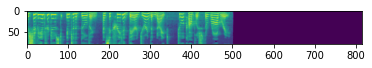

In [113]:
aligner.eval()
for epoch in range(10):  # loop over the dataset multiple times
    model.train()
    for i, data in islice(enumerate(tqdm(dataloader_train)),len(dataloader_train)):
        durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
        inputs_text = data.tokens.to(device)
        inputs_text_len = data.token_lengths.to(device)
        inputs_wavs = data.waveform.to(device)
        inputs_wavs_len = data.waveforn_length.to(device)

        specs_GT = featurizer(inputs_wavs)

        if durations.shape != inputs_text.shape:
            print(" log unequal dim")
        durations = (durations[:,:inputs_text.shape[-1]])
        durations = (durations / durations.sum(dim=1)[:, None])
        durations = durations * inputs_wavs_len[:, None]
        durations = durations.cumsum(dim=1).int()
        durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max())
        for j in range(len(durations)):
            row = torch.unique_consecutive(durations[j])
            durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)
        for j in range(durations.shape[0]):
            pred = 0
            for k in range(durations.shape[-1]):
                curr = durations[j][k]
                if pred != 0 and curr != 0:
                    durations[j][k] -= pred
                pred += curr


        optimizer.zero_grad()
        spec_out, dur_out = model(inputs_text, durations)
        groud_true = torch.log(durations.clamp(1e-5)) 
        try:
            loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
        except:
            print("continue\n\n")
            continue
        print(" ",loss.cpu())
        wandb.log({"loss": loss})

        if ( i  % 50 == 0  ):
            wandb.log({
                "Audio valid every n step": [wandb.Audio(vocoder.inference(spec_out[0].unsqueeze(dim=0)).cpu()[0], caption="Audio in train", sample_rate=22050)],
                "Spec train ": [wandb.Image(plt.imshow((spec_out[0]).cpu().detach().numpy()), caption="Spec train ")],
                "Spec train GroundTrue": [wandb.Image(plt.imshow((specs_GT[0].cpu())), caption="Spec train GroundTrue")]
                })
        loss.backward()
        optimizer.step()
    model.eval()

    for i, data in islice(enumerate(tqdm(dataloader_valid)),50):
        durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
        inputs_text = data.tokens.to(device)
        inputs_text_len = data.token_lengths.to(device)
        inputs_wavs = data.waveform.to(device)
        inputs_wavs_len = data.waveforn_length.to(device)
        specs_GT = featurizer(inputs_wavs)

        if durations.shape != inputs_text.shape:
            print(" log unequal dim")

        durations = (durations[:,:inputs_text.shape[-1]])
        durations = (durations / durations.sum(dim=1)[:, None])
        durations = durations * inputs_wavs_len[:, None]
        durations = durations.cumsum(dim=1).int()
        durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max())

        for j in range(len(durations)):
            row = torch.unique_consecutive(durations[j])
            durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)
        for j in range(durations.shape[0]):
            pred = 0
            for k in range(durations.shape[-1]):
                curr = durations[j][k]
                if pred != 0 and curr != 0:
                    durations[j][k] -= pred
                pred += curr

        spec_out, dur_out = model(inputs_text, durations)
        groud_true = torch.log(durations.clamp(1e-5)) 
        try:
            loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
        except:
            print("continue\n\n")
            continue

        print(" ",float(loss))
        wandb.log({"loss In validation": loss})

        if ( i  % 8 == 0  ):
            wandb.log({
                "Audio In validation": [wandb.Audio(vocoder.inference(spec_out[0].unsqueeze(dim=0)).cpu()[0], caption="Audio In validation", sample_rate=22050)],
                "Spec In validation": [wandb.Image(plt.imshow((spec_out[0]).cpu().detach().numpy()), caption="Spec In validation")],
                "Spec GroundTrue In validation": [wandb.Image(plt.imshow((specs_GT[0].cpu())), caption="Spec GroundTrue In validation")]
                })

In [229]:
model.eval()

for i, data in islice(enumerate(tqdm(dataloader_valid)),50):
    durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
    inputs_text = data.tokens.to(device)
    inputs_text_len = data.token_lengths.to(device)
    inputs_wavs = data.waveform.to(device)
    inputs_wavs_len = data.waveforn_length.to(device)
    specs_GT = featurizer(inputs_wavs)
    text = data.transcript
    if durations.shape != inputs_text.shape:
        print(" log unequal dim")

    durations = (durations[:,:inputs_text.shape[-1]])
    durations = (durations / durations.sum(dim=1)[:, None])
    durations = durations * inputs_wavs_len[:, None]
    durations = durations.cumsum(dim=1).int()
    durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max())

    for j in range(len(durations)):
        row = torch.unique_consecutive(durations[j])
        durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)
    for j in range(durations.shape[0]):
        pred = 0
        for k in range(durations.shape[-1]):
            curr = durations[j][k]
            if pred != 0 and curr != 0:
                durations[j][k] -= pred
            pred += curr

    spec_out, dur_out = model(inputs_text, )
    groud_true = torch.log(durations.clamp(1e-5)) 
    loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
    print("continue\n\n")
    continue


  0%|          | 0/131 [00:00<?, ?it/s]

outp= torch.Size([10, 787, 384])


  0%|          | 0/131 [00:01<?, ?it/s]

outp= torch.Size([10, 161, 1])


RuntimeError: ignored

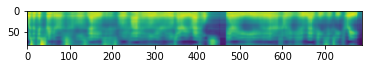

In [230]:
plt.imshow((spec_out[0]).cpu().detach().numpy())

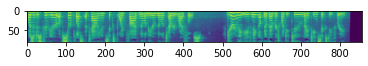

In [231]:
plt.imshow((specs_GT[0].cpu()))

In [232]:
text

('was a distributor of surplus Italian six point five-millimeter military rifles. During the evening of November twenty-two, nineteen sixty-three,',
 'Thus, when the inspectors visited there were twenty-three strangers, and only twenty-eight prisoners.',
 'Anyone who was familiar with that area of Dallas would have known that the motorcade would probably pass the Texas School Book Depository to get from Main Street',
 'let down. A full view of them was thus at all times obtainable by the officers who, without intermission, day and night patrolled the ward.',
 "Oswald's jacket was found along the path of flight taken by the gunman as he fled from the scene of the killing.",
 'the bottom of the palm rested on the box.',
 'the spikes of the railing penetrated his flesh and made progression slow and difficult.',
 'the Society pursued its laudable undertaking with remarkable energy and great singleness of purpose.',
 'In places even the bases have disappeared, and their moats have long been

In [233]:
display.display(display.Audio(vocoder.inference(spec_out[-1].unsqueeze(dim=0).cuda()).cpu(), rate=22050))


In [172]:
spec_out, dur_out = model(inputs_text, durations)

In [ ]:
dur_out

In [179]:
torch.round(torch.exp(dur_out.squeeze())).sum(dim=1)

tensor([787., 455., 752., 714., 523., 191., 433., 507., 495., 517.],
       device='cuda:0', grad_fn=<SumBackward1>)

In [177]:
durations.sum(dim=1)

tensor([824., 560., 857., 827., 570., 226., 481., 558., 544., 590.],
       device='cuda:0')

In [78]:
vocoder.inference(spec_out[0].unsqueeze(dim=0)).cpu()[0]

tensor([-1.1473e-03, -1.2310e-03, -1.0190e-03,  ...,  1.7396e-05,
        -5.6939e-06,  2.5489e-05])

In [ ]:
wandb.log({
    "Audio valid every n step": [wandb.Audio(vocoder.inference(spec_out[0].unsqueeze(dim=0)).cpu()[0], caption="Audio In validation", sample_rate=22050)],
    "Spec In validation": [wandb.Image(plt.imshow((spec_out[0]).cpu().detach().numpy()), caption="Spec In validation")],
    "Spec GroundTrue In validation": [wandb.Image(plt.imshow((specs_GT[0].cpu())), caption="Spec GroundTrue In validation")]
    })

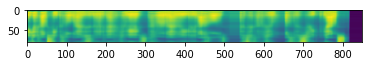

In [79]:
plt.imshow((spec_out[0]).cpu().detach().numpy())

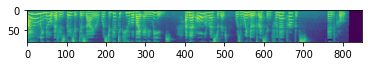

In [90]:
plt.imshow((specs_GT[-4].cpu()))

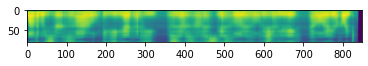

In [81]:
plt.imshow((spec_out[1]).cpu().detach().numpy())

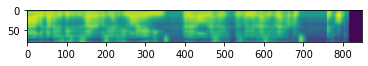

In [89]:
plt.imshow((spec_out[-4]).cpu().detach().numpy())

In [83]:
reconstructed_wav = vocoder.inference(spec_out[4].unsqueeze(dim=0).cuda()).cpu()

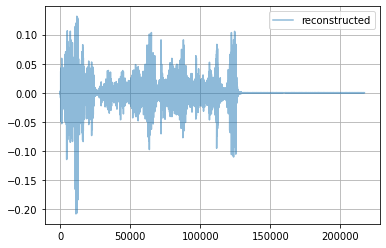

In [84]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [92]:
text

('Whaley picked Oswald.',
 'all instructions from higher authority were communicated to him orally.',
 "But Saward's operations were mainly directed to the fabrication and uttering of forged cheques.",
 'The looms were constantly busy. Tailors were always at work, and every article of clothing and bedding was made up within the walls.',
 'the French refugee, was a murderer of the same description, who dispatched his victim with a loaded cane, after which, to secure his escape,',
 'Thus in eighteen thirteen the exaction of jail fees had been forbidden by law,',
 'and when a sufficient number were completed they baked the bricks in kilns.',
 'His wealth was well known to "Maria," as he called Mrs. Manning, who made several ineffectual attempts to get money out of him.',
 'Some years later an eye-witness published a graphic account of one of these scenes.',
 'The original plan called for the President to spend only one day in the State, making whirlwind visits to Dallas, Fort Worth, San A

In [95]:
display.display(display.Audio(vocoder.inference(spec_out[-1].unsqueeze(dim=0).cuda()).cpu(), rate=22050))


In [118]:
text

("Givens said to Oswald, quote, Boy are you going downstairs? It's near lunch time, end quote.",
 'Its present manual filing system is obsolete;',
 'and not to his race.',
 "He even threatened to tear up his wife's dresses and break all the baby things. According to De Mohrenschildt,",
 'it is obvious that legibility is the first thing to be aimed at in the forms of the letters;',
 'Alan H. Belmont, Assistant to the Director of the FBI, testified that this revision was initiated by the FBI itself.',
 'its inability to process large amounts of data, and its failure to provide specific descriptions of the kind of information it sought.',
 'to shoot General Walker.',
 'On the whole the type of this book may be considered the ne-plus-ultra of Gothic type,',
 'He was ostensibly a publican,')

In [121]:
display.display(display.Audio(vocoder.inference(spec_out[-2].unsqueeze(dim=0).cuda()).cpu(), rate=22050))


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# torch.save(model.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/TTS/Full DS/state_dict_model_commonvoice.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/TTS/Full DS/ver2.pt') 

In [ ]:
# torch.save(model.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/TTS/Full DS/kind-spaceship-14.pt') 

In [114]:
# torch.save(model.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/TTS/Full DS/polar-violet-26.pt') 

# TRASH

In [ ]:
loss_one(dur_out.squeeze(), torch.log(durations))

tensor(inf, grad_fn=<MseLossBackward0>)

In [ ]:
durations

In [ ]:
dur_out.squeeze().shape

torch.Size([5, 131])

In [ ]:
inputs_text.shape

torch.Size([5, 131])

In [ ]:
dur_out.shape

torch.Size([5, 116, 1])

In [ ]:
data.durations[0] * data.waveforn_length[0]

In [ ]:
prim = data.durations[1]
prim 

In [ ]:
prim.sum()

tensor(0.9459)

In [ ]:
prim = prim / prim.sum()
prim

In [ ]:
data.durations[1].sum()

tensor(0.9459)

In [ ]:
(data.durations / data.durations.sum(dim=1)[:,None])

In [ ]:
specs_GT.shape

torch.Size([5, 80, 665])

In [ ]:
inputs_wavs_len

tensor([119197, 130717, 139421, 170141, 160413], dtype=torch.int32)

In [ ]:
inputs_wavs_len.max() * specs_GT.shape[-1] 

tensor(113143765, dtype=torch.int32)

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
plt.imshow((specs_GT[0]))

In [ ]:
(data.durations / data.durations.sum(dim=1)[:,None])

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
specs_GT.shape

torch.Size([5, 80, 665])

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
# (input_dur * torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())[:, None])

# Trash

In [ ]:
data.waveforn_length[index]

tensor(119197, dtype=torch.int32)

In [ ]:
index = 4

waveform = data.waveform[index]
durations = data.durations[index]


In [ ]:
durations = (data.durations[index] / data.durations[index].sum())
durations.sum()

tensor(1.0000)

In [ ]:
durations = durations * data.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

In [ ]:
durations

In [ ]:
plt.imshow(featurizer(waveform))

In [ ]:
featurizer(waveform).shape

torch.Size([80, 665])

In [ ]:
durations

In [ ]:
data.waveforn_length[:,None]

In [ ]:
torch.ceil(durations* specs_GT.shape[-1] / data.waveforn_length[:].max())

In [ ]:
featurizer(waveform).shape

torch.Size([80, 665])

In [ ]:
164

164

# Trash too


In [ ]:
data.durations

In [ ]:
waveform = data.waveform
durations = data.durations
print(durations)
durations = (data.durations / data.durations[:].sum(dim=1)[:, None])
durations = durations * data.waveforn_length[:, None]
durations = durations.cumsum(dim=1).int()
torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max()).shape

In [ ]:
out = torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max())

In [ ]:
out.shape

In [ ]:
out[:,-12:]

In [ ]:
(out[:,:dur_out.squeeze().shape[-1]])[:,-10:]

In [ ]:
for i, wav in enumerate(inputs_wavs):
    print(featurizer(wav[:inputs_wavs_len[i]]).shape)

In [ ]:
waveform = data.waveform
durations = data.durations

In [ ]:
durations = (data.durations / data.durations[:].sum(dim=1)[:, None])

In [ ]:
durations = durations * data.waveforn_length[:, None]
durations = durations.cumsum(dim=1).int()

In [ ]:
out = torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max())
out

In [ ]:
out.shape[-1]

In [ ]:
row.shape[-1]

In [ ]:
out.shape[-1] - row.shape

In [ ]:
for i in out:
    row = torch.unique_consecutive(i)
    row = F.pad(row, (0, out.shape[-1] - row.shape[-1]), "constant", 0)
    print(row)

In [ ]:
sha

In [ ]:
torch.unique_consecutive(out[0]).shape

In [ ]:
  F.pad(torch.unique_consecutive(out[0]), (0, 4), "constant", 0)

In [ ]:
for i

In [ ]:
len(durations)

5

In [ ]:
for_time.shape, durations.shape[0]

In [ ]:
durations = durations.long()

In [ ]:
durations

In [ ]:
torch.sum(durations, dim=-1).max()

tensor(742)

In [ ]:
for i, wav in enumerate(inputs_wavs):
    print(featurizer(wav[:inputs_wavs_len[i]]).shape)

In [ ]:
outp = torch.zeros((for_time.shape[0], torch.sum(durations, dim=-1).max(), for_time.shape[-1]))

In [ ]:
outp.shape

torch.Size([5, 742, 384])

In [ ]:
outp = torch.zeros((for_time.shape[0], torch.sum(durations, dim=-1).max(), for_time.shape[-1]))
N, L = durations.shape
for j in range(N):
    count = 0
    for k in range(L):
        kol = durations[j][k]
        if kol != 0:
            outp[j,count:count+kol] = for_time[j,k]
            print(count,count+kol, for_time[j,k][:6])
            count += kol


In [ ]:
outp.shape

In [ ]:
# outp[0][416]

In [ ]:
for i in for_time[-1]:
    print(i[:5])

In [ ]:
durations[-1]

In [ ]:
outp[0][-:]

In [ ]:
outp

In [ ]:
durations

In [ ]:
for i in range(durations.shape[0]):
    pred = 0
    for j in range(durations.shape[-1]):
        curr = durations[i][j]
        if pred != 0 and curr != 0:
            durations[i][j] -= pred
        pred += curr

In [ ]:
durations

In [ ]:
durations

# Новый sdfsdf

In [122]:
durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
inputs_text = data.tokens.to(device)
inputs_text_len = data.token_lengths.to(device)
inputs_wavs = data.waveform.to(device)
inputs_wavs_len = data.waveforn_length.to(device)
specs_GT = featurizer(inputs_wavs)
text = data.transcript
if durations.shape != inputs_text.shape:
    print(" log unequal dim")

durations = (durations[:,:inputs_text.shape[-1]])
durations = (durations / durations.sum(dim=1)[:, None])
durations = durations * inputs_wavs_len[:, None]
durations = durations.cumsum(dim=1).int()
durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max())

for j in range(len(durations)):
    row = torch.unique_consecutive(durations[j])
    durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)
for j in range(durations.shape[0]):
    pred = 0
    for k in range(durations.shape[-1]):
        curr = durations[j][k]
        if pred != 0 and curr != 0:
            durations[j][k] -= pred
        pred += curr

In [138]:
durations.shape

torch.Size([10, 159])

In [124]:
spec_out, dur_out = model(inputs_text, durations)

In [139]:
torch.floor(torch.exp(dur_out.squeeze()))

tensor([[6., 7., 2.,  ..., 0., 0., 0.],
        [2., 3., 3.,  ..., 2., 3., 1.],
        [2., 4., 2.,  ..., 0., 0., 0.],
        ...,
        [7., 2., 5.,  ..., 0., 0., 0.],
        [2., 7., 4.,  ..., 0., 0., 0.],
        [2., 3., 7.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<FloorBackward0>)

In [130]:
durations.shape

torch.Size([10, 159])

In [ ]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveforn_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [323]:
def to_tokens(sentence):
    tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()
    tokens, token_lengths = tokenizer(sentence)
    return tokens, token_lengths 

In [345]:
tec = to_tokens("A defibrillator is a device that gives a high energy electric shock to the heart of someone who is in cardiac arrest")[0]

In [ ]:
torch.cat((tec,tec))

In [347]:
spec_out, dur_out = model(torch.cat((tec,tec)).cuda(), )


outp= torch.Size([2, 580, 384])
torch.Size([2, 116])
outp= torch.Size([2, 116, 1])


In [ ]:
spec_out

In [ ]:
plt.imshow((spec_out[0]).cpu().detach().numpy())

In [352]:
display.display(display.Audio(vocoder.inference(spec_out[1].unsqueeze(dim=0).cuda()).cpu(), rate=22050))


In [351]:
torchaudio.save("output_waveglow.wav", vocoder.inference(spec_out[0].unsqueeze(dim=0).cuda()).cpu(), sample_rate=22050)